In [40]:
import torch

# GPU durumunu kontrol et
gpu_available = torch.cuda.is_available()
print(f"🔍 GPU Durumu: {'✅ Mevcut' if gpu_available else '❌ CPU Modu'}")


🔍 GPU Durumu: ✅ Mevcut


## Set-up environment

First, let's install the relevant libraries:
* 🤗 Transformers, for the model
* 🤗 Datasets, for loading + processing the data
* PyTorch Lightning, for training the model 
* Weights and Biases, for logging metrics during training
* Sentencepiece, used for tokenization.

We'll use PyTorch Lightning for training here, but note that this is optional, you can of course also just train in native PyTorch or use 🤗 Accelerate, or the 🤗 Trainer.

In [41]:
%pip install -q transformers datasets sentencepiece

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [42]:
%pip install -q pytorch-lightning wandb python-dotenv

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Load dataset

Next, let's load the dataset from the [hub](https://huggingface.co/datasets/katanaml-org/invoices-donut-data-v1). The dataset consists of (image, JSON) pairs. Note that it doesn't have to be JSON, it could also be JSON lines, plain text, etc. 

In [43]:
from datasets import load_dataset

dataset = load_dataset("katanaml-org/invoices-donut-data-v1")

In [44]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 425
    })
    validation: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 50
    })
    test: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 26
    })
})

Let's take a look at the first training example:

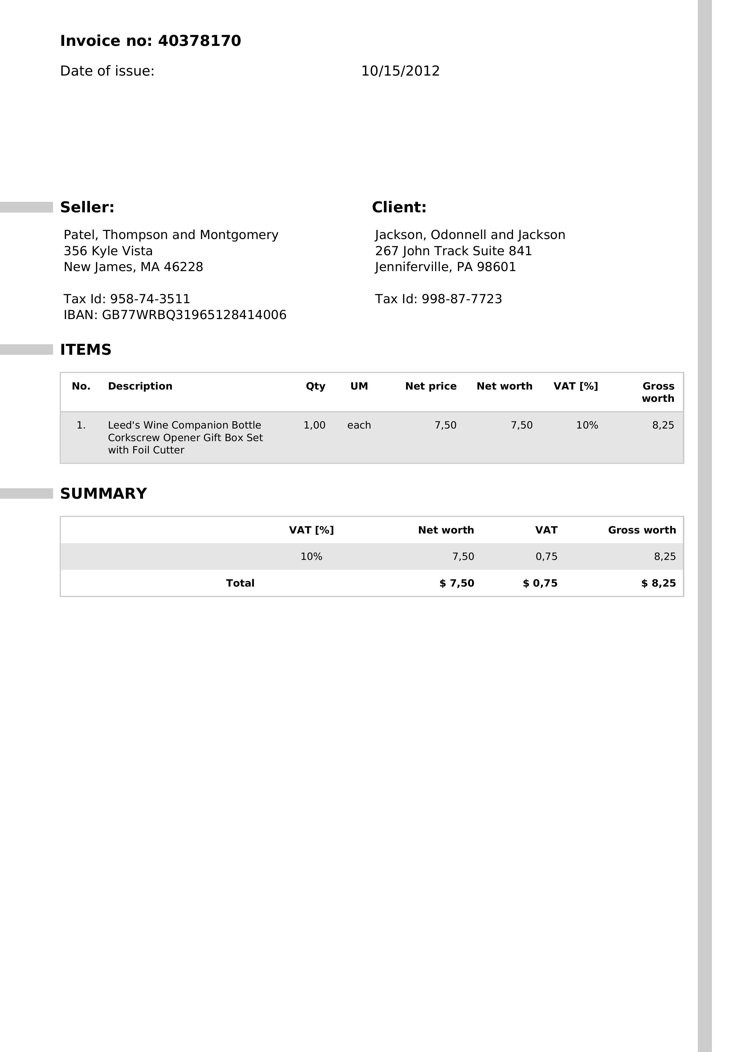

In [45]:
example = dataset['train'][0]
image = example['image']
# let's make the image a bit smaller when visualizing
width, height = image.size
display(image.resize((int(width*0.3), int(height*0.3))))

In [46]:
# let's load the corresponding JSON dictionary (as string representation)
ground_truth = example['ground_truth']
print(ground_truth)

{"gt_parse": {"header": {"invoice_no": "40378170", "invoice_date": "10/15/2012", "seller": "Patel, Thompson and Montgomery 356 Kyle Vista New James, MA 46228", "client": "Jackson, Odonnell and Jackson 267 John Track Suite 841 Jenniferville, PA 98601", "seller_tax_id": "958-74-3511", "client_tax_id": "998-87-7723", "iban": "GB77WRBQ31965128414006"}, "items": [{"item_desc": "Leed's Wine Companion Bottle Corkscrew Opener Gift Box Set with Foil Cutter", "item_qty": "1,00", "item_net_price": "7,50", "item_net_worth": "7,50", "item_vat": "10%", "item_gross_worth": "8,25"}], "summary": {"total_net_worth": "$7,50", "total_vat": "$0,75", "total_gross_worth": "$8,25"}}}


We can also parse the string as a Python dictionary using `ast.literal_eval`. Each training example has a single "gt_parse" key, which contains the ground truth parsing of the document:

In [47]:
from ast import literal_eval

literal_eval(ground_truth)['gt_parse']

{'header': {'invoice_no': '40378170',
  'invoice_date': '10/15/2012',
  'seller': 'Patel, Thompson and Montgomery 356 Kyle Vista New James, MA 46228',
  'client': 'Jackson, Odonnell and Jackson 267 John Track Suite 841 Jenniferville, PA 98601',
  'seller_tax_id': '958-74-3511',
  'client_tax_id': '998-87-7723',
  'iban': 'GB77WRBQ31965128414006'},
 'items': [{'item_desc': "Leed's Wine Companion Bottle Corkscrew Opener Gift Box Set with Foil Cutter",
   'item_qty': '1,00',
   'item_net_price': '7,50',
   'item_net_worth': '7,50',
   'item_vat': '10%',
   'item_gross_worth': '8,25'}],
 'summary': {'total_net_worth': '$7,50',
  'total_vat': '$0,75',
  'total_gross_worth': '$8,25'}}

## Load model and processor

Next, we load the model (Donut is an instance of [VisionEncoderDecoderModel](https://huggingface.co/docs/transformers/model_doc/vision-encoder-decoder)), and the processor, which is the object that can be used to prepare inputs for the model.

We'll update some settings for fine-tuning, namely the image size and the max length of the decoder.

In [48]:
from transformers import VisionEncoderDecoderConfig

# ⚖️ 6GB VRAM için DENGELI ayarlar - Öğrenme kapasitesi korundu
image_size = [640, 480]  # Dengeli boyut (orijinal 1280x960'dan %50 küçük)
max_length = 384  # Yeterli uzunluk (orijinal 768'den %50 küçük)

print(f"🖼️ Görüntü boyutu: {image_size}")
print(f"📝 Maksimum uzunluk: {max_length}")

# update image_size of the encoder
# during pre-training, a larger image size was used
config = VisionEncoderDecoderConfig.from_pretrained("naver-clova-ix/donut-base")
config.encoder.image_size = image_size # (height, width)
# update max_length of the decoder (for generation)
config.decoder.max_length = max_length
# TODO we should actually update max_position_embeddings and interpolate the pre-trained ones:
# https://github.com/clovaai/donut/blob/0acc65a85d140852b8d9928565f0f6b2d98dc088/donut/model.py#L602

🖼️ Görüntü boyutu: [640, 480]
📝 Maksimum uzunluk: 384


Next, we instantiate the model with our custom config, as well as the processor. Make sure that all pre-trained weights are correctly loaded (a warning would tell you if that's not the case).

In [49]:
from transformers import DonutProcessor, VisionEncoderDecoderModel

processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base")
model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base", config=config)

## Create PyTorch dataset

Here we create a regular PyTorch dataset.

The model doesn't directly take the (image, JSON) pairs as input and labels. Rather, we create `pixel_values` and `labels`. Both are PyTorch tensors. The `pixel_values` are the input images (resized, padded and normalized), and the `labels` are the `input_ids` of the target sequence (which is a flattened version of the JSON), with padding tokens replaced by -100 (to make sure these are ignored by the loss function). Both are created using `DonutProcessor` (which internally combines an image processor, for the image modality, and a tokenizer, for the text modality).

Note that we're also adding tokens to the vocabulary of the decoder (and corresponding tokenizer) for all keys of the dictionaries in our dataset, like "\<s_invoice>". This makes sure the model learns an embedding vector for them. Without doing this, some keys might get split up into multiple subword tokens, in which case the model just learns an embedding for the subword tokens, rather than a direct embedding for these keys.

In [50]:
import json
import random
from typing import Any, List, Tuple

import torch
from torch.utils.data import Dataset

added_tokens = []

class DonutDataset(Dataset):
    """
    PyTorch Dataset for Donut. This class takes a HuggingFace Dataset as input.
    
    Each row, consists of image path(png/jpg/jpeg) and gt data (json/jsonl/txt),
    and it will be converted into pixel_values (vectorized image) and labels (input_ids of the tokenized string).
    
    Args:
        dataset_name_or_path: name of dataset (available at huggingface.co/datasets) or the path containing image files and metadata.jsonl
        max_length: the max number of tokens for the target sequences
        split: whether to load "train", "validation" or "test" split
        ignore_id: ignore_index for torch.nn.CrossEntropyLoss
        task_start_token: the special token to be fed to the decoder to conduct the target task
        prompt_end_token: the special token at the end of the sequences
        sort_json_key: whether or not to sort the JSON keys
    """

    def __init__(
        self,
        dataset_name_or_path: str,
        max_length: int,
        split: str = "train",
        ignore_id: int = -100,
        task_start_token: str = "<s>",
        prompt_end_token: str = None,
        sort_json_key: bool = True,
    ):
        super().__init__()

        self.max_length = max_length
        self.split = split
        self.ignore_id = ignore_id
        self.task_start_token = task_start_token
        self.prompt_end_token = prompt_end_token if prompt_end_token else task_start_token
        self.sort_json_key = sort_json_key

        self.dataset = load_dataset(dataset_name_or_path, split=self.split)
        self.dataset_length = len(self.dataset)

        self.gt_token_sequences = []
        for sample in self.dataset:
            ground_truth = json.loads(sample["ground_truth"])
            if "gt_parses" in ground_truth:  # when multiple ground truths are available, e.g., docvqa
                assert isinstance(ground_truth["gt_parses"], list)
                gt_jsons = ground_truth["gt_parses"]
            else:
                assert "gt_parse" in ground_truth and isinstance(ground_truth["gt_parse"], dict)
                gt_jsons = [ground_truth["gt_parse"]]

            self.gt_token_sequences.append(
                [
                    self.json2token(
                        gt_json,
                        update_special_tokens_for_json_key=self.split == "train",
                        sort_json_key=self.sort_json_key,
                    )
                    + processor.tokenizer.eos_token
                    for gt_json in gt_jsons  # load json from list of json
                ]
            )

        self.add_tokens([self.task_start_token, self.prompt_end_token])
        self.prompt_end_token_id = processor.tokenizer.convert_tokens_to_ids(self.prompt_end_token)

    def json2token(self, obj: Any, update_special_tokens_for_json_key: bool = True, sort_json_key: bool = True):
        """
        Convert an ordered JSON object into a token sequence
        """
        if type(obj) == dict:
            if len(obj) == 1 and "text_sequence" in obj:
                return obj["text_sequence"]
            else:
                output = ""
                if sort_json_key:
                    keys = sorted(obj.keys(), reverse=True)
                else:
                    keys = obj.keys()
                for k in keys:
                    if update_special_tokens_for_json_key:
                        self.add_tokens([fr"<s_{k}>", fr"</s_{k}>"])
                    output += (
                        fr"<s_{k}>"
                        + self.json2token(obj[k], update_special_tokens_for_json_key, sort_json_key)
                        + fr"</s_{k}>"
                    )
                return output
        elif type(obj) == list:
            return r"<sep/>".join(
                [self.json2token(item, update_special_tokens_for_json_key, sort_json_key) for item in obj]
            )
        else:
            obj = str(obj)
            if f"<{obj}/>" in added_tokens:
                obj = f"<{obj}/>"  # for categorical special tokens
            return obj
    
    def add_tokens(self, list_of_tokens: List[str]):
        """
        Add special tokens to tokenizer and resize the token embeddings of the decoder
        """
        newly_added_num = processor.tokenizer.add_tokens(list_of_tokens)
        if newly_added_num > 0:
            model.decoder.resize_token_embeddings(len(processor.tokenizer))
            added_tokens.extend(list_of_tokens)
    
    def __len__(self) -> int:
        return self.dataset_length

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Load image from image_path of given dataset_path and convert into input_tensor and labels
        Convert gt data into input_ids (tokenized string)
        Returns:
            input_tensor : preprocessed image
            input_ids : tokenized gt_data
            labels : masked labels (model doesn't need to predict prompt and pad token)
        """
        sample = self.dataset[idx]

        # inputs
        pixel_values = processor(sample["image"], random_padding=self.split == "train", return_tensors="pt").pixel_values
        pixel_values = pixel_values.squeeze()

        # targets
        target_sequence = random.choice(self.gt_token_sequences[idx])  # can be more than one, e.g., DocVQA Task 1
        input_ids = processor.tokenizer(
            target_sequence,
            add_special_tokens=False,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )["input_ids"].squeeze(0)

        labels = input_ids.clone()
        labels[labels == processor.tokenizer.pad_token_id] = self.ignore_id  # model doesn't need to predict pad token
        # labels[: torch.nonzero(labels == self.prompt_end_token_id).sum() + 1] = self.ignore_id  # model doesn't need to predict prompt (for VQA)
        return pixel_values, labels, target_sequence

Next, we instantiate the datasets:

In [51]:
# we update some settings which differ from pretraining; namely the size of the images + no rotation required
# source: https://github.com/clovaai/donut/blob/master/config/train_cord.yaml
processor.image_processor.size = image_size[::-1] # should be (width, height)
processor.image_processor.do_align_long_axis = False

train_dataset = DonutDataset("katanaml-org/invoices-donut-data-v1", max_length=max_length,
                             split="train", task_start_token="<s_invoices-donut-data-v1>", prompt_end_token="<s_invoices-donut-data-v1>",
                             sort_json_key=False, # cord dataset is preprocessed, so no need for this
                             )

val_dataset = DonutDataset("katanaml-org/invoices-donut-data-v1", max_length=max_length,
                             split="validation", task_start_token="<s_invoices-donut-data-v1>", prompt_end_token="<s_invoices-donut-data-v1>",
                             sort_json_key=False, # cord dataset is preprocessed, so no need for this
                             )

Let's check which tokens are added:

In [52]:
len(added_tokens)

42

In [53]:
print(added_tokens)

['<s_header>', '</s_header>', '<s_invoice_no>', '</s_invoice_no>', '<s_invoice_date>', '</s_invoice_date>', '<s_seller>', '</s_seller>', '<s_client>', '</s_client>', '<s_seller_tax_id>', '</s_seller_tax_id>', '<s_client_tax_id>', '</s_client_tax_id>', '<s_iban>', '</s_iban>', '<s_items>', '</s_items>', '<s_item_desc>', '</s_item_desc>', '<s_item_qty>', '</s_item_qty>', '<s_item_net_price>', '</s_item_net_price>', '<s_item_net_worth>', '</s_item_net_worth>', '<s_item_vat>', '</s_item_vat>', '<s_item_gross_worth>', '</s_item_gross_worth>', '<s_summary>', '</s_summary>', '<s_total_net_worth>', '</s_total_net_worth>', '<s_total_vat>', '</s_total_vat>', '<s_total_gross_worth>', '</s_total_gross_worth>', '<s_None>', '</s_None>', '<s_invoices-donut-data-v1>', '<s_invoices-donut-data-v1>']


In [54]:
# the vocab size attribute stays constants (might be a bit unintuitive - but doesn't include special tokens)
print("Original number of tokens:", processor.tokenizer.vocab_size)
print("Number of tokens after adding special tokens:", len(processor.tokenizer))

Original number of tokens: 57522
Number of tokens after adding special tokens: 57566


You can verify that a token like `</s_unitprice>` was added to the vocabulary of the tokenizer (and the model):

In [55]:
processor.decode([57560])

'</s_total_vat>'

As always, it's very important to verify whether our data is prepared correctly. Let's check the first training example:

In [56]:
pixel_values, labels, target_sequence = train_dataset[0]

This returns the `pixel_values` (the image, but prepared for the model as a PyTorch tensor), the `labels` (which are the encoded `input_ids` of the target sequence, which we want Donut to learn to generate) and the original `target_sequence`. The reason we also return the latter is because this will allow us to compute metrics between the generated sequences and the ground truth target sequences.

In [57]:
print(pixel_values.shape)

torch.Size([3, 640, 480])


In [58]:
# let's print the labels (the first 30 token ID's)
for id in labels.tolist()[:30]:
  if id != -100:
    print(processor.decode([id]))
  else:
    print(id)

<s_header>
<s_invoice_no>
40
3
78
170
</s_invoice_no>
<s_invoice_date>
10
/15
/
2012
</s_invoice_date>
<s_seller>
Pa
tel
,
Thompson
and
Mont
gom
ery
3
56
Kyl
e
Vista
New
James
,


In [59]:
# let's check the corresponding target sequence, as a string
print(target_sequence)

<s_header><s_invoice_no>40378170</s_invoice_no><s_invoice_date>10/15/2012</s_invoice_date><s_seller>Patel, Thompson and Montgomery 356 Kyle Vista New James, MA 46228</s_seller><s_client>Jackson, Odonnell and Jackson 267 John Track Suite 841 Jenniferville, PA 98601</s_client><s_seller_tax_id>958-74-3511</s_seller_tax_id><s_client_tax_id>998-87-7723</s_client_tax_id><s_iban>GB77WRBQ31965128414006</s_iban></s_header><s_items><s_item_desc>Leed's Wine Companion Bottle Corkscrew Opener Gift Box Set with Foil Cutter</s_item_desc><s_item_qty>1,00</s_item_qty><s_item_net_price>7,50</s_item_net_price><s_item_net_worth>7,50</s_item_net_worth><s_item_vat>10%</s_item_vat><s_item_gross_worth>8,25</s_item_gross_worth></s_items><s_summary><s_total_net_worth>$7,50</s_total_net_worth><s_total_vat>$0,75</s_total_vat><s_total_gross_worth>$8,25</s_total_gross_worth></s_summary></s>


Another important thing is that we need to set 2 additional attributes in the configuration of the model. This is not required, but will allow us to train the model by only providing the decoder targets, without having to provide any decoder inputs.

The model will automatically create the `decoder_input_ids` (the decoder inputs) based on the `labels`, by shifting them one position to the right and prepending the decoder_start_token_id. I recommend checking [this video](https://www.youtube.com/watch?v=IGu7ivuy1Ag&t=888s&ab_channel=NielsRogge) if you want to understand how models like Donut automatically create decoder_input_ids - and more broadly how Donut works.

In [60]:
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.decoder_start_token_id = processor.tokenizer.convert_tokens_to_ids(['<s_invoices-donut-data-v1>'])[0]

In [61]:
# sanity check
print("Pad token ID:", processor.decode([model.config.pad_token_id]))
print("Decoder start token ID:", processor.decode([model.config.decoder_start_token_id]))

Pad token ID: <pad>
Decoder start token ID: <s_invoices-donut-data-v1>


## Create PyTorch DataLoaders

Next, we create corresponding PyTorch DataLoaders, which allow us to loop over the dataset in batches:

In [62]:
from torch.utils.data import DataLoader

# feel free to increase the batch size if you have a lot of memory
# I'm fine-tuning on Colab and given the large image size, batch size > 1 is not feasible
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)

Let's verify a batch:

In [63]:
batch = next(iter(train_dataloader))
pixel_values, labels, target_sequences = batch
print(pixel_values.shape)

torch.Size([1, 3, 640, 480])


In [64]:
for id in labels.squeeze().tolist()[:30]:
  if id != -100:
    print(processor.decode([id]))
  else:
    print(id)

<s_header>
<s_invoice_no>

877
349
08
</s_invoice_no>
<s_invoice_date>
12
/19
/
2019
</s_invoice_date>
<s_seller>
Cha
se
,
Green
and
Baile
y
Unit
15
72
Box
96
04
D
PO
AP


In [65]:
print(len(train_dataset))
print(len(val_dataset))

425
50


In [66]:
# let's check the first validation batch
batch = next(iter(val_dataloader))
pixel_values, labels, target_sequences = batch
print(pixel_values.shape)

torch.Size([1, 3, 640, 480])


In [67]:
print(target_sequences[0])

<s_header><s_invoice_no>65321852</s_invoice_no><s_invoice_date>04/11/2021</s_invoice_date><s_seller>Kaufman, Cooper and Young 33451 Johnson Lake New Ann, NE 54138</s_seller><s_client>Wells-Carlson 148 Carroll Village Suite 393 South Allisonstad, TX 72090</s_client><s_seller_tax_id>930-79-7845</s_seller_tax_id><s_client_tax_id>957-82-7504</s_client_tax_id><s_iban>GB85XPMM58300597200061</s_iban></s_header><s_items><s_item_desc>New KID CUDI "WZRD" Rap Hip Hop Soul Music Men's Black T-Shirt Size S to 3XL</s_item_desc><s_item_qty>2,00</s_item_qty><s_item_net_price>22,49</s_item_net_price><s_item_net_worth>44,98</s_item_net_worth><s_item_vat>10%</s_item_vat><s_item_gross_worth>49,48</s_item_gross_worth><sep/><s_item_desc>boys bogs waterproof boots youth size 3</s_item_desc><s_item_qty>1,00</s_item_qty><s_item_net_price>9,80</s_item_net_price><s_item_net_worth>9,80</s_item_net_worth><s_item_vat>10%</s_item_vat><s_item_gross_worth>10,78</s_item_gross_worth><sep/><s_item_desc>Joma Boys Youth Go

## Define LightningModule

Next, we define a [LightningModule](https://pytorch-lightning.readthedocs.io/en/stable/common/lightning_module.html), which is the standard way to train a model in PyTorch Lightning. A LightningModule is an `nn.Module` with some additional functionality. 

Basically, PyTorch Lightning will take care of all device placements (`.to(device)`) for us, as well as the backward pass, putting the model in training mode, etc.

In [68]:
%pip install nltk


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [69]:
from pathlib import Path
import re
from nltk import edit_distance
import numpy as np
import math

from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import LambdaLR

import pytorch_lightning as pl
from pytorch_lightning.utilities import rank_zero_only


class DonutModelPLModule(pl.LightningModule):
    def __init__(self, config, processor, model):
        super().__init__()
        self.config = config
        self.processor = processor
        self.model = model

    def training_step(self, batch, batch_idx):
        pixel_values, labels, _ = batch
        outputs = self.model(pixel_values, labels=labels)
        loss = outputs.loss
        
        # Hem terminal progress bar’da hem W&B’de görünmesi için
        self.log("train_loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx, dataset_idx=0):
        pixel_values, labels, answers = batch
        batch_size = pixel_values.shape[0]
        
        decoder_input_ids = torch.full(
            (batch_size, 1),
            self.model.config.decoder_start_token_id,
            device=self.device
        )

        outputs = self.model.generate(
            pixel_values,
            decoder_input_ids=decoder_input_ids,
            max_length=max_length,
            early_stopping=True,
            pad_token_id=self.processor.tokenizer.pad_token_id,
            eos_token_id=self.processor.tokenizer.eos_token_id,
            use_cache=True,
            num_beams=1,
            bad_words_ids=[[self.processor.tokenizer.unk_token_id]],
            return_dict_in_generate=True,
        )

        predictions = []
        for seq in self.processor.tokenizer.batch_decode(outputs.sequences):
            seq = seq.replace(self.processor.tokenizer.eos_token, "").replace(self.processor.tokenizer.pad_token, "")
            seq = re.sub(r"<.*?>", "", seq, count=1).strip()
            predictions.append(seq)

        scores = []
        for pred, answer in zip(predictions, answers):
            pred = re.sub(r"(?:(?<=>) | (?=</s_))", "", pred)
            answer = answer.replace(self.processor.tokenizer.eos_token, "")
            scores.append(edit_distance(pred, answer) / max(len(pred), len(answer)))

            if self.config.get("verbose", False) and len(scores) == 1:
                print(f"Prediction: {pred}")
                print(f"    Answer: {answer}")
                print(f" Normed ED: {scores[0]}")

        mean_edit_distance = np.mean(scores)
        accuracy = 1 - mean_edit_distance  # Accuracy = 1 - normalized edit distance

        # W&B ve progress bar’da gözükecek loglar
        self.log("val_edit_distance", mean_edit_distance, prog_bar=True, on_epoch=True)
        self.log("val_acc", accuracy, prog_bar=True, on_epoch=True)

        return {"val_edit_distance": mean_edit_distance, "val_acc": accuracy}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.config.get("lr"))
        return optimizer


    def train_dataloader(self):
        return train_dataloader

    def val_dataloader(self):
        return val_dataloader

## Train!

Next, let's train! This happens instantiating a PyTorch Lightning `Trainer`, and then calling `trainer.fit`.

What's great is that we can automatically train on the hardware we have (in our case, a single GPU), enable mixed precision (`fp16=True`, which makes sure we don't consume as much memory), add Weights and Biases logging, and so on. 

In [70]:
# 🔥 EXTREME GPU bellek tasarrufu - Minimum ayarlar
config = {"max_epochs": 4,  # Çok az epoch (5 → 2)
          "val_check_interval": 0.5,  # Epoch sonunda validation (0.2 → 1.0)  
          "check_val_every_n_epoch": 1,  # Her 2 epoch'ta validation (1 → 2)
          "gradient_clip_val": 1.0,  # Daha düşük gradient clip (1.0 → 0.5)
          "num_training_samples_per_epoch": 300,  # Çok az sample (800 → 100)
          "lr": 3e-5,  # Düşük learning rate (3e-5 → 1e-5)
          "train_batch_sizes": [1],  # Minimum batch size (8 → 1)
          "val_batch_sizes": [1],
          "num_nodes": 1,
          "warmup_steps": 75,  # Minimum warmup (300 → 25)
          "result_path": "./result",
          "verbose": True,  # Daha az output (True → False)
          # 🚀 Ek bellek tasarrufu parametreleri
          "accumulate_grad_batches": 8,  # Büyük accumulation
          "limit_train_batches": 0.7,  # Sadece %25 training data
          "limit_val_batches": 0.5,   # Sadece %20 validation data
          "num_workers": 0,  # CPU worker'ları kapat
          "pin_memory": False,  # Pin memory kapat
          }

model_module = DonutModelPLModule(config, processor, model)

We'll use a custom callback to push our model to the hub during training (after each epoch + end of training). For that we'll log into our HuggingFace account.

In [71]:
#!huggingface-cli login

In [72]:
# Load environment variables from .env file
from dotenv import load_dotenv

load_dotenv()

True

In [73]:
# Get Pinecone API keys and Hugging Face tokens
import os

HUGGING_FACE_TOKEN = os.getenv("HUGGING_FACE_TOKEN")
WANDB_API_KEY = os.getenv("WANDB_API_KEY")

In [ ]:
print("HF Token:", HUGGING_FACE_TOKEN)    
print("Wandb Api Key:", WANDB_API_KEY)

In [75]:
from huggingface_hub import login

# HuggingFace Login
if HUGGING_FACE_TOKEN:
    print("🤗 HuggingFace login yapılıyor...")
    login(token=HUGGING_FACE_TOKEN)
    print("✅ HuggingFace login başarılı!")
else:
    print("⚠️  HuggingFace token bulunamadı!")


🤗 HuggingFace login yapılıyor...
✅ HuggingFace login başarılı!


In [76]:
%pip install wandb -qU

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [77]:
# Log in to your W&B account
import wandb
from pytorch_lightning.loggers import WandbLogger

wandb.login()

# WandB logger kontrolü
try:
    print(f"📊 WandB Logger mevcut: {wandb_logger}")
except NameError:
    print("⚠️  WandB logger bulunamadı, yeni oluşturuluyor...")
    wandb_logger = WandbLogger(project="Donut", name="demo-run-invoices-donut-data-v1")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


📊 WandB Logger mevcut: <pytorch_lightning.loggers.wandb.WandbLogger object at 0x0000013A069745E0>


In [78]:
# 🚀 PyTorch Lightning Import ve Callback Tanımları
import pytorch_lightning as pl
from pytorch_lightning.callbacks import Callback, EarlyStopping


# Model module kontrolü
try:
    print(f"🤖 Model module mevcut: {type(model_module)}")
except NameError:
    print("❌ model_module bulunamadı! Önce DonutModelPLModule oluşturulmalı.")
    print("📝 Lütfen önceki hücreleri sırayla çalıştırın.")

class PushToHubCallback(Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        print(f"Pushing model to the hub, epoch {trainer.current_epoch}")
        pl_module.model.push_to_hub("elifbeyza/donut-base-invoices-donut-data-v1",
                                    commit_message=f"Training in progress, epoch {trainer.current_epoch}")

    def on_train_end(self, trainer, pl_module):
        print(f"Pushing model to the hub after training")
        pl_module.processor.push_to_hub("elifbeyza/donut-base-invoices-donut-data-v1",
                                    commit_message=f"Training done")
        pl_module.model.push_to_hub("elifbeyza/donut-base-invoices-donut-data-v1",
                                    commit_message=f"Training done")

early_stop_callback = EarlyStopping(monitor="val_acc", patience=3, verbose=False, mode="min")



trainer = pl.Trainer(
        accelerator="gpu",
        devices=1,
        max_epochs=config.get("max_epochs"),
        val_check_interval=config.get("val_check_interval"),
        check_val_every_n_epoch=config.get("check_val_every_n_epoch"),
        gradient_clip_val=config.get("gradient_clip_val"),
        precision=16, # we'll use mixed precision
        num_sanity_val_steps=0,
        logger=wandb_logger,
        callbacks=[PushToHubCallback(), early_stop_callback],
        enable_progress_bar=True,
        log_every_n_steps=10,
        enable_checkpointing=True,
)

trainer.fit(model_module)

d:\Bill-Reader-App\env\lib\site-packages\lightning_fabric\connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


🤖 Model module mevcut: <class '__main__.DonutModelPLModule'>


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                      | Params | Mode
-----------------------------------------------------------
0 | model | VisionEncoderDecoderModel | 201 M  | eval
-----------------------------------------------------------
201 M     Trainable params
0         Non-trainable params
201 M     Total params
807.576   Total estimated model params size (MB)
0         Modules in train mode
484       Modules in eval mode
d:\Bill-Reader-App\env\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
d:\Bill-Reader-App\env\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argume

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_item_desc>65182</s_invoice_no>04/2021<s_seller>Laura Cooper and Young35 James New New New New New New New New New338 Lake Southland,TX790</s_client>9------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>65321852</s_invoice_no><s_invoice_date>04/11/2021</s_invoice_date><s_seller>Kaufman, Cooper and Young 33451 Johnson Lake New Ann, NE 54138</s_seller><s_client>Wells-Carlson 148 Carroll Village Suite 393 South Allisonstad, TX 72090</s_client><s_seller_tax_id>930-79-7845</s_seller_tax_id><s_client_tax_id>957-82-7504</s_client_tax_id><s_iban>GB85XPMM58300597200061</s_iban></s_header><s_items><s_item_desc>New KID CUDI "WZRD" Rap Hip Hop Soul Music Men

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_item_desc>162332</s_invoice_no>05/2017<s_seller>Lars ands 78 7 Stan Portssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss Incorss
    Answer: <s_invoice_no>16220332</s_invoice_no><s_invoice_date>05/15/2017</s_invoice_date><s_seller>Lawson and Sons 78147 Jackson Fords Gilesland, MI 45057</s_seller><s_client>Mosley LLC 913 Lawrence Mountains New Andrew, KY 46723</s_client><s_seller_tax_id>995-72-1473</s_seller_tax_id><s_client_tax_id>988-78-0364</s_client_tax_id><s_iban>GB30RUVA78076817247388</s_iban><s_item_desc>Yilong 2.5'x4' Hand Knotted Silk Garden Scene Rug Indoor Oriental Carpet 352B</s_item_desc><s_item_qty>2,00</s_item_qty><s_item_net_price>2 000,00</s_item_

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_item_desc>90663</s_invoice_no>02//2016<s_seller>Chap------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>90446683</s_invoice_no><s_invoice_date>02/11/2016</s_invoice_date><s_seller>Chang-Cooper 452 Miller Plains Apt. 418 Barrettside, UT 97139</s_seller><s_client>Peterson-Long 92441 Kimberly Curve East Mathew, OH 84858</s_client><s_seller_tax_id>911-96-2770</s_seller_tax_id><s_client_tax_id>911-96-7248</s_client_tax_id><s_iban>GB19LAZW37358375097586</s_iban></s_header><s_items><s_item_desc>Cabi 5610 Striped White Blue Launch Maxi Dress Womens Sz</s_item_desc><s_item_qty>3,00</s_item_qty><s_item_net_price>48,99</s_item_net_

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_item_desc>53902<s_item_net_price>/112018<s_seller>Lewis57 Young Philsle21 Robertoville W202 Carsssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss
    Answer: <s_header><s_invoice_no>53339803</s_invoice_no><s_invoice_date>09/11/2018</s_invoice_date><s_seller>Evans LLC 507 Young Parks Suite 231 Robinsonside, WV 82205</s_seller><s_client>Ball, Smith and Rhodes 472 Marcus Courts Kristinatown, AK 01280</s_client><s_seller_tax_id>968-83-7054</s_seller_tax_id><s_client_tax_id>991-83-1943</s_client_tax_id><s_iban>GB94JWPV41308802932072</s_iban></s_header><s_items><s_item_desc>Yilong 5.5'x8' Handwoven Silk Area Rugs Red Living Room Classic Carpets 1696</s_item_desc><s_item_q

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_item_desc>76857</s_invoice_no>11/2018<s_seller>erererer Son Long990way North, VA35 Jose Riverville Ap. 5 Brent,  , 4, 4, Intonvilleville Ap. 5 Brent,  , 4, 4, 6, 6, 6, 6<s_item_vat>2----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>76588527</s_invoice_no><s_invoice_date>11/21/2018</s_invoice_date><s_seller>Oliver and Sons 49905 Anthony Loaf North Kristi, WA 43365</s_seller><s_client>Kirby-Charles 4159 Brown Valley Apt. 572 Brownstad, MN 48794</s_client><s_seller_tax_id>991-79-5422</s_seller_tax_id><s_client_tax_id>982-95-3864</s_client_tax_id><s_iban>GB27XRO22702702939702011</s_iban></s_header><s_items><s_item_desc>Nintendo 64 Console with Box, Foam and extra oem cont

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_item_desc>9172</s_invoice_no>04072016<s_seller>DeerLC PS71 Box345 A AE725<s_item_desc>Boys 471 Pass Suite Pass Suite26 Christohaven NC955</s_client>9-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>97511742</s_invoice_no><s_invoice_date>04/07/2016</s_invoice_date><s_seller>Decker PLC PSC 4781, Box 6245 APO AE 78725</s_seller><s_client>Boyle Ltd 42517 Laurie Passage Suite 826 North Charleshaven, NC 09365</s_client><s_seller_tax_id>957-87-4031</s_seller_tax_id><s_client_tax_id>993-86-3706</s_client_tax_id><s_iban>GB49WFLF18981790361495</s_iban></s_header><s_items><s_item_desc>Nintendo Wii New Super Mario Bros Console System Bundle Gamecube Comp

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_item_desc>79284</s_invoice_no>12/2014<s_seller>Bha------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>79128264</s_invoice_no><s_invoice_date>12/31/2014</s_invoice_date><s_seller>Rivera-Thompson 0115 Brown Drives Ryanside, NM 95662</s_seller><s_client>Pearson, Gibbs and Ayala 795 Brittany Points Suite 504 Riceland, AZ 55140</s_client><s_seller_tax_id>926-97-6956</s_seller_tax_id><s_client_tax_id>991-70-8455</s_client_tax_id><s_iban>GB27DVYV74575286475604</s_iban></s_header><s_items><s_item_desc>Ol Red Wine Glasses Ball Mason Jar Fancy Rednecks Set of 2 New in Box</s_item_desc><s_item_qty>5,00</s_item_qty><s_item_net_price

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_item_desc>673839</s_invoice_no>06012012<s_seller>Gis Ltd 975 South Laketown,NM ND361<s_item_desc>Green----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>67583819</s_invoice_no><s_invoice_date>06/01/2012</s_invoice_date><s_seller>Gibson Ltd 92975 Scott Mount Lake Laurentown, ND 29361</s_seller><s_client>Gomez-Martinez 225 King Roads West Scott, NV 81463</s_client><s_seller_tax_id>911-94-3128</s_seller_tax_id><s_client_tax_id>911-97-3515</s_client_tax_id><s_iban>GB44NGGP09758261462915</s_iban></s_header><s_items><s_item_desc>Escada Long Black Dress SZ 40 100% Silk Lining</s_item_desc><s_item_qty>3,00</s_item_qty><s_item_net_price>74,99

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_item_desc>00123<s_item_vat>/</s_invoice_date>/20</s_invoice_date>Mc------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>18001573</s_invoice_no><s_invoice_date>12/30/2012</s_invoice_date><s_seller>Mcgrath-Ruiz 96052 Arnold Mountain East Sara, SD 80652</s_seller><s_client>Chavez, Burke and Jones 469 Mcdonald Mountains Apt. 860 Lake Jason, MI 93514</s_client><s_seller_tax_id>911-76-9645</s_seller_tax_id><s_client_tax_id>976-73-2435</s_client_tax_id><s_iban>GB37ARTN37168057473190</s_iban></s_header><s_items><s_item_desc>mDesign Metal Wine Rack Storage Organizer, 6 Bottles Chrome</s_item_desc><s_item_qty>3,00</s_item_qty><s_it

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_item_desc>517</s_invoice_no>10/2011<s_seller>Lyn-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>56513760</s_invoice_no><s_invoice_date>10/25/2011</s_invoice_date><s_seller>Lyons-Murphy 178 Mann Shoals Apt. 732 West Johnview, WI 44188</s_seller><s_client>Lawrence LLC 2959 Marquez Junction Suite 826 Michaelchester, CA 10095</s_client><s_seller_tax_id>975-78-1218</s_seller_tax_id><s_client_tax_id>987-70-6179</s_client_tax_id><s_iban>GB22WVAZ26078980173503</s_iban></s_header><s_items><s_item_desc>Nexlink DG41RQ Desktop Computer Windows 10 w/DVD/CD Rom Drive</s_item_desc><s_item_qty>2,00</s_item_qty><s_item_net_price>11,

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_item_desc>3300</s_invoice_no>08012019<s_seller>Dun-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>38870308</s_invoice_no><s_invoice_date>08/01/2019</s_invoice_date><s_seller>Dunn-Campbel. 36709 Santiago Viaduct Dianaland, MN 12512</s_seller><s_client>Ramirez, Donaldson and Lane 567 Ortiz Valley Suite 979 Kellyfort, GA 69454</s_client><s_seller_tax_id>986-74-6578</s_seller_tax_id><s_client_tax_id>948-74-8143</s_client_tax_id><s_iban>GB37QZVP50159087754233</s_iban></s_header><s_items><s_item_desc>Ol Red Wine Glasses Ball Mason Jar Fancy Rednecks Set of 2 New in Box</s_item_desc><s_item_qty>4,00</s_item_qty><s_item_net

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_item_desc>379992</s_invoice_no>10/////zalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezalezale</s_item_desc></s_item_vat>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_net_worth>10%

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_item_desc>757021</s_invoice_no>112018<s_seller>Martin-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>75367021</s_invoice_no><s_invoice_date>11/12/2018</s_invoice_date><s_seller>Martinez-Ramirez 358 Tiffany Prairie Jerryland, AZ 91504</s_seller><s_client>Lawrence, Stevens and Robinson Unit 4195 Box 3361 DPO AP 86918</s_client><s_seller_tax_id>937-84-3596</s_seller_tax_id><s_client_tax_id>912-77-9229</s_client_tax_id><s_iban>GB48JUXI42713843742192</s_iban></s_header><s_items><s_item_desc>6'x3' Marble Restaurant Dining Table Top Marquetry Inlay Occasional Decor H5017B</s_item_desc><s_item_qty>3,00</s_item_qty><s_item_n

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_item_desc>760393</s_invoice_no>07//2012<s_seller>Young Drs and PS21 Box39 A AP 402 venuesvillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillevillev

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_item_desc>18117</s_invoice_no>01//2015<s_seller>Ads Car Car andacecelezs Box41PO A A 520</s_client>Bridge andston 90 James Streeterton, 0245</s_client>9-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>18531177</s_invoice_no><s_invoice_date>04/30/2015</s_invoice_date><s_seller>Adkins, Campbell and Butler PSC 8125, Box 9401 APO AA 65326</s_seller><s_client>Bird, Bates and Johnston 970 Rowe Street Kristieton, CO 20645</s_client><s_seller_tax_id>948-87-7876</s_seller_tax_id><s_client_tax_id>910-92-9312</s_client_tax_id><s_iban>GB66GZAK57253283036257</s_iban></s_header><s_items><s_item_desc>Toddler Car Rain boots 5</s_item_desc><s_item_qty>3,00</s_item_

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_item_desc>65053</s_invoice_no>02/2017<s_seller>Pa-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>65095335</s_invoice_no><s_invoice_date>02/15/2017</s_invoice_date><s_seller>Payne-Davis 2065 Joshua Via Lake Chadmouth, TX 15224</s_seller><s_client>Flores LLC 45998 Lance Shores Martinchester, NH 74633</s_client><s_seller_tax_id>963-77-0670</s_seller_tax_id><s_client_tax_id>946-95-4678</s_client_tax_id><s_iban>GB82ORRJ16785128958323</s_iban></s_header><s_items><s_item_desc>15"x15" White Marble Chess Top Table Carnelian Inlay Art Black Friday Gift Deco</s_item_desc><s_item_qty>1,00</s_item_qty><s_item_net_price>600,00</s

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_item_desc>7681</s_invoice_no>10/2011<s_seller>Car-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>76658127</s_invoice_no><s_invoice_date>10/23/2011</s_invoice_date><s_seller>Crawford-Byrd PSC 3342, Box 5976 APO AA 60940</s_seller><s_client>Sherman PLC 8359 Chapman Loop Torresside, MS 13114</s_client><s_seller_tax_id>922-97-5588</s_seller_tax_id><s_client_tax_id>973-85-9820</s_client_tax_id><s_iban>GB21ZEZG695359535709532307</s_iban></s_header><s_items><s_item_desc>Women Black Dress Mori Girl Puff Sleeve Korean Casual Loose Peter Pan Collar</s_item_desc><s_item_qty>4,00</s_item_qty><s_item_net_price>13,99</s_item_net_

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_item_desc>641058</s_invoice_no>11/2019<s_seller>Za------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>64281058</s_invoice_no><s_invoice_date>11/08/2019</s_invoice_date><s_seller>Zuniga, Short and Jensen 3742 Stephanie Haven Apt. 492 Port Davidfurt, NY 66413</s_seller><s_client>Wells Ltd 0691 Adam Brook South Brittany, WA 02993</s_client><s_seller_tax_id>984-91-8764</s_seller_tax_id><s_client_tax_id>951-97-2583</s_client_tax_id><s_iban>GB67BNED14756248228264</s_iban></s_header><s_items><s_item_desc>Gaming PC Desktop Computer HDMI RGB Intel i7 RTX 2060, HDD+SSD, Windows 10, Wifi</s_item_desc><s_item_qty>5,00</s_item_qty><s

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_item_desc>6454</s_invoice_no>03///</s_invoice_date>In Stone Son 73 Mar Wilsth, A 511 Caro P 01 River Sons Ap.03 Bradville IN40</s_client>95---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>64125453</s_invoice_no><s_invoice_date>03/25/2013</s_invoice_date><s_seller>Soto and Sons 733 Walker Wells South Grace, AL 58131</s_seller><s_client>Campos PLC 021 Ramirez Springs Apt. 983 Bradleyville, IN 84303</s_client><s_seller_tax_id>953-83-6829</s_seller_tax_id><s_client_tax_id>942-98-6009</s_client_tax_id><s_iban>GB58PNWL56187666639321</s_iban></s_header><s_items><s_item_desc>New Fully Automatic Red Wine Bottle Opener Electric Red Wine Opener Corkscrew<

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_item_desc>83791</s_invoice_no>042020<s_seller>James Gem andss 5 Amandasttt Robertu, ME30 Danielsezezezezezezezezezezezezezezezezezezezezezezezezezezezezezezezezezezezezezezezezezezezezezezezezezezezezezezezezezezezezezezezezezezezezezezezezezezezezezezlay Inss 9snmain 925main 975<s_item_net_price>9,</s_item_net_price>9,</s_item_net_price>9,</s_item_net_price>3,</s_item_gross_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_net_worth>10%<s_item_gross_worth

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_item_desc>9425</s_invoice_no>07//2013<s_seller>Cruz US Vin F A366<s_item_desc>F A96 Car,C F F A36  and----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>94404257</s_invoice_no><s_invoice_date>07/03/2013</s_invoice_date><s_seller>Cruz PLC USNV Harris FPO AA 34966</s_seller><s_client>Sandoval-Phillips 23699 James Villages Suite 818 West Tamara, MS 58825</s_client><s_seller_tax_id>964-99-8203</s_seller_tax_id><s_client_tax_id>976-94-5245</s_client_tax_id><s_iban>GB31XOVK34958853133204</s_iban></s_header><s_items><s_item_desc>B0028NA06C Shoeless Joe</s_item_desc><s_item_qty>5,00</s_item_qty><s_item_net_price>3,49</s_item_net_price><s_item_net_

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_item_desc>4961</s_invoice_no>04//2013<s_seller>Jackson-man 90 Adamss Lamoberg, 799 Daniels anderbellsssssssssssssssez Lynque, VA40</s_client>3---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>49106170</s_invoice_no><s_invoice_date>04/30/2013</s_invoice_date><s_seller>Jackson-johnson 9104 Alexis Mount Lawrencebury, AL 77392</s_seller><s_client>Huerta, Graham and Campbell 00065 Perry Path Suite 069 Lake Virginiaside, VA 24504</s_client><s_seller_tax_id>953-98-3229</s_seller_tax_id><s_client_tax_id>961-85-5553</s_client_tax_id><s_iban>GB69VHQ531668424046807</s_iban></s_header><s_items><s_item_desc>HP Z420 Workstation Desktop Computer PC Intel Xeon 2.8GHZ 8GB 1

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_item_desc>3150</s_invoice_no>02//2019<s_seller>Carelel Mill andsonson 50 Blaway Bro Suite58momomou, 895 Carquetowntownvenue Portland, AZ601</s_client>9----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>32131502</s_invoice_no><s_invoice_date>02/26/2019</s_invoice_date><s_seller>Campbell, Mathis and Johnson 5501 Blankenship Brook Suite 458 Dennismouth, AL 87925</s_seller><s_client>Jimenez, Smith and Lee 5429 Stevenson Ways Suite 661 Port Rogerland, AZ 76661</s_client><s_seller_tax_id>909-79-0983</s_seller_tax_id><s_client_tax_id>958-90-4314</s_client_tax_id><s_iban>GB10SIZT52690986751126</s_iban></s_header><s_items><s_item_desc>FAST Dell Optiplex Window

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_item_desc>348548</s_invoice_no>11/2015<s_seller>Gar, andy USC Frank F AE09 Carol F AE09<s_item_desc>Hut Ltdssssss 6 7 Andersonss Suite64ton AL969</s_client>--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>34528548</s_invoice_no><s_invoice_date>11/02/2015</s_invoice_date><s_seller>Garcia, Stewart and Payne USCGC Frank FPO AE 30049</s_seller><s_client>Huerta Ltd 74501 Andrea Streets Suite 854 Kaitlyntown, AL 90639</s_client><s_seller_tax_id>949-78-5411</s_seller_tax_id><s_client_tax_id>972-74-2815</s_client_tax_id><s_iban>GB60LA0W81233191361598</s_iban></s_header><s_items><s_item_desc>Dell Desktop Computers 0 Core i5 16GB 2TB HD 512GB SSD 0 Windows 10 P

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_item_desc>12099</s_invoice_no>04///アドバイスアドバイスアドバイスs and Son 41 Taylor Upst 7 Lakeview, 799 Danielville NY305<s_client>John, Cath Woods 08 Har Har New Suite24 Amanda Apstad CO40</s_client>Amanda CO40</s_client>947788</s_seller_tax_id>95949490<s_item_desc>GBZQZZZZ2026026040<s_item_desc><s_item_desc>sssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss
    Answer: <s_header><s_invoice_no>12007995</s_invoice_no><s_invoice_date>04/08/2012</s_invoice_date><s_seller>Jones and Sons 416 Taylor Lights Apt. 799 Lake Brendaville, NV 53065</s_seller><s_client>Jenkins, Cobb and Woods 04886 Hansen Meadows Suite 324 South Alisonstad, CO 58240</s_client><s_seller_tax_id>964-77-0583</s_seller_tax_id><s_client_tax_id>951-94-9050</s_client

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_item_desc>3744</s_invoice_no>12/2011<s_seller>Pre------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>34977445</s_invoice_no><s_invoice_date>12/04/2011</s_invoice_date><s_seller>Pace-Baker 15565 David Path Codyburgh, MT 48638</s_seller><s_client>Stanley, Cooper and Koch 0599 Laura Turnpike Apt. 679 Tabithaberg, FL 48252</s_client><s_seller_tax_id>923-74-4920</s_seller_tax_id><s_client_tax_id>996-96-3571</s_client_tax_id><s_iban>GB42YFFK02087870795108</s_iban></s_header><s_items><s_item_desc>Bohemian Rag Rug- Woven Chindi Dari Living Room Rug/ Hand-Woven Carpet Rug-Mats</s_item_desc><s_item_qty>3,00</s_item_qty><s_item_net

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_item_desc>320675</s_invoice_no>07/2020<s_seller>Ru-erer and 921an Mill Newmoton OK955<s_client>Rucia and Son PS20 Box187PO AP 909</s_client>9---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>29086575</s_invoice_no><s_invoice_date>07/08/2020</s_invoice_date><s_seller>Booth, Weber and Wall 91921 Avila Mission New Danieltown, OK 99850</s_seller><s_client>Randolph and Sons PSC 9264, Box 3187 APO AP 94569</s_client><s_seller_tax_id>972-70-4421</s_seller_tax_id><s_client_tax_id>904-85-2535</s_client_tax_id><s_iban>GB59LKWU13192608143866</s_iban></s_header><s_items><s_item_desc>16" Marble Coffee Table Top Mother of Peral Peacock Inlay Restaurant Decors

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_item_desc>53915</s_invoice_no>08/2017<s_seller>Cra Gra 07 Gar Squaresezund, 984 Inryssssezezezquequeque NW44<s_item_desc>WestLC79 Tam Forts 4 Longburg OK84</s_client>999129</s_client_tax_id>----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>52093915</s_invoice_no><s_invoice_date>08/29/2017</s_invoice_date><s_seller>Cooper Group 079 Cisneros Squares Alvarezland, RI 49684</s_seller><s_client>West LLC 7197 Tammy Forks Suite 476 Leonardburgh, OK 34364</s_client><s_seller_tax_id>955-78-7390</s_seller_tax_id><s_client_tax_id>997-81-2291</s_client_tax_id><s_iban>GB67AVNU74662311601021</s_iban></s_header><s_items><s_item_desc>Nintendo WII Black Console Bundle 2 Remotes+ 

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_item_desc>97551</s_invoice_no>05/2016<s_seller>BarLC 119 Collinnnnnnnsnsnsmofort KY36eznanananananananananana Ap.67ybury UT74</s_client>92------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>97675851</s_invoice_no><s_invoice_date>05/25/2016</s_invoice_date><s_seller>Baird PLC 11992 Katherine Centers Hermanfort, WY 69336</s_seller><s_client>Smith, Reynolds and Dunn 54702 Amanda Light Apt. 767 Bryantbury, UT 94774</s_client><s_seller_tax_id>927-99-1999</s_seller_tax_id><s_client_tax_id>922-98-7164</s_client_tax_id><s_iban>GB36JVRT41596393361847</s_iban></s_header><s_items><s_item_desc>Lives of the Artists, Vol. 2</s_item_desc><s_item_qty>4,00</s_item_qty><s_i

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_item_desc>5038</s_invoice_no>10/2019<s_seller>Johnson8476y Springs01 Mahmomoth, 689</s_client>Walt,cor andth 52 Boy Suite Portport, ,987</s_client>98----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_None><s_invoice_no>52060328</s_invoice_no><s_invoice_date>10/11/2019</s_invoice_date><s_seller>Johnson-Cain 6948 Tracy Spring Suite 051 Hannahmouth, GA 68969</s_seller><s_client>West, Cooper and Welch 50282 Taylor Summit Port Margaret, NJ 49847</s_client><s_seller_tax_id>918-86-0573</s_seller_tax_id><s_client_tax_id>972-80-7992</s_client_tax_id><s_iban>GB69YHEY11008729100534</s_iban><s_item_desc>FLORSHEIM KIDS BOYS Sz 5 BLACK REVEAL OXFORD DRESS</s_item_desc><s_item_qty>5,00<

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_item_desc>362924</s_invoice_no>08/2014<s_seller>Bak,Med andth 28 Harssssss Newy,, 636<s_client>Weer---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>36279024</s_invoice_no><s_invoice_date>08/18/2014</s_invoice_date><s_seller>Baker, Michael and Martin 288 Higgins Mission Suite 588 New Ryanfort, CA 65376</s_seller><s_client>Werner-Castillo 2139 Paul Ramp Suite 264 North Wanda, CT 58759</s_client><s_seller_tax_id>986-85-0797</s_seller_tax_id><s_client_tax_id>990-96-7449</s_client_tax_id><s_iban>GB83KADG62149078164489</s_iban></s_header><s_items><s_item_desc>Oomphies Boys Ankle Boots Shoes Gray Green Kids Size 2</s_item_desc><s_item_qty>3,00</

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_item_desc>67056</s_invoice_no>102011<s_seller>Adam Johnson154 Lynttttttttt 4 Port,, 92 David NE2 Davideville andlez31esesesesezezezezez In, and and 3 Jonesesezezezezed,NM23<s_item_vat>90<s_item_vat>4------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>64770456</s_invoice_no><s_invoice_date>10/13/2011</s_invoice_date><s_seller>Adams-Johnson 71584 Lynn Lock Apt. 469 Port Andrew, ME 57092</s_seller><s_client>Boyer, Wilson and Ortiz 319 Teresa Squares Lowerystad, NH 98363</s_client><s_seller_tax_id>960-74-2081</s_seller_tax_id><s_client_tax_id>944-84-0139</s_client_tax_id><s_iban>GB11WTOP88031017604276</s_iban></s_header><s_items><s_item_desc>European Colour Sunflower Pattern Ma

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_item_desc>62465<s_item_vat>08272012<s_seller>Jones US NewPO995 Taylorssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss
    Answer: <s_header><s_invoice_no>61942465</s_invoice_no><s_invoice_date>08/27/2012</s_invoice_date><s_seller>Jones Ltd USNV Rush FPO AP 95885</s_seller><s_client>Williams, Kelley and Watts 441 David Mews Port Sharifurt, ID 47380</s_client><s_seller_tax_id>936-72-2389</s_seller_tax_id><s_client_tax_id>963-78-9800</s_client_tax_id><s_iban>GB60ZVVK77498620703333</s_iban></s_header><s_items><s_item_desc>DESIGNER MICHAEL KORS DRESS SIZE S</s_item_desc><s_item_qty>2,00</s_item_qty><s_item_net_price>20,00</s_item_net_price><s_item_net_worth>40,00<

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_item_desc>62802</s_invoice_no>03/2013<s_seller>Bak------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>62788012</s_invoice_no><s_invoice_date>03/12/2013</s_invoice_date><s_seller>Barker-Fletcher 4689 Pamela Court Suite 384 Courtneychester, UT 24853</s_seller><s_client>Anderson, Webb and Perkins 4124 Ray Via South Elizabeth, HI 42034</s_client><s_seller_tax_id>977-94-1841</s_seller_tax_id><s_client_tax_id>999-97-8734</s_client_tax_id><s_iban>GB44TFDA45632987322948</s_iban></s_header><s_items><s_item_desc>VINTAGE ANTIQUE BRASS TABLE TOP WINE BOTTLE OPENER /WOOD HANDLE</s_item_desc><s_item_qty>2,00</s_item_qty><s_item_net_pr

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_item_desc>8284</s_invoice_no>06/2015<s_seller>Gar Son 9 Mary Di.t 4 Conside,  8844 Carsssssssssssssssssssssssssssssssssssssssssssssssssssssssssss----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>87428284</s_invoice_no><s_invoice_date>06/17/2015</s_invoice_date><s_seller>Grant and Sons 9167 Holly Divide Apt. 414 Combsside, MI 28094</s_seller><s_client>Meza, Harrison and Campbell 8386 John Spurs Lauraberg, HI 82777</s_client><s_seller_tax_id>990-75-0951</s_seller_tax_id><s_client_tax_id>934-80-1178</s_client_tax_id><s_iban>GB78DQDN59792115898542</s_iban></s_header><s_items><s_item_desc>That Quail Robert</s_item_desc><s_item_qty>4,00</s_item_qty><s_item_net_price>4,89</s_item_net_price><s_item_

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_item_desc>759595</s_invoice_no>06/2011<s_seller>Co. and Ap---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>75299595</s_invoice_no><s_invoice_date>06/03/2011</s_invoice_date><s_seller>Cox, Bell and Rodriguez 2621 Osborn Walk Suite 041 East Sheila, NJ 06414</s_seller><s_client>Jackson Group 88641 Patrick Ports Suite 993 Erinfort, TX 62441</s_client><s_seller_tax_id>999-83-6062</s_seller_tax_id><s_client_tax_id>942-80-8954</s_client_tax_id><s_iban>GB50QA5L35790297004591</s_iban></s_header><s_items><s_item_desc>Chef Wine Bottle Holder</s_item_desc><s_item_qty>2,00</s_item_qty><s_item_net_price>65,95</s_item_net_price><s_item

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_item_desc>26790</s_invoice_no>10/2015<s_seller>Moo Ltd 9 Ross Moo Bentown AZ980 Christon and Henry andstadsonPOA073</s_client>9----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>26307902</s_invoice_no><s_invoice_date>10/05/2015</s_invoice_date><s_seller>Moore Ltd 991 Ross Haven Brianhaven, AZ 93880</s_seller><s_client>Johnson, Harvey and Richardson Unit 2967 Box 1105 DPO AA 07073</s_client><s_seller_tax_id>931-79-6223</s_seller_tax_id><s_client_tax_id>905-87-6840</s_client_tax_id><s_iban>GB51QDVL39960591238910</s_iban></s_header><s_items><s_item_desc>Wine Bottle Opener Corkscrew Set RED 5 pc Stopper Pourer Foil Cutter Bottle</s_item_desc><

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_item_desc>7398</s_invoice_no>05//2013<s_seller>Fern and Son 078--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>77833987</s_invoice_no><s_invoice_date>05/20/2013</s_invoice_date><s_seller>Freeman and Sons 67728 Hebert Parkway Howeburgh, OH 93802</s_seller><s_client>Houston Group 195 Deanna Rue Robertshire, WY 74880</s_client><s_seller_tax_id>973-76-8676</s_seller_tax_id><s_client_tax_id>901-88-1175</s_client_tax_id><s_iban>GB43RCPI15397639476218</s_iban></s_header><s_items><s_item_desc>Introduction to Thematic Cartography</s_item_desc><s_item_qty>1,00</s_item_qty><s_item_net_price>8,99</s_item_net_price><s_item_net_worth>

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_item_desc>6962</s_invoice_no>/22013<s_seller>Car Inc798 Strassssss Murchester AR114<s_item_desc>sssssssssss78ablesssssss 7 Bradtown  310</s_client>407627</s_seller_tax_id>9087304<s_item_desc>sssssssssssssssssssssss In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In In

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_item_desc>35328</s_invoice_no>06/2011<s_seller>Cra-er 12 Johnssssss North Apford, 798</s_client>Adam------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>35593328</s_invoice_no><s_invoice_date>06/08/2011</s_invoice_date><s_seller>Cruz-Carter 11251 Braun Square North Alejandro, UT 73496</s_seller><s_client>Alexander-Arias 63947 Erin Parkway Apt. 073 Guzmanshire, NY 08857</s_client><s_seller_tax_id>938-91-6436</s_seller_tax_id><s_client_tax_id>942-92-5992</s_client_tax_id><s_iban>GB42RIFK65000994976015</s_iban></s_header><s_items><s_item_desc>hp all in one desktop computer touch screen</s_item_desc><s_item_qty>4,00</s_item_qty><s_item_net_pri

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_item_desc>36799</s_invoice_no>01/2018<s_seller>Bur, andsre 75 Ann Bros 6 East, WA044 In, andsss 6 East Port, andsss 6 East Suite North Port, 0874</s_client>9----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>34967709</s_invoice_no><s_invoice_date>01/16/2018</s_invoice_date><s_seller>Burns, King and Serrano 75240 Munoz Bypass Suite 960 East Tylerton, WA 04004</s_seller><s_client>Bryant-Wall 21372 Nelson Fork Suite 152 North Pamela, OK 82764</s_client><s_seller_tax_id>913-91-8891</s_seller_tax_id><s_client_tax_id>995-75-2976</s_client_tax_id><s_iban>GB47XEBQ87721203651804</s_iban></s_header><s_items><s_item_desc>Nintendo 64 console complete in box with extra 

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_item_desc>33072</s_invoice_no>08272015<s_seller>Cra------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>32530472</s_invoice_no><s_invoice_date>08/27/2015</s_invoice_date><s_seller>Cooper-Fox 00959 Gregory Valleys Apt. 881 East Samuel, CA 09564</s_seller><s_client>Williams-Lucero 303 Solomon Lake Apt. 277 Weberland, OR 55395</s_client><s_seller_tax_id>955-98-1434</s_seller_tax_id><s_client_tax_id>926-86-7447</s_client_tax_id><s_iban>GB63BMAU124512451382016568</s_iban></s_header><s_items><s_item_desc>Nintendo Gameboy Pocket Console Clear Purple with Box MGB-001 Japan Tested 53</s_item_desc><s_item_qty>2,00</s_item_qty><s_it

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_item_desc>674</s_invoice_no>07/2018<s_seller>Gar-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>61874671</s_invoice_no><s_invoice_date>07/26/2018</s_invoice_date><s_seller>Gonzales-Faulkner 2532 lan Springs Suite 638 Williamshire, NE 03882</s_seller><s_client>Garcia-jones 0715 Vasquez Ford East Jeanette, MD 91592</s_client><s_seller_tax_id>992-82-8738</s_seller_tax_id><s_client_tax_id>918-90-3872</s_client_tax_id><s_iban>GB53QIPA7131313865022785</s_iban></s_header><s_items><s_item_desc>fire los angeles dress Medium</s_item_desc><s_item_qty>3,00</s_item_qty><s_item_net_price>6,50</s_item_net_price><s_item_net_worth>1

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_item_desc>625280</s_invoice_no>11/2020<s_seller>Mer Inc 419 James Pas Suite New,, NC262 Jose New John NC26 Daniels Suite01 Greenham KY19</s_client>---21 Jose 92---28</s_client_tax_id>GBAVW5624463<s_item_desc>Co---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>62256280</s_invoice_no><s_invoice_date>11/08/2020</s_invoice_date><s_seller>Myers Inc 41819 Garrett Pass Suite 517 New Bryan, NC 40626</s_seller><s_client>Cook-Smith 88740 Tyler Meadow Suite 201 Garciamouth, KY 01739</s_client><s_seller_tax_id>989-81-3221</s_seller_tax_id><s_client_tax_id>912-76-2889</s_client_tax_id><s_iban>GB76VXWW63968024546133</s_iban></s_header><s_items><s_item_desc>Yilong 1'x1.5' 400Li

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_item_desc>25675</s_invoice_no>01////</s_invoice_date>Marc Cul andss 900 Medium Lake, CO955<s_client>Jones, andsssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss Incorsssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss
    Answer: <s_header><s_invoice_no>25687531</s_invoice_no><s_invoice_date>01/10/2012</s_invoice_date><s_seller>Moore, Gallagher and Villanueva 908 Reed Garden Lake James, CO 74955</s_seller><s_client>Jones, Andrade and Roth 86208 Kathryn Extensions Suite 300 Mcmillanton, MD 03357</s_client><s_seller_tax_id>966-84-2459</s_seller_tax_id><s_client_tax_id>942-92-0994</s_client_tax_id><s_iban>GB09VHTE83055247674804</s_iban></s_header><s_items><s_item_desc>Custom Build Dell Desktop Computer i5 I 16GB I 1TB SSD I H

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_item_desc>30853</s_invoice_no>03/2020<s_seller>ShaerLC 3914 Go Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lakebury D43 Lake Lake Lake Lake Lake Lakeville NY4 Lake Lake Lake Lakeville NY47 Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake Lake 

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_item_desc>841</s_invoice_no>01/2015<s_seller>Long and 02 Hall Green Ap.73 Bromole, 5 Brumole CA57<s_item_desc>Gol-LC 514-view Suite09 Bradstad WI31</s_client>9---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>81384146</s_invoice_no><s_invoice_date>01/24/2015</s_invoice_date><s_seller>Long, Craig and Ford 0825 Nathan Garden Apt. 573 Briannaside, GA 63563</s_seller><s_client>Golden PLC 51414 Jennifer Drive Suite 090 Brandystad, WI 43381</s_client><s_seller_tax_id>919-96-0967</s_seller_tax_id><s_client_tax_id>975-88-0557</s_client_tax_id><s_iban>GB85FXWI03764269520259</s_iban></s_header><s_items><s_item_desc>Hot Toys COSB748 Mandalorian & The Child COSBA

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_item_desc>42323</s_invoice_no>09/2020<s_seller>Martin------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>42760323</s_invoice_no><s_invoice_date>09/23/2020</s_invoice_date><s_seller>Martin-Butler 1654 Jeremy Garden South Alexandriaville, VA 71760</s_seller><s_client>Patterson, Garza and Adkins 6224 Arellano Pines Davidburgh, SC 86433</s_client><s_seller_tax_id>965-86-2430</s_seller_tax_id><s_client_tax_id>979-98-4396</s_client_tax_id><s_iban>GB490KCD66731511692442</s_iban></s_header><s_items><s_item_desc>YILONG 5'x7.5' Handknotted Silk Carpet Whirlwind Home Decor Classic Rug 0807</s_item_desc><s_item_qty>3,00</s_item_qty>

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_item_desc>39984</s_invoice_no>07/2013<s_seller>Moo Wall Wilon960ville Peter Casestad, 0459<s_item_vat>Martin-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>37959814</s_invoice_no><s_invoice_date>07/12/2013</s_invoice_date><s_seller>Moore, Wells and Wilson 98502 Walker Parkways Cassandraside, OR 96399</s_seller><s_client>Hopkins-Moreno 6832 Rice Mill Apt. 735 Carterfort, NV 04380</s_client><s_seller_tax_id>967-92-2894</s_seller_tax_id><s_client_tax_id>970-94-8001</s_client_tax_id><s_iban>GB05XBMF67798318915337</s_iban></s_header><s_items><s_item_desc>10-Core Gaming Computer Desktop PC Tower HDMI 8GB DDR4 R7 Graphic CUSTOM BUILT</s

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_item_desc>40964</s_invoice_no>05/2020<s_seller>Smith Johnson Moore 70 Thomasviss 8 Lake, KY197 Lakes,vis KY197<s_client>TaylorLC Unit58 Box676PO AE65</s_client>907426</s_seller_tax_id>------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>40949664</s_invoice_no><s_invoice_date>05/12/2020</s_invoice_date><s_seller>Smith, Johnson and Moore 701 Timothy Rapids Suite 816 Lake Andres, KY 81497</s_seller><s_client>Taylor PLC Unit 8528 Box 8676 DPO AE 62685</s_client><s_seller_tax_id>990-74-2646</s_seller_tax_id><s_client_tax_id>998-75-7020</s_client_tax_id><s_iban>GB78APAP25463699014706</s_iban></s_header><s_items><s_item_desc>R&M; RICHARDS WOMAN'S BLUE DRESS With R

Validation: |          | 0/? [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>6518</s_invoice_no>04/20</s_invoice_date>Kauf,ger and 351ston Lee Ap.ne 518<s_client>sssson West-sonson 18 Can Valley Suite3 Southstad, 720</s_client>9----45</s_seller_tax_id>9582754<s_iban>5878</s_iban>GBWWN6059700</s_iban><s_items>Thes                                        ,</s_item_desc>200<s_item_net_price>,</s_item_net_price>4498<s_item_vat><s_item_desc>  , the        ," " " " " " " " " " " " " " " " " " " " " " " " " " " " " " ," <s_item_qty>,</s_item_qty>89898<s_item_net_worth>,</s_item_gross_worth><s_item_desc>""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    Answer: <s_header><s_invoice_no>65321852</s_invoice_no><s_invoice_date>04/11/2021</s_invoice_date><s_seller>Kaufman, Cooper and Young 33451 Johnson Lake New Ann, NE 54138</s_seller><s_client>Wells-Carlson 148 Carroll Village Suite 393 South Allisonstad, TX 72090</

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>16232<s_invoice_date>/152017<s_seller>Lars andss 747 Jasonssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss</s_item_desc></s_item_qty>-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_invoice_no>16220332</s_invoice_no><s_invoice_date>05/15/2017</s_invoice_date><s_seller>Lawson and Sons 78147 Jackson Fords Gilesland, MI 45057</s_seller><s_client>Mosley LLC 913 Lawrence Mountains New Andrew, KY 46723</s_client><s_seller_tax_id>995-72-1473</s_seller_tax_id><s_client_tax_id>988-78-0364</s_client_tax_id><s_iban>GB30RUVA78076817247388</s_iban><s_item_desc>Yilong 2.5'x4' Hand Knotted Silk Garden Scene Rug Indoor Oriental Carpet 352B</s_item_desc><s_item_qty>2,00</s_item_qty><s_item_net_price>

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>9066</s_invoice_no>02/2016<s_seller>Chap-Cop 45 Millss 4 Burside UT19</s_seller>s Long 94 Islandyve New, 0458</s_client>919670<s_client_tax_id>1----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>90446683</s_invoice_no><s_invoice_date>02/11/2016</s_invoice_date><s_seller>Chang-Cooper 452 Miller Plains Apt. 418 Barrettside, UT 97139</s_seller><s_client>Peterson-Long 92441 Kimberly Curve East Mathew, OH 84858</s_client><s_seller_tax_id>911-96-2770</s_seller_tax_id><s_client_tax_id>911-96-7248</s_client_tax_id><s_iban>GB19LAZW37358375097586</s_iban></s_header><s_items><s_item_desc>Cabi 5610 Striped White Blue Launch Maxi Dress Womens Sz</

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>5398</s_invoice_no>01/2018<s_seller>s LLCvis LLC77ings Suite31ciacia,V 325</s_seller>Ball Smith Sholes27ciavis Suite13man, 620</s_seller>Hall Smith Sholes27ciatsvistown AZ20</s_seller>9------34</s_seller_tax_id>9983143<s_iban>9474</s_iban>GBWWW15889372</s_header><s_items>Y------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>53339803</s_invoice_no><s_invoice_date>09/11/2018</s_invoice_date><s_seller>Evans LLC 507 Young Parks Suite 231 Robinsonside, WV 82205</s_seller><s_client>Ball, Smith and Rhodes 472 Marcus Courts Kristinatown, AK 01280</s_client><s_seller_tax_id>968-83-7054</s_seller_tax_id><s_client_tax_id>991-83-1943</s_client_tax_id><s_iban>GB94JWPV41308802932072</s_iba

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>6527<s_invoice_date>/21/1/</s_invoice_date>Oliver Son 49 Anthony North, 4435</s_seller>Kit--vis 4 Brian Valleyt 5 Birstad  874</s_client>997994</s_seller_tax_id>989538<s_iban>GBQZZ29592011</s_header>Kids Kids Kidssssssssssssssssssssssssssssssssssssssssss</s_item_desc></s_item_desc>,</s_item_qty>12<s_item_qty>1,00<s_item_net_price>,</s_item_gross_worth><s_item_desc>sssssssssssssssssssss</s_item_desc></s_item_qty>19,</s_item_net_price>54996<s_item_vat></s_item_vat>4596<s_item_vat></s_item_vat>4596<s_item_vat></s_item_vat>4596<s_item_vat></s_item_vat>4596<s_item_vat></s_item_vat>4596<s_item_vat></s_item_vat>42596<s_item_vat></s_item_vat>42596<s_item_vat></s_item_vat>43636<s_item_vat><s_item_desc>67996<s_item_net_worth>,</s_item_gross_worth><s_item_desc>6,</s_item_gross_worth><s_item_desc>6,</s_item_gross_worth><s_item_desc>6,</s_item_net_worth>$,</s_total_vat>$,</s_total_vat>$,</s_total_vat>$,</s_total_vat>
    Answer: <s_header><s_invoice_no>76588527</s_invoice_

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>9172<s_invoice_date>/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////<s_item_qty>,</s_item_net_worth>,</s_item_gross_worth></s_item_vat>8,</s_item_gross_worth><s_item_desc>,</s_item_gross_worth><s_item_desc>,</s_item_gross_worth><s_item_desc>
    Answer: <s_header><s_invoice_no>97511742</s_invoice_no><s_invoice_date>04/07/2016</s_invoice_date><s_seller>Decker PLC PSC 4781, Box 6245 APO AE 78725</s_seller><s_client>Boyle Ltd 42517 Laurie Passage Suite 826 North Charleshaven, NC 09365</s_client><s_seller_tax_id>957-87-4031</s_seller_tax_id><s_client_tax_id>993-86-3706</s_client_tax_id><s_iban>GB49WFLF18981790361495</s_iban></s_header><s_items><s_item_desc>

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>7928</s_invoice_no>121/</s_invoice_date>Sha Thompson18tonssssssssview  962<s_client>son, ands 78 Brit Port Suite 50 Richard AZ140<s_seller_tax_id>2676</s_seller>99-7045<s_iban>27777647</s_iban>GBPYY75264740</s_header><s_items>of thessssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss</s_item_desc></s_item_qty></s_item_qty>39999<s_item_net_worth>99<s_item_net_worth>99<s_item_net_worth>99<s_item_vat><s_item_desc>, thessssssssssssssssssssssssssssssssss</s_item_desc>400<s_item_net_price>99<s_item_net_worth>99<s_item_net_worth>99<s_item_net_worth>99<s_item_net_worth>99<s_item_net_worth>99<s_item_net_worth>99<s_item_net_worth>99<s_item_vat><s_item_desc>,</s_item_gross_worth><s_item_desc>, thessssssssssssssssssssssssssssssssssssssssss</s_item_desc></s_item_qty>300<s_item_net_price>9999<s_item_net_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc>,</s_item_gross_worth><s_item_desc>,</s_item_gross_worth><s_i

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>65819<s_invoice_date>/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
    Answer: <s_header><s_invoice_no>67583819</s_invoice_no><s_invoice_date>06/01/2012</s_invoice_date><s_seller>Gibson Ltd 92975 Scott Mount Lake Laurentown, ND 29361</s_seller><s_client>Gomez-Martinez 225 King Roads West Scott, NV 81463</s_client><s_seller_tax_id>911-94-3128</s_seller_tax_id><s_client_tax_id>911-97-3515</s_client_tax_id><s_iban>GB44NGGP09758261462915</s_iban></s_header><s_items><s_item_desc>Escada Long Black Dress SZ 40 100% Silk Lining</s_item_desc><s_item_qty>3,00</s_item_qty><s_item_net_price>74,99</s_item_net_price><s_item_net_worth>224,97</s_item

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>180057</s_invoice_no>12//2012<s_seller>Mc------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>18001573</s_invoice_no><s_invoice_date>12/30/2012</s_invoice_date><s_seller>Mcgrath-Ruiz 96052 Arnold Mountain East Sara, SD 80652</s_seller><s_client>Chavez, Burke and Jones 469 Mcdonald Mountains Apt. 860 Lake Jason, MI 93514</s_client><s_seller_tax_id>911-76-9645</s_seller_tax_id><s_client_tax_id>976-73-2435</s_client_tax_id><s_iban>GB37ARTN37168057473190</s_iban></s_header><s_items><s_item_desc>mDesign Metal Wine Rack Storage Organizer, 6 Bottles Chrome</s_item_desc><s_item_qty>3,00</s_item_qty><s_item_net_price>22

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>55760<s_invoice_date>10//</s_invoice_date>Lyn-lly 18 Martinstt 7 West,, 4448<s_client>man LLC29 Martin Jackson Suite 8 Michael,, 08</s_client>9---18</s_seller_tax_id>987061</s_client_tax_id>GBWVZ0789150</s_iban><s_items>sssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss</s_item_desc>200<s_item_net_price>,</s_item_net_price>999550<s_item_net_worth>5750<s_item_vat><s_item_desc>""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    Answer: <s_header><s_invoice_no>56513760</s_invoice_no><s_invoice_date>10/25/2011</s_invoice_date><s_seller>Lyons-Murphy 178 Mann Shoals Apt. 732 West Johnview, WI 44188</s_seller><s_client>Lawrence LLC 2959 Marquez Junction Suite 826 Michaelchester, CA 10095</s_client><s_seller_tax_id>975-78-1218</s_seller_tax_id><s_client_ta

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>3803</s_invoice_no>081/2019<s_seller>Dun----bell305slelestad Daniel MI12 David, 612<s_client>,ald and Lee 5 O Valley 9 Kelly, 954<s_client>9--------43<s_client_tax_id>9------43</s_client_tax_id>GBZVD55724</s_iban><s_items>of thessssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss</s_item_desc>400<s_item_net_price>00<s_item_net_price>00,00<s_item_net_worth>00,00<s_item_vat></s_item_vat>00,00<s_item_vat></s_item_vat>2,</s_item_gross_worth><s_item_desc>,</s_item_gross_worth><s_item_desc>,</s_item_gross_worth><s_item_desc>,</s_item_gross_worth><s_item_desc>, the thessssssssssssssssssssssssssssssssss</s_item_desc>400<s_item_net_price>,</s_item_net_price>29,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc>,</s_item_gross_worth><s_item_desc>,</s_item_gross_worth><s_item_desc>,</s_item_gross_worth><s_item_desc>,</s_item_gross_worth><s_item_desc>,</s_item_gross_worth><s_item_desc>,</s

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>3794</s_invoice_no>102/2017<s_seller>Smith Ltd 78 Harss New Ad,MN649<s_client>, ands, ander 986 Bradsssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss</s_item_desc></s_item_qty>936ablesssssssssssssssssssss</s_item_desc></s_item_qty>430<s_item_vat></s_item_vat>9----------y</s_item_desc></s_item_qty>977676867</s_client_tax_id>GBSW40481442084</s_header><s_item_desc>s Detoptop</s_item_desc></s_item_desc></s_item_desc>,</s_item_qty></s_item_desc>,</s_item_qty></s_item_desc>,</s_item_qty></s_item_desc>,</s_item_qty></s_item_desc>,</s_item_net_price></s_item_desc>,</s_item_net_price>24<s_item_qty>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc><s_item_desc><s_item_desc><s_item_desc><s_item_desc>Drssssssssssssssssssssssssssss</s_item_desc>400<s_item_net_price>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc></s_item_desc>,</s_item_gross_worth>Drsssssssssssssss

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>7570</s_invoice_no>112018<s_seller>Martin-anlez 35 Tra Paleton AK19</s_seller>Larri,ves andson Unit 48 Box Dr D 818 Cross  938456<s_client_tax_id>927792<s_iban>GBJJJ273614</s_iban><s_items>s 3, the andsssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss</s_item_desc>300<s_item_net_price>,</s_item_net_price>9875<s_item_net_worth>8475<s_item_net_worth>78<s_item_net_worth>78<s_item_net_worth>78<s_item_net_worth>78<s_item_net_worth>78<s_item_net_worth>78<sep/><s_item_net_worth>,</s_item_gross_worth>ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss</s_item_desc></s_item_desc></s_item_qty>985757575<s_item_net_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc>, thesssssssssssssssss</s_item_desc></s_item_desc>,</s_item_qty>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gr

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>76339</s_invoice_no>074/</s_invoice_date>Young Daw and PS 2,  39PO 26</s_seller>Kirk-vis 04 Juliassbury KY47</s_client>948674</s_seller_tax_id>998236<s_iban>737373<s_iban>7353427826</s_header>Nikessyyssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss</s_item_desc></s_item_qty>15,</s_item_net_price>6700<s_item_net_price>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc>, thesssssssssssssssssssssssssssss</s_item_desc></s_item_qty></s_item_qty></s_item_qty>13,</s_item_net_price>6700<s_item_vat></s_item_vat>7450<sep/></s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth>litaesseseseseseseseseseseseseseseseseseseses</s_item_desc></s_item_desc></s_item_desc></s_item_qty></s_item_qty>,</s_item_qty>6,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc>ses</s_item_desc>, Blackses</s_item_desc>, Black</s_item_desc>,</s_item_qty>4,</s_item_net_worth>10%<s_item_g

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>1811</s_invoice_no>04/2015<s_seller>Ads,nel and PS 6,s 4 A 6526<s_client>, andston 90 Russe Kristen, 0445<s_seller_tax_id>488776<s_client_tax_id>109212<s_iban>6626733025</s_header><s_items>The ofssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss</s_item_desc>300<s_item_net_price>99<s_item_net_worth>96<s_item_vat><s_item_desc>"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    Answer: <s_header><s_invoice_no>18531177</s_invoice_no><s_invoice_date>04/30/2015</s_invoice_date><s_seller>Adkins, Campbell and Butler PSC 8125, Box 9401 APO AA 65326</s_seller><s_client>Bird, Bates and Johnston 970 Rowe Street Kristieton, CO 20645</s_client><s_seller_tax_id>948-87-7876</s_seller_tax_id><s_client_tax_id>910-92-9312</s_client_tax_id><s_iban>GB66GZAK5

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>5035<s_invoice_date>/152017<s_seller>s----ss 20 John Vale Chau,TX1524<s_client>s LLC58 Lisa Suitechester  783 Cross, 3, 16</s_seller>967770<s_client_tax_id>469578<s_iban>222222</s_header>GBQJV7512832</s_iban><s_items>15 The Blackssssssssssssssssssssssssssssss</s_item_desc>,</s_item_qty>, the and the the the the with the the with the withableableableableable</s_item_desc></s_item_desc></s_item_desc>,</s_item_qty></s_item_desc>,</s_item_qty>,</s_item_qty></s_item_desc>,</s_item_qty>,</s_item_qty>4,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth></s_item_vat>26,</s_item_gross_worth><s_item_desc>,"ble"ble"ble"ble"</s_item_desc></s_item_desc>,</s_item_qty>4,</s_item_net_price>3285<s_item_vat></s_item_vat>3285<s_item_vat></s_item_vat>3517<s_item_vat><s_item_desc>"ble"ble"</s_item_desc>2,</s_item_qty>4,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc><s_item_desc>"ble"ble"</s_item_desc>4,</s_item_net_worth>10%<s_item_gross_

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>7681</s_invoice_no>103/</s_invoice_date>Schford Edward PS 3, 576PO AA69</s_seller>Sha PLC55ssssss 8 Chap Lo Forest, 131</s_client>929558<s_client_tax_id>3------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>76658127</s_invoice_no><s_invoice_date>10/23/2011</s_invoice_date><s_seller>Crawford-Byrd PSC 3342, Box 5976 APO AA 60940</s_seller><s_client>Sherman PLC 8359 Chapman Loop Torresside, MS 13114</s_client><s_seller_tax_id>922-97-5588</s_seller_tax_id><s_client_tax_id>973-85-9820</s_client_tax_id><s_iban>GB21ZEZG695359535709532307</s_iban></s_header><s_items><s_item_desc>Women Black Dress Mori Girl Puff Sleeve Korean Casual Loose Peter Pan 

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>428428<s_invoice_date>11//</s_invoice_date>Szss Stuart Johnson24 Stephens Ap.t 4 Port,,t, 616<s_client>s Ltd 08 Adam Book Brit, 693haven  9----64<s_client_tax_id>1--25</s_client_tax_id>GBRED4554228</s_iban><s_items>sssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss</s_item_desc></s_item_qty>999575<s_item_net_worth>4775<s_item_vat><s_item_desc>sssssssssssssssssssssssssssssssssss</s_item_desc></s_item_qty></s_item_qty>9505050<s_item_net_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc>, thesssssssssssssssssssssssssssssssssssssssss</s_item_desc>400<s_item_net_price>,</s_item_net_price>3880<s_item_vat></s_item_vat>388080<s_item_vat></s_item_vat>3880<sep/>Blacksssssssssssssssssssssssssssssssss</s_item_desc>400<s_item_net_price>,</s_item_net_price>449<s_item_net_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc>ssssssss</s_item_desc>, Blackss</s_item_desc>,</s_item_qty>19,</s_item_net_

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>1245</s_invoice_no>03//</s_invoice_date>Solo Son 73 Walter Southce AL11</s_seller>s P 0 Ram Spring Ap.93ley, 443</s_seller>Gue, 811<s_client>s P 0 Ram Spring Ap. 93ley, 436<s_client>949884<s_client_tax_id>2--60</s_client_tax_id>GBPML6766639</s_iban>GBMWM46766922</s_header><s_item_desc>sssssssssssssssssssssssssssssssssssssssssssssssssss</s_item_desc>300<s_item_net_price>,</s_item_net_price>2599<s_item_net_worth>9797<s_item_net_worth>97<s_item_vat><s_item_desc>""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    Answer: <s_header><s_invoice_no>64125453</s_invoice_no><s_invoice_date>03/25/2013</s_invoice_date><s_seller>Soto and Sons 733 Walker Wells South Grace, AL 58131</s_seller><s_client>Campos PLC 021 Ramirez Springs Apt. 983 Bradleyville, IN 84303</s_client><s_selle

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>4657</s_invoice_no>04///</s_invoice_date>Jones,ming andss 5 Adrianstttt Robert, 630<s_client>s Ltdss Ltdssss Suite 9 North,, 714<s_seller_tax_id>2973</s_seller>979187</s_client_tax_id>GBQJ70286937</s_header><s_items>ssssssssssssssssssssssssssssssssssssssssssssssssss</s_item_desc>400<s_item_net_price>99<s_item_net_worth>96<s_item_net_worth>96<s_item_vat><s_item_desc>sssssssssssssssssssssssssssssssss</s_item_desc>400<s_item_net_price>9999<s_item_net_worth>96<s_item_net_worth>96<s_item_net_worth>96<s_item_net_worth>96<s_item_vat></s_item_vat>3696<s_item_vat></s_item_vat>3696<s_item_vat></s_item_vat>3696<s_item_vat></s_item_vat>3696<s_item_vat></s_item_vat>3696<s_item_vat></s_item_vat>3250<s_item_vat></s_item_vat>13196<s_item_vat></s_item_vat>13196<s_item_vat></s_item_vat>13196<s_item_vat></s_item_vat>13196<s_item_vat></s_item_vat>13196<s_item_vat></s_item_vat>13196<s_item_net_worth>13208<s_item_net_worth>13196<s_item_vat><s_item_desc><s_item_qty>13196<s_item_net_

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>9442</s_invoice_no>073/2013<s_seller>Cruz P US Mars F AA46</s_seller>son-His 289 Jamess Suite 8 West,, 5, 825</s_client>949992</s_seller_tax_id>9---5</s_client_tax_id>GBQQK49851324</s_header>MSsssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss</s_item_desc></s_item_qty>449<s_item_net_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc>, the thessssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss</s_item_desc>10%<s_item_gross_worth>45<s_item_net_worth>45<s_item_net_worth>494949<s_item_net_worth>494949<s_item_net_worth>4949<s_item_net_worth>4949<s_item_net_worth>4949<s_item_net_worth>49<s_item_net_worth>49<s_item_net_worth>49<s_item_net_worth>49<s_item_net_worth>49<s_item_net_worth>49<s_item_net_worth>49<s_item_net_worth>49<s_item_net_worth>49<s_item_net_worth>49<s_item_net_worth>49<s_item_net_worth>49<s_item_net_worth>49<s_item_vat><s_item_

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>49170<s_invoice_date>04/2013<s_seller>Jackson-man 9 A Mountainer, 779<s_client>,ham andbell,ham andbell 0 Sher Pra Suite Lakeside, 4204</s_client>939829<s_client_tax_id>9685555</s_client_tax_id>GBYN51642488</s_iban><s_items>42242487</s_header>1620xssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss</s_item_desc></s_item_qty>19,</s_item_net_price>9,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc>"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    Answer: <s_header><s_invoice_no>49106170</s_invoice_no><s_invoice_date>04/30/2013</s_invoice_date><s_seller>Jackson-johnson 9104 Alexis Mount Lawrencebury, AL 77392</s_seller><s_client>Huerta, Graham and Campbell 00065 Perry Path Suite 069 Lake Virginiaside, VA 24504</s_client><s_selle

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>32150</s_invoice_no>02262019<s_seller>Campbell Martin Johnson58 Blawell Brad Suite48nau, 895haventowntown AL79</s_seller>Jones Smith ands 5 Stevenss Suite 6 Portland, 2661towntown AZ661town 9-----------------14<s_iban>GBCZCZ79087126</s_header><s_items>P P---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>32131502</s_invoice_no><s_invoice_date>02/26/2019</s_invoice_date><s_seller>Campbell, Mathis and Johnson 5501 Blankenship Brook Suite 458 Dennismouth, AL 87925</s_seller><s_client>Jimenez, Smith and Lee 5429 Stevenson Ways Suite 661 Port Rogerland, AZ 76661</s_client><s_seller_tax_id>909-79-0983</s_seller_tax_id><s_client_tax_id>958-90-4314</s_client_tax_id><s_iban>GB10SIZT526

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>348548<s_invoice_date>/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
    Answer: <s_header><s_invoice_no>34528548</s_invoice_no><s_invoice_date>11/02/2015</s_invoice_date><s_seller>Garcia, Stewart and Payne USCGC Frank FPO AE 30049</s_seller><s_client>Huerta Ltd 74501 Andrea Streets Suite 854 Kaitlyntown, AL 90639</s_client><s_seller_tax_id>949-78-5411</s_seller_tax_id><s_client_tax_id>972-74-2815</s_client_tax_id><s_iban>GB60LA0W81233191361598</s_iban></s_header><s_items><s_item_desc>Dell Desktop Computers 0 Core i5 16GB 2TB HD 512GB SSD 0 Windows 10 PC 22"LCD</s_item_desc><s_item_qty>2,00</s_item_qty><s_item_net_price>139,95</s_item_

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>12095</s_invoice_no>04///</s_invoice_date>Jones 4 Taylorstt 7 Lakeview NV 360<s_client>, andsssss 4 Taylor Ap.t 7 Lakeview NV305<s_client>s, andsssssssssssssss 344viss 344</s_item_desc>086 Han Leave Suite Southside CO542</s_client>947785</s_seller_tax_id>9594960<s_iban>747676259662</s_iban><s_items>War Boy Boyseseseseseseseseseseseses</s_item_desc>200<s_item_net_price>,</s_item_net_price>1025<s_item_net_worth>,</s_item_gross_worth><s_item_desc>,""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    Answer: <s_header><s_invoice_no>12007995</s_invoice_no><s_invoice_date>04/08/2012</s_invoice_date><s_seller>Jones and Sons 416 Taylor Lights Apt. 799 Lake Brendaville, NV 53065</s_seller><s_client>Jenkins, Cobb and Woods 04886 Hansen Meadows Suite 324 South Al

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>37445<s_invoice_date>/////</s_invoice_date>P---- 15 David Coough, 488<s_client>dy Cooper Scott09 Laurai Ap. 6 Jonathan FL26eztowntowntowntowntowntown 9----20</s_seller_tax_id>---35</s_client_tax_id>GBPHPO877518</s_header><s_items>Boyssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss</s_item_desc>300<s_item_net_price>,</s_item_net_price>83787812<s_item_net_worth>1212<s_item_vat></s_item_vat>84<sep/>Nikessssssssssssssssssssssssssssss</s_item_desc>300<s_item_net_price>,</s_item_net_price>36<s_item_net_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc>ssssssssssssssssssssssssssssssssss</s_item_desc>300<s_item_net_price>,</s_item_net_price>3<s_item_net_worth>,</s_item_gross_worth><s_item_desc>ss</s_item_desc>3,</s_item_net_price>3<s_item_qty>,</s_item_gross_worth><s_item_desc>" Blackssessessessessessesses</s_item_desc>300<s_item_net_price>,</s_item_net_price>2448<s_item_net_worth>,</s_ite

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>2965</s_invoice_no>07//</s_invoice_date>Bro, and 912 Alans Newton, 9650<s_client>cia ands PS 96, 18 A AP589<s_client>scia ands PS 96 Box187PO AP 969</s_client>977974</s_seller_tax_id>908535<s_iban>5335<s_iban>53Y1768438</s_iban><s_items>Thesssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss</s_item_desc>400<s_item_net_price>,</s_item_net_price>14232<s_item_net_worth>24<s_item_net_worth>24<s_item_vat></s_item_vat>14232<s_item_vat><s_item_desc>, thesssssssssssssssssssssssssssssssssssssssssssssssssssssssss</s_item_desc>300<s_item_net_price>,</s_item_net_price>4298<s_item_net_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc>, La Florssableableableableable</s_item_desc>300<s_item_net_price>,</s_item_net_price>4</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth></s_item_vat>8,</s_item_gross_worth><s_item_desc>,</s_item_gross_worth><s_item_desc>,</s_item_gross_worth><s_item_desc></s_item_desc>4

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>539363626292017<s_seller>Cooper 07 Cas Squareezund RI84</s_seller>LLC19 Tam Fort Suite46ough OK84</s_client>9------30<s_client_tax_id>998121<s_iban>67A14631021</s_header>viseseseseseseseseseseseseseseseseseseseseseseseseseseseseseseseseses</s_item_desc>, La,a,a, Blackeseseseseseses</s_item_desc>3,</s_item_qty>19,</s_item_net_worth>10%<s_item_gross_worth>76<sep/>16thssseseseseseseseseseseses</s_item_desc>3, Blackseseses</s_item_desc>4,</s_item_qty>14995<s_item_net_worth>,</s_item_net_worth>59<s_item_vat></s_item_vat>19,</s_item_gross_worth></s_item_vat>19,</s_item_gross_worth><s_item_desc>seseseseseseseseseseseseseseseseseseseseseseseses</s_item_desc>4</s_item_desc>3,</s_item_qty>3,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth></s_item_vat>13,</s_item_gross_worth><s_item_desc>""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>9758</s_invoice_no>05/2016<s_seller>FLardLC192 Chainesesman,  6336<s_client>,vis andn 52sssssssssssssss Ap.67burybury UT74</s_client>9------19</s_seller_tax_id>929876</s_client_tax_id>GBWLP459314</s_iban><s_items>s,skssssssssssssssssssssssssssssssssssssssssssssssssssssss</s_item_desc>449<s_item_net_worth>78<s_item_net_worth>78<s_item_vat><s_item_desc>Thesssssssssssssssssssssssssssss</s_item_desc></s_item_qty>4499578<s_item_net_worth>9898<s_item_net_worth>98<s_item_net_worth>98<s_item_vat></s_item_vat>8989878<sep/>Thessssssssssssssssssssssssssssssssssssss</s_item_desc>200<s_item_net_price>,</s_item_net_price>44995<s_item_net_worth>98<s_item_net_worth>98<s_item_net_worth>98<s_item_net_worth>98<s_item_net_worth>98<s_item_net_worth>98<s_item_vat></s_item_vat>9847896<sep/>Thessssssssssssssssssssssssssssssssss</s_item_desc></s_item_desc></s_item_qty>4499898<s_item_net_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc>ssssss</s_item_

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>0628<s_invoice_date>/112019<s_seller>Johnson 6 Tra Spring 0 Hawaii,th GA89</s_seller>Walt, andch 522 Boy Sum Port,  ,,,,,,,,,,,tawatawatawatawatawatawatawatawatawatawatawatawatawatawatawatawatawatawatawatawatawatawatawatawatawatawatawatawatawatawatawatawa</s_item_desc></s_item_desc>,</s_item_net_worth>hamableableableableableableableableableableableableableableableableable</s_item_desc>300<s_item_net_price>,</s_item_gross_worth></s_item_desc>3,</s_item_net_price><s_item_desc>""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    Answer: <s_None><s_invoice_no>52060328</s_invoice_no><s_invoice_date>10/11/2019</s_invoice_date><s_seller>Johnson-Cain 6948 Tracy Spring Suite 051 Hannahmouth, GA 68969</s_seller><s_client>West, Cooper and Welch 50

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>36790</s_invoice_no>08/2014<s_seller>Bak, Michael Martin 28 Har Martin Suite New, 636<s_client>er-illo 2 Paul James 24 North, 3, 75</s_client>968597<s_client_tax_id>-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>36279024</s_invoice_no><s_invoice_date>08/18/2014</s_invoice_date><s_seller>Baker, Michael and Martin 288 Higgins Mission Suite 588 New Ryanfort, CA 65376</s_seller><s_client>Werner-Castillo 2139 Paul Ramp Suite 264 North Wanda, CT 58759</s_client><s_seller_tax_id>986-85-0797</s_seller_tax_id><s_client_tax_id>990-96-7449</s_client_tax_id><s_iban>GB83KADG62149078164489</s_iban></s_header><s_items><s_item_desc>Oomphies Boys Ank

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>67056<s_invoice_date>/132011<s_seller>Adam Johnson18 Lynt Ap. 49 Andrew NE70</s_seller>Boy,ss andtz 3 Teresasss Lesey,   885</s_client>9-----21<s_client_tax_id>948413</s_client_tax_id>GBWWB8317026</s_iban><s_items>Boy,ss andlez 3, thesssssssssssssssssssssssssssssssssssssssssssssss</s_item_desc></s_item_qty></s_item_qty>,</s_item_qty>8808012<s_item_net_worth>7844<s_item_vat><s_item_desc>"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    Answer: <s_header><s_invoice_no>64770456</s_invoice_no><s_invoice_date>10/13/2011</s_invoice_date><s_seller>Adams-Johnson 71584 Lynn Lock Apt. 469 Port Andrew, ME 57092</s_seller><s_client>Boyer, Wilson and Ortiz 319 Teresa Squares Lowerystad, NH 98363</s_client><s_seller_tax_id>960-74-2081</s_seller_tax_id><s_client_tax_id>944-8

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>1924</s_invoice_no>08272012<s_seller>Jones US Na F AP58</s_seller>Williams Kelly andss 4 David Port,, 7430</s_seller>9-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>61942465</s_invoice_no><s_invoice_date>08/27/2012</s_invoice_date><s_seller>Jones Ltd USNV Rush FPO AP 95885</s_seller><s_client>Williams, Kelley and Watts 441 David Mews Port Sharifurt, ID 47380</s_client><s_seller_tax_id>936-72-2389</s_seller_tax_id><s_client_tax_id>963-78-9800</s_client_tax_id><s_iban>GB60ZVVK77498620703333</s_iban></s_header><s_items><s_item_desc>DESIGNER MICHAEL KORS DRESS SIZE S</s_item_desc><s_item_qty>2,00</s_item_qty><s_item_net_price>2

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>68812<s_invoice_date>/122013<s_seller>--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>62788012</s_invoice_no><s_invoice_date>03/12/2013</s_invoice_date><s_seller>Barker-Fletcher 4689 Pamela Court Suite 384 Courtneychester, UT 24853</s_seller><s_client>Anderson, Webb and Perkins 4124 Ray Via South Elizabeth, HI 42034</s_client><s_seller_tax_id>977-94-1841</s_seller_tax_id><s_client_tax_id>999-97-8734</s_client_tax_id><s_iban>GB44TFDA45632987322948</s_iban></s_header><s_items><s_item_desc>VINTAGE ANTIQUE BRASS TABLE TOP WINE BOTTLE OPENER /WOOD HANDLE</s_item_desc><s_item_qty>2,00</s_item_qty><s_item_net_p

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>74284<s_invoice_date>/172015<s_seller>Gran andss 9 Taylor Ap. 4 Conside  204</s_seller>,son andnel 8 Ja Spur Lauberg RI77</s_client>-90----91<s_client_tax_id>9-8078<s_iban>7878<s_iban>78XDS921558</s_iban><s_items>Thesssss Thessss Thesss Thesss Thesss Thesss S Thesssss</s_item_desc>4,</s_item_net_price>19,</s_item_net_worth>10%<s_item_gross_worth>25<sep/>Thesssssssssssssssssssss</s_item_desc>400<s_item_net_price>99<s_item_net_worth>99<s_item_net_worth>99<s_item_net_worth>95<s_item_net_worth>95<s_item_net_worth>78<s_item_vat><s_item_desc>Thessssssssssssssssssssssssss</s_item_desc>400<s_item_net_price>,</s_item_net_price>19,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth></s_item_vat>21,</s_item_gross_worth><s_item_desc>" Thessssssssssssssssssssssssssssssssss</s_item_desc>400<s_item_net_price>,</s_item_net_price>19,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc>" () Islam Islamss</s_item_desc>, Blacks</s_item_desc>19,

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>7595</s_invoice_no>063/2011<s_seller>Co, and Rodquez21ton Walk 0 East,  614</s_seller>Jackson 814 Port Suite93 Eric, 641</s_seller>-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>75299595</s_invoice_no><s_invoice_date>06/03/2011</s_invoice_date><s_seller>Cox, Bell and Rodriguez 2621 Osborn Walk Suite 041 East Sheila, NJ 06414</s_seller><s_client>Jackson Group 88641 Patrick Ports Suite 993 Erinfort, TX 62441</s_client><s_seller_tax_id>999-83-6062</s_seller_tax_id><s_client_tax_id>942-80-8954</s_client_tax_id><s_iban>GB50QA5L35790297004591</s_iban></s_header><s_items><s_item_desc>Chef Wine Bottle Holder</s_item_desc><s_item_qty>2,00

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>26790</s_invoice_no>10052015<s_seller>Moo Ltder Ltd 9 Ross Westhaven AZ98</s_seller>Johnson Hay andstadsonsont, and Box Unit 29 Box D AA07</s_client>937662</s_seller_tax_id>9087680<s_iban>GBXJX49933910</s_header>GBDXJW691210</s_header><s_item_desc>ssssssssssssssssssssssssssssssssssssssssssssssssssss</s_item_desc>400<s_item_net_price>,</s_item_net_price>845<s_item_net_worth>,</s_item_gross_worth><s_item_desc>"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    Answer: <s_header><s_invoice_no>26307902</s_invoice_no><s_invoice_date>10/05/2015</s_invoice_date><s_seller>Moore Ltd 991 Ross Haven Brianhaven, AZ 93880</s_seller><s_client>Johnson, Harvey and Richardson Unit 2967 Box 1105 DPO AA 07073</s_client><s_seller_tax_id>931-79-6223</s_seller_tax_id><s_client_

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>7878</s_invoice_no>/202013<s_seller>From andss 628tttt Newburg  920<s_client>ss Group 150 Ru Ru Robert,  78</s_client>937686<s_client_tax_id>908875<s_iban>4345763418</s_header>GBJJW57634218</s_header>ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss</s_item_desc></s_item_qty>899<s_item_net_worth>99<s_item_net_worth>99<s_item_net_worth>99<s_item_net_worth>99<s_item_net_worth>49<s_item_net_worth>49<s_item_net_worth>49<s_item_vat><s_item_desc>sssssssssssssssssssssssssssssss<s_item_qty>1,00<s_item_net_price>49<s_item_net_worth>49<s_item_net_worth>49<s_item_net_worth>49<s_item_net_worth>49<s_item_net_worth>49<s_item_vat><s_item_desc>,</s_item_gross_worth><s_item_desc>, thessssssssssssss<s_item_qty>,</s_item_net_price>4499898<s_item_net_worth>49<s_item_net_worth>49<s_item_net_worth>49<s_item_vat></s_item_vat>44994<s_item_vat><s_item_desc><s_item_qty>,</s_item_gross_worth><s_item_desc><s_item_desc>,</s_item_gross_worth><s_item_desc><s_item_desc>,</

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>1696</s_invoice_no>11///</s_invoice_date>Car- 78 Smiths Murchester AR11</s_seller>, andssssssssssssssssssssssssssssssssssss 78 Pa South  7 Bradtown  501<s_seller_tax_id>407627</s_seller_tax_id>908736</s_client_tax_id>GBPN5455595656</s_iban><s_items>Jasssssssssssssssssssssssssssssssssssssssss</s_item_desc></s_item_qty>Jo Boyseseseseseseseseseseseseseses</s_item_desc>4,</s_item_qty>19,</s_item_net_price>17,</s_item_gross_worth><s_item_desc>, Blackeseseseseseseseses</s_item_desc>4,</s_item_qty>19,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth></s_item_vat>19,</s_item_gross_worth><s_item_desc>,</s_item_gross_worth><s_item_desc>, the and theseseses</s_item_desc>200<s_item_net_price>,</s_item_net_price>4797878<s_item_net_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth></s_item_vat>1076<s_item_vat></s_item_vat>1076<s_item_vat></s_item_vat>1067<s_item_vat></s_item_vat>1067<s_item_vat></s_item_vat>10<s_item_net_worth>67<s_item_va

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>3533</s_invoice_no>06/2011<s_seller>Cruz-der1251 Sha Square Ap.u, 748haven Ap.ss 6 Eric Stra Green,   857</s_client>989146<s_client_tax_id>2459</s_client_tax_id>GBWKK50049715</s_header>sssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss</s_item_desc>400<s_item_net_price>,</s_item_net_price>5,00<s_item_net_worth>00,00<s_item_vat><s_item_desc>,</s_item_gross_worth><s_item_desc>, the the the the the the the the theableableableableable</s_item_desc></s_item_desc></s_item_qty>4<s_item_qty>,</s_item_qty>19,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc>, the the the the the the the the the the the the the the theableableable</s_item_desc></s_item_desc></s_item_desc></s_item_desc><s_item_qty>,</s_item_net_price>19,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth></s_item_vat>10<sep/>1250<sep/>1250<s_item_net_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc>sssses

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>4977</s_invoice_no>01/2018<s_seller>sssssssssssssssss24 Ru Drs Suite60 Ty, ,, 464</s_seller>sssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss</s_item_desc></s_item_qty>9----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>34967709</s_invoice_no><s_invoice_date>01/16/2018</s_invoice_date><s_seller>Burns, King and Serrano 75240 Munoz Bypass Suite 960 East Tylerton, WA 04004</s_seller><s_client>Bryant-Wall 21372 Nelson Fork Suite 152 North Pamela, OK 82764</s_client><s_seller_tax_id>913-91-8891</s_seller_tax_id><s_client_tax_id>995-75-2976</s_client_tax_id><s_iban>GB47XEBQ87721203651804</s_iban></s_header><s_items><s_item_desc>Nintendo 64 console complete in box with extra controller</s_item_de

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>32547</s_invoice_no>08272015<s_seller>Cooper Fox59ways Ap.81stad Suite,,lezlez Smith CA95</s_seller>Williams Luson305on Lake Ap. 27 West, OK55</s_client>959814<s_client_tax_id>268647<s_iban>GBU1415182015</s_iban><s_items>Nintendosolesolesolesolesolesolesolesolesolesolesolesolesolesolesole</s_item_desc></s_item_desc>solesolesolesolesolesolesolesolesolesole</s_item_desc></s_item_desc></s_item_desc></s_item_desc></s_item_desc></s_item_desc></s_item_desc></s_item_desc></s_item_desc></s_item_desc></s_item_desc></s_item_desc></s_item_desc></s_item_desc></s_item_desc></s_item_desc></s_item_desc></s_item_desc></s_item_desc></s_item_desc></s_item_desc></s_item_desc></s_item_desc></s_item_desc></s_item_desc></s_item_desc></s_item_desc></s_item_desc></s_item_desc></s_item_desc></s_item_desc></s_item_desc></s_item_desc></s_item_desc></s_item_desc></s_item_desc></s_item_desc></s_item_desc></s_item_desc></s_item_desc></s_item_desc></s_item_desc></s_item_desc></s_item_desc><

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>647</s_invoice_no>07262018<s_seller>ssssssssssssss 6 William, 338<s_client>--ssss 673 Vincent 0 Vas Ford Jamest MS95</s_client>998278<s_client_tax_id>18-8038</s_client_tax_id>GBJP171365027</s_iban><s_items>sssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss</s_item_desc>300<s_item_net_price>99<s_item_net_worth>98<s_item_net_worth>98<s_item_net_worth>98<s_item_vat><s_item_desc>sssssssssssssssssssssssssssssssssssssss</s_item_desc>300<s_item_net_price>9999<s_item_net_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth>Jessicassssssssssssssssssssssss</s_item_desc>200<s_item_net_price>9998<s_item_net_worth>9898<s_item_net_worth>98<s_item_net_worth>98<s_item_net_worth>98<s_item_net_worth>98<s_item_net_worth>98<s_item_vat><s_item_desc>,</s_item_gross_worth><s_item_desc>,</s_item_gross_worth><s_item_desc>, La Florsss Drs Drss</s_item_desc>300<s_item_net_price>,</s_item_net_price>1<s_item_net_worth>,</s_item_net_worth>10%<s_item_gross_wor

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>6262</s_invoice_no>11//</s_invoice_date>Ms Inc Incnett19nettss 5 New,, 426</s_seller>s-sh 840 Ty Me Suite01man KY17</s_client>9---21</s_seller_tax_id>9276289<s_iban>76NW582413</s_header>GBWW45802413</s_header></s_item_desc>41315155eseseseseseseseseseseseseseseseseseseseseseses</s_item_desc>,</s_item_qty>54,</s_item_net_price>24,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc>21115151515<s_item_qty>,</s_item_qty>19,</s_item_net_price>21,</s_item_gross_worth><s_item_desc>2241212<s_item_qty>5,00<s_item_net_worth>00,00<s_item_vat></s_item_vat>2<s_item_qty>5,00<s_item_vat></s_item_vat>2</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc>22424<s_item_qty>,</s_item_gross_worth><s_item_desc>2,</s_item_desc>2<s_item_qty>,</s_item_net_price>2<s_item_qty>,</s_item_gross_worth></s_item_vat>2,</s_item_gross_worth></s_item_vat>2,</s_item_gross_worth><s_item_desc><s_item_qty>,</s_item_net_worth>10%<s_item_gross_worth>,</s

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>2575</s_invoice_no>01///</s_invoice_date>Moo,u andss 90 Recton Lake, CO955<s_client>, andssssssss and 8 Cath Ap.ssss Suite 300 Island, 935<s_client>, and ands 8 Cath Ap.ss Suite 300 Matthew, 057<s_seller_tax_id>668429</s_seller_tax_id>949299</s_client_tax_id>GBYH88554748</s_iban><s_items>Cotonalalalalalalalalalalalalal</s_item_desc></s_item_desc>,</s_item_qty>9985<s_item_qty>5,00<s_item_net_price>5,00<s_item_net_worth>5,00<s_item_vat><s_item_desc>""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    Answer: <s_header><s_invoice_no>25687531</s_invoice_no><s_invoice_date>01/10/2012</s_invoice_date><s_seller>Moore, Gallagher and Villanueva 908 Reed Garden Lake James, CO 74955</s_seller><s_client>Jones, Andrade and Roth 86208 Kathryn Extensions Suit

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>30823<s_invoice_date>/2/</s_invoice_date>Sha PLC34 Lisare Lakebury, 581<s_client>, and Sons 4 Weressssssssssssssssssstown , 747</s_client>9-----84</s_seller_tax_id>937264</s_client_tax_id>GBWNJ051474</s_iban><s_items>Co Co Co Co Areassssssssssssssssssssssssssssssssss</s_item_desc>300<s_item_net_price>00<s_item_net_price>00<s_item_net_price>00<s_item_net_price>00<s_item_net_worth>00,00<s_item_vat><s_item_desc>ssssssssssssssssss</s_item_desc>3</s_item_desc>300<s_item_net_price>,</s_item_net_price>1296<s_item_vat></s_item_vat>1296<s_item_vat></s_item_vat>19,</s_item_gross_worth><s_item_desc>, thessssssssssssssssssssssssss</s_item_desc>4<s_item_qty>,</s_item_net_price>19,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc>,</s_item_gross_worth><s_item_desc>,</s_item_gross_worth><s_item_desc>,</s_item_gross_worth><s_item_desc>,</s_item_gross_worth><s_item_desc>,</s_item_gross_worth><s_item_desc>,</s_item_gross_worth><s_item_desc>,</s_item_n

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>814146<s_invoice_date>/242015<s_seller>Long and Ford 05 Hall Green Ap. 5 Emma, 6456</s_seller>Gall PLC44niee Suite 900man, 4536<s_client>and P 514 Patricks Suite 900stadstad WI31</s_client>9----67</s_seller_tax_id>978857</s_client_tax_id>GBW37465259</s_header><s_items>New--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>81384146</s_invoice_no><s_invoice_date>01/24/2015</s_invoice_date><s_seller>Long, Craig and Ford 0825 Nathan Garden Apt. 573 Briannaside, GA 63563</s_seller><s_client>Golden PLC 51414 Jennifer Drive Suite 090 Brandystad, WI 43381</s_client><s_seller_tax_id>919-96-0967</s_seller_tax_id><s_client_tax_id>975-88-0557</s_client_tax_id><s_iban>GB85FXWI037

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>4203</s_invoice_no>033/</s_invoice_date>Martin-ulez14-ers Lauren Southanville VA77</s_seller>s, andssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss</s_item_desc></s_item_qty>460<s_item_net_worth>68<s_item_net_worth>68<s_item_vat><s_item_desc>ssssssssssssssssssssssssssss</s_item_desc></s_item_qty></s_item_qty></s_item_qty>,</s_item_net_price>46050<s_item_net_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc>"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    Answer: <s_header><s_invoice_no>42760323</s_invoice_no><s_invoice_date>09/23/2020</s_invoice_date><s_seller>Martin-Butler 1654 Jeremy Garden South Alexandriaville, VA 71760</s_seller><s_client>Patterson, Garza and Adkins 6224 Arellano Pines Davidburgh, SC 86433</s_client><s_s

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>3798</s_invoice_no>07/2013<s_seller>Moo Wells Wil Wil Wils 8 Walter Peter Casestad, 0489</s_seller>Har--son 6 Re Mat 7 Car,NV 836<s_client>949284<s_client_tax_id>9--80</s_client_tax_id>GBHH78811577</s_header><s_items>ssssssssssssssssssssssssssssssssssssssssssssssssssssssss</s_item_desc>4,</s_item_qty>3484<s_item_net_worth>85<s_item_net_worth>85<s_item_net_worth>85<s_item_net_worth>85<s_item_vat><s_item_desc>ssssssssssssssssssssssssssssssss</s_item_desc>400<s_item_net_price>4848<s_item_net_worth>48<s_item_net_worth>45<s_item_net_worth>45<s_item_vat></s_item_vat>7823212<s_item_qty>,</s_item_gross_worth><s_item_desc>, La Drsssssssssssssssssssssssssssss</s_item_desc>4<s_item_qty>,</s_item_qty>488454545<s_item_net_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth></s_item_vat>14223<sep/>Drssssssssssssssssssssssssssssssssssssssssss</s_item_desc>200<s_item_net_price>,</s_item_net_price>10%<s_item_gross_worth>,</s_item_net_worth>10%<s_item_gross_w

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>409464<s_invoice_date>/12</s_invoice_date>Smith JohnsonMar 70 Thess Suite 8 Lake,TX84</s_seller>Tyle P Unit58 Box676 D AE65</s_client>9----24</s_seller_tax_id>------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>40949664</s_invoice_no><s_invoice_date>05/12/2020</s_invoice_date><s_seller>Smith, Johnson and Moore 701 Timothy Rapids Suite 816 Lake Andres, KY 81497</s_seller><s_client>Taylor PLC Unit 8528 Box 8676 DPO AE 62685</s_client><s_seller_tax_id>990-74-2646</s_seller_tax_id><s_client_tax_id>998-75-7020</s_client_tax_id><s_iban>GB78APAP25463699014706</s_iban></s_header><s_items><s_item_desc>R&M; RICHARDS WOMAN'S BLUE DRESS With Rhineston

model.safetensors:   0%|          | 0.00/809M [00:00<?, ?B/s]

Validation: |          | 0/? [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>6518</s_invoice_no>04/20</s_invoice_date>Kauf,gner Young35 Johnson New, 5838<s_client>West-on 148 Village Suite393 Alstad,TX 790</s_client>9----45<s_client_tax_id>9582754<s_iban>GBWWN80097001</s_iban><s_items>NewoldWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNW
    Answer: <s_header><s_invoice_no>65321852</s_invoice_no><s_invoice_date>04/11/2021</s_invoice_date

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>62203</s_invoice_no>05///////</s_invoice_date>son Son 7 4 Jasons Gill, 4567<s_client>ley LLCiller Nicole LLC11ne Mountain New,VT47</s_client>997217<s_client_tax_id>9---03</s_client_tax_id>GBUANV1886177788</s_header><s_item_desc>V V V V V V V V V V V V V Probleted</s_item_desc>400<s_item_net_price>,</s_item_net_price>78</s_item_net_price>312</s_item_net_worth>10%<s_item_gross_worth>32</s_item_net_worth>10%<s_item_gross_worth>32</s_item_gross_worth><s_item_desc>"ble"ble"</s_item_desc>400<s_item_net_price>0,00<s_item_net_worth>0,00<s_item_vat></s_item_vat>1000,00<sep/>YLONG'5x'5x'bleningablening</s_item_desc>200<s_item_net_price>0,00<s_item_net_worth>0,00<s_item_net_worth>0,00<s_item_vat></s_item_vat>180,00<sep/>YLONG'5'5'5<s_item_qty>1,00<s_item_net_price>0,00<s_item_vat></s_item_vat>180,00<sep/></s_item_net_worth>10%<s_item_gross_worth>0,00<sep/>600,00<sep/>60,00<sep/>60,00<sep/>0,00<sep/>0,00<sep/>0,00<sep/>0,00<sep/>Vin Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru 

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>444</s_invoice_no>90666</s_invoice_no>02/2016<s_seller>Chap---- 45 Mills Ap.18visside UT19</s_seller>Peter Long24 Anthonyruz East,OH14</s_client>919677<s_client_tax_id>919677<s_client_tax_id>919674</s_client_tax_id>GBUAW7938757586</s_header><s_item_desc>Cos S S S S S Sed Whiteseses</s_item_desc>300<s_item_net_price>,</s_item_net_price>4999<s_item_net_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc></s_item_desc>200<s_item_net_price>,</s_item_net_price>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc></s_item_desc>$,</s_total_net_worth>$,</s_total_vat>$,</s_total_vat>$,</s_total_vat>$,</s_total_gross_worth>
    Answer: <s_header><s_invoice_no>90446683</s_invoice_no><s_invoice_date>02/11/2016</s_invoice_date><s_seller>Chang-Cooper 452 Miller Plains Apt. 418 Barrettside, UT 97139</s_seller><s_client>Peterson-Long 92441 Kimberly Curve East Mathew, OH 84858</s_client><s_seller_tax_id>911-96-2770</s_seller_tax_id><s_clien

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>333</s_invoice_no>09////</s_invoice_date>Eva LLC77ing Suite31pis,VT20</s_seller>Ball Smithdle 47 Marcss Kristin, AK120<s_seller_tax_id>9----45<s_client_tax_id>68<s_client>998343<s_iban>GBWWW41880820</s_iban><s_items>Yi 1.5 HPmwsksksksksksk</s_item_desc></s_item_qty>33<s_item_qty>,</s_item_net_price>33</s_item_net_worth>10%<s_item_gross_worth>5,00<sep/>Vin Car Car Car Car Car Car Car Car Car Car Car Car Car</s_item_desc></s_item_qty>3<s_item_qty>1,00<s_item_net_price>0,00<s_item_net_worth>0,00<s_item_vat></s_item_vat>30,00<sep/>Vin Fur Car</s_item_desc></s_item_desc></s_item_qty>3</s_item_desc>3<s_item_qty>1,00<s_item_net_price>0,00<s_item_net_worth>0,00<s_item_vat></s_item_vat>30,00<s_item_vat></s_item_vat>30,00<sep/>Vin Furtftchenees</s_item_desc><s_item_qty>1,00<s_item_net_price>0,00<s_item_net_worth>0,00<s_item_net_worth>0,00<s_item_vat></s_item_vat>30,00<s_item_vat></s_item_vat>30,00<sep/>Vin Fur Fur Car</s_item_desc></s_item_desc><s_item_qty>1,00<s_item_n

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>6827<s_invoice_date>/2016</s_invoice_no>111/1/</s_invoice_date>Ol ands 49 Anthonylf North, 3,438</s_seller>Kirk-vis 4 Brownllyttt 5 Brown,  484</s_client>99--22<s_client_tax_id>989586<s_iban>GBWQZ703972011</s_header><s_item_desc>Nintendoisolesolesolesolesolesolesole</s_item_desc>Rayonsolesole</s_item_desc></s_item_qty>10</s_item_net_price>12</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc></s_item_desc>4</s_item_desc>139<s_item_net_worth>5996<s_item_vat><s_item_desc></s_item_desc>4</s_item_desc>5</s_item_desc>5</s_item_desc>10%<s_item_gross_worth>1596<s_item_vat><s_item_desc></s_item_desc>10%<s_item_qty>67</s_item_net_price>6,</s_item_net_price>6300<s_item_net_worth>47</s_item_net_worth>10%<s_item_gross_worth>4796<sep/>Thomasesolesolesolesolesolesolesolesolesolesolesolesole</s_item_desc></s_item_qty>6</s_item_desc>6</s_item_desc>6</s_item_desc>6</s_item_net_price>8</s_item_net_price>84</s_item_net_worth>10%<s_item_gross_worth>4796<s

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>75</s_invoice_no>0717</s_invoice_no>0407</s_invoice_date>Du P PS 4 Box45PO  7,675</s_seller>Boy Ltd47ville Passa Suite26 Charleshaven NC35<s_seller_tax_id>1---18<s_client_tax_id>998676<s_iban>GBWVW181817024</s_iban><s_items>Nintendoisolesolesolesolesolesolesole</s_item_desc>,</s_item_net_price>8999<s_item_net_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc>Nintendosolesolesolesolesolesole</s_item_desc></s_item_desc></s_item_qty>9999<s_item_net_worth>,</s_item_net_price>10%<s_item_gross_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc></s_item_desc>Wi Consolesolesolesolesolesole</s_item_desc></s_item_desc></s_item_qty>4,</s_item_net_price>4,</s_item_net_price>10%<s_item_gross_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc></s_item_desc>10%<s_item_gross_worth>,</s_item_qty><s_item_desc></s_item_desc>10%<s_item_gross_worth>,</s_item_qty><s_item_desc></s_ite

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>1928</s_invoice_no></s_invoice_no>/2/2016<s_seller>vase-omson15onessssssssssssssss, 962<s_client>Pa,biga andala 75 Brian Portst 50land, 5540<s_seller_tax_id>269796<s_client_tax_id>NVNVNVNVNVNVNVNVNVNVNVNVNVNVNVNV<s_item_qty>5,00<s_item_net_worth>5,00<s_item_net_worth>5,00<s_item_net_worth>5,00<s_item_vat><s_item_desc></s_item_desc>300<s_item_net_worth>5,00<s_item_vat><s_item_desc></s_item_desc>300<s_item_net_worth>5,00<s_item_vat><s_item_desc></s_item_desc>300<s_item_net_price>5,00<s_item_net_worth>5,00<s_item_vat><s_item_desc></s_item_desc>3<s_item_qty>,</s_item_qty><s_item_desc></s_item_desc>3</s_item_net_price>3</s_item_net_price>999<s_item_net_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc><s_total_net_worth>3</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc><s_total_net_worth><s_item_desc></s_item_desc>3<s_item_qty>,</s_item_qty><s_item_desc></s_item_desc>4<s_item_qty>,</s_item_qty><s_item_de

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>78838</s_invoice_no>06012012<s_seller>Gison 975 Ro Laketown, 0361<s_client>Go-manez25 Kno Road Westt,NV14</s_client>919432<s_client_tax_id>919735</s_client_tax_id>GBKQW0975262615</s_header><s_item_desc>Es Ltdss Drs Z Boy Living Drs Z Living Living Living Living Living Living Living Living Living Living Living<s_item_qty>1,00<s_item_net_price>,</s_item_net_price>2447<s_item_vat><s_item_desc>47<s_item_net_worth>47<s_item_vat><s_item_desc>,</s_item_net_price>21,</s_item_net_worth>10%<s_item_gross_worth>47<sep/>Living Living Living Livingsess</s_item_desc></s_item_qty>7-00<s_item_net_worth>0,00<s_item_net_worth>0,00<s_item_vat></s_item_vat>8</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc>blewnses size</s_item_desc></s_item_qty>1</s_item_net_price>1</s_item_net_price>6</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc>,</s_item_gross_worth><s_item_desc>,</s_item_net_price>21,</s_item_net_worth>10%<s_item_gross_

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>800</s_invoice_no>12////</s_invoice_date>Mc--iz62 andsil East, 0862</s_seller>Cha, andes 4 Mcald Mountain Jason 914 Jason MJ54<s_seller_tax_id>1---45<s_client_tax_id>9---24</s_client_tax_id>GBTNTX78857310</s_header><s_item_desc>sningeeseseseseseseses</s_item_desc>3</s_item_desc>22,</s_item_net_price>697<s_item_vat><s_item_desc></s_item_desc>7587<s_item_qty>1,00<s_item_net_worth><s_item_qty>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc></s_item_desc>$,</s_total_net_worth>$,</s_total_vat>$,</s_total_vat>$,</s_total_vat>$,</s_total_gross_worth>
    Answer: <s_header><s_invoice_no>18001573</s_invoice_no><s_invoice_date>12/30/2012</s_invoice_date><s_seller>Mcgrath-Ruiz 96052 Arnold Mountain East Sara, SD 80652</s_seller><s_client>Chavez, Burke and Jones 469 Mcdonald Mountains Apt. 860 Lake Jason, MI 93514</s_client><s_seller_tax_id>911-76-9645</s_seller_tax_id><s_client_tax_id>976-73-2435</s_client_tax_id><s_iban>GB37ARTN371680574731

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>5137</s_invoice_no>10////</s_invoice_date>Lyn-uthy James Ap. 7 Westhaven WI14</s_seller>Larre LLC95nnel Jun Suite26chester, 085<s_seller_tax_id>9---11<s_client_tax_id>98-7017<s_iban>GBWWZ0709173</s_iban><s_items>Nintendoisolesolesolesole</s_item_desc>2 Metalingsolesolesolesole 826<s_item_qty>5,00<s_item_net_price>,</s_item_net_price>23,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc></s_item_desc>3,</s_item_net_price>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc></s_item_desc>4,</s_item_net_price>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc></s_item_desc>4,</s_item_net_price>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc></s_item_desc>4</s_item_desc>10%<s_item_gross_worth>,</s_item_net_price>10%<s_item_gross_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc></s_item_desc>4</s_item_desc>10%<s_item_gross_worth>,</s_item_qty>10%<s_item_gross_worth>,</s_item_net_wort

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>8808</s_invoice_no>08012019<s_seller>Dun-man 370ning Via Diana,MN15</s_seller>Bar,onvis andve 5 Ort Valley79fort,OH 954<s_seller_tax_id>9--45<s_client>9-------45<s_client_tax_id>GBXQV75087723</s_iban><s_items>Gam Gam Gam</s_item_desc>Of Blue Blue Blue Blue</s_item_desc>400<s_item_net_price>5,00<s_item_net_worth>0,00<s_item_net_worth>0,00<s_item_vat><s_item_desc></s_item_desc>2xchenees</s_item_desc>2<s_item_qty>1,00<s_item_net_price>,</s_item_net_price>29,</s_item_net_price>29,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc></s_item_desc>32</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc></s_item_desc>4</s_item_desc>4</s_item_net_price>29,</s_item_net_price>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc></s_item_desc>10%<s_item_gross_worth>,</s_item_net_worth>10%<s_item_gross_worth><s_total_net_worth><s_total_net_worth><s_total_net_worth><s_total_net_worth><s_total_net_worth><s_total_net_worth>

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>999</s_invoice_no>102//</s_invoice_date>Smith 7 Har New Ace,MN649<s_client>Jones Mill ands 968 Bradssnman Ap. Westchester MD30<s_seller_tax_id>9576110<s_client_tax_id>977686</s_seller>GBWW40401424</s_iban><s_items>HPGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGB<s_item_qty>4,<s_item_qty>,</s_item_qty><s_item_desc><s_item_qty>
    Answer: <s_header><s_invoice_no>37999492</s_

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>36</s_invoice_no>3621<s_invoice_date>/122018<s_seller>Martin-nza 3 Tiffanyle Jordan AK19</s_seller>Lauren Lauren Steven and Johnson 4 8x 984PO AP86</s_client>9384</s_client>938456<s_client_tax_id>97---56<s_client_tax_id>927792</s_client_tax_id>GBUJJJ47383719</s_iban><s_items>833 Mar Blueses</s_item_desc>Grey</s_item_desc>&gseseseses</s_item_desc>300<s_item_net_price>,</s_item_net_price>15,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc></s_item_desc>69550<s_item_qty>5,00<s_item_net_worth>5,00<sep/>6</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc>"ble"ble"ble"ble"ble"</s_item_desc>3</s_item_desc>300<s_item_net_price>,</s_item_net_price>9,</s_item_net_price>9,</s_item_net_price>4,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc>"ble"ble"ble"ble"</s_item_desc></s_item_desc></s_item_qty>6<s_item_qty>1,00<s_item_net_price>0,00<s_item_net_worth>0,00<s_item_vat></s_item_vat>10%<s_it

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>690</s_invoice_no>690</s_invoice_no>07/////////</s_invoice_date>Young Daw and PS 2 Box3 A AP06</s_seller>Kirk-vis 04 Julietsbury KY47</s_client>968617<s_client_tax_id>998236</s_client_tax_id>GB5C515347826</s_iban><s_items>Sperssss Drss Drss Drss Drssswwwwwwwwwwwww<s_item_qty>1,00<s_item_net_price>0,00<s_item_net_worth>0,00<s_item_net_worth>0,00<s_item_vat><s_item_desc><s_item_qty>5,00<s_item_net_worth>0,00<sep/>Nintendoisolesolesolesolesole</s_item_desc>5,00<s_item_net_price>5,00<s_item_net_price>5,00<s_item_net_worth>5,00<s_item_net_worth>5,00<s_item_net_worth>5,00<s_item_vat></s_item_vat>6</s_item_net_worth>10%<s_item_gross_worth>5,00<sep/>Nintendoisolesolesolesolesolesolesole</s_item_desc></s_item_desc></s_item_qty>15</s_item_net_price>15</s_item_net_price>6</s_item_net_price>6</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc>"ble"ble"ble"</s_item_desc></s_item_desc></s_item_qty>6</s_item_desc>6</s_item_net_price>6</s_item_net_pri

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>53</s_invoice_no></s_invoice_no>33</s_invoice_no>04///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
    Answer: <s_header><s_invoice_no>18531177</s_invoice_no><s_invoice_date>04/30/2015</s_invoice_date><s_seller>Adkins, Campbell and Butler PSC 8125, Box 9401 APO AA 65326</s_seller><s_client>Bird, Bates and Johnston 970 Rowe Street Kristieton, CO 20645</s_client><s_seller_tax_id>948-87-7876</s_seller_tax_id><s_client_tax_id>910-92-9312</s_client_tax_id><s_iban>GB66GZAK57253283036257</s_iban></s_header><s_items><s_item_desc>Toddler Car Rain boots 5</s_item_desc><s_item_qty>3,00</s_item_qty><s_item_net_price>9,00</s_item_net_price><s_item_net

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>5035</s_invoice_no>02//////</s_invoice_date>Pa-vis6ghe Lakeham,TX12</s_seller>Flor LLC649 Lakesezezchester  763<s_seller_tax_id>3--------2014<s_client_tax_id>GBQQU1712882</s_iban><s_items>15 Whitebleckckckck</s_item_desc></s_item_desc>6x,</s_item_net_price><s_item_desc></s_item_desc>6x,</s_item_desc>499<s_item_net_worth>ce</s_item_desc>200<s_item_net_price>0,00<s_item_vat><s_item_desc></s_item_desc>3<s_item_qty>,</s_item_qty><s_item_desc></s_item_desc>3</s_item_desc>10%<s_item_gross_worth>,</s_item_net_worth>10%<s_item_gross_worth>0,00<sep/>16</s_item_net_worth>10%<s_item_gross_worth>0,00<sep/>16</s_item_net_worth>10%<s_item_gross_worth>0,00<sep/>1600,00<sep/>1600,00<sep/>1600,00<sep/>1600,00<sep/>1600,00<sep/>1600,00<sep/>1600,00<sep/>1600,00<sep/>1600,00<sep/>1600,00<sep/>1600,00<sep/>1600,00<sep/>1600,00<sep/>1600,00<sep/>1600,00<sep/>1600,00<sep/>1600,00<sep/>1600,00<sep/>1600,00<sep/>1600,00<sep/>1600,00<sep/>1200,00<s_item_vat><s_item_qty>0,000,000,000,0

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>651</s_invoice_no>103//11<s_seller>Craford PS 3,s 5 A AA 640<s_client>Strom P 8 Chap Loopside MS13</s_client>929758<s_client_tax_id>9785980<s_iban>GBZZX0915930732</s_iban><s_items>Nintendosolesolesolesolesole</s_item_desc>401<s_item_qty>,</s_item_qty>399<s_item_net_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc>Nintendosolesolesolesolesole</s_item_desc>400<s_item_net_price>99<s_item_net_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc></s_item_desc>400<s_item_net_price>99<s_item_net_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc></s_item_desc>4</s_item_desc>4</s_item_net_price>4</s_item_net_price>5,</s_item_net_price>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc></s_item_desc>4</s_item_desc>4</s_item_desc>4</s_item_net_price>8799<s_item_net_worth>97<s_item_net_worth>97<s_item_net_worth>6800<s_item_vat><s_item_desc></s_item_desc>4<s_item_qty>

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>428428</s_invoice_no>11/////</s_invoice_date>Zin, Stuartman 3 5 James Ap.t 49 Port,t, 613<s_client>Well 06 Adamok Southbury WA369<s_seller_tax_id>989176<s_client_tax_id>959753<s_iban>GBRED147542864</s_header><s_items>Gam Du Gam Gam Gam Gam Gam Gam Gam Gam Gam Gam Gam Gam Gam Gam</s_item_desc></s_item_desc></s_item_qty>950<s_item_net_worth>,</s_item_net_worth>10%<s_item_gross_worth>4725<sep/>Gam Gam H H H H H H H H H H H H H H H H H H H H H H H H H-H<s_item_qty>,</s_item_qty>7,</s_item_net_price>73</s_item_net_price>10%<s_item_gross_worth>,</s_item_net_worth>3880<sep/>Car Bun Gam Bun Bun</s_item_desc><s_item_qty>1,00<s_item_net_price>,</s_item_net_price>4</s_item_net_price>4,</s_item_net_price>4,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc>"ble"ble"</s_item_desc></s_item_qty>4,</s_item_net_price>4,</s_item_net_price>10%<s_item_gross_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc></s_item_desc>

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>12</s_invoice_no>03//////</s_invoice_date>Sean Son 7 Walk South, 511<s_client>Camp P 0 River Springt 96 Bradville RI40</s_client>958386<s_client_tax_id>949809<s_iban>GBWWU467869</s_iban><s_items>New Ap. Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru 

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>4637</s_invoice_no>04////////</s_invoice_date>Jones Cum ands 5 Adrian Hill Ap.27burgburg ME86</s_seller>Jones 9 Brian Suite 9 Northchester WI14<s_seller_tax_id>9------2014<s_client_tax_id>979187</s_client_tax_id>GBGFU702879827</s_iban><s_items>MS PlayStation Con Con Con Con Con Con Con Con Con Con Con Con Con Con Con Con Con Con Con Con Con Con Con Con Con Con Con Con Con Con Con Con Con Con Con Con Con Con Con Con Con Con Con Con Con Con Con Con Con Con Con Con Con Con Con Con Con Con Con Con Con Con Con Con Con Con Con Con Con Con Con Con Con Con</s_item_desc>400<s_item_net_price>,</s_item_net_price>7999<s_item_net_worth>1996<s_item_vat></s_item_vat>3,</s_item_net_worth>10%<s_item_gross_worth>5196</s_items><s_total_net_worth>19<s_item_net_worth>19<s_item_net_worth>19<s_item_vat></s_item_vat><s_item_desc><s_total_net_worth>19<s_item_net_worth>19<s_item_net_worth>19<s_item_net_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc>

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>40</s_invoice_no>07/////////////////</s_invoice_date>CruzLCNVNVs F AA46</s_seller>Santos-Hills369ne Village Suite18 Tan, MS58</s_client>969982<s_client_tax_id>9---45</s_client_tax_id>GBWOK498851304</s_header><s_item_desc>s Detop Blue Blue Blue Blueseses</s_item_desc></s_item_desc></s_item_qty>399<s_item_net_worth>,</s_item_net_price>17,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc>The Blue Blueningableableableable</s_item_desc>3</s_item_desc>300<s_item_net_price>,</s_item_net_price>13,</s_item_net_price>13,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc></s_item_desc>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc></s_item_desc>4</s_item_desc>9</s_item_net_price>6</s_item_net_price>10%<s_item_gross_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc><s_item_desc></s_item_desc>4</s_item_desc>10%<s_item_gross_worth>,</s_item_net_price>10%<s_item_gross_worth>,</s

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>10</s_invoice_no>10</s_invoice_no>04////////////</s_invoice_date>Jackson Johnson16 Mountainberg, 792<s_client>Hut, andmpel 0 Sher Park Suite660 Vinside VA40</s_client>959828<s_client_tax_id>9685555<s_iban>GBWVW51642480</s_iban><s_items>HP22Wble Detop Detoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptoptop</s_item_desc></s_item_qty>1999599<s_item_net_worth>99<s_item_net_worth>045 Ry Ru Ru Ru 660<s_item_qty>,</s_item_qty>29,</s_item_net_price>6,</s_item_net_worth>10%<s_item_gross_worth>6970<sep/>W Mar Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru 

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>321302<s_invoice_date>02262019<s_seller>Campbell Martin JohnsonSullivanSullivanSullivanSullivanSullivanSullivanSullivanSullivanSullivanSullivanSullivanSullivanSullivanSullivanSullivanSullivanSullivanSullivanSullivanSullivanSullivan 6 Jonathan, 895</s_seller>Jones Smith LeeSullivanSullivan 6 Portland, 661<s_seller_tax_id>-------29<s_client_tax_id>9-80-34<s_iban>GBD5ZS56087126</s_header><s_item_desc>PC PC Contium W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W WNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNW

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>42848<s_invoice_date>11022015<s_seller>Gar, Swan andyn USC Frank F AE369<s_client>Hut Ltd74 Adrian Stra Suite54lyn, 069<s_seller_tax_id>----11<s_client_tax_id>--45<s_client_tax_id>977428</s_client_tax_id>GBOAW13319191919</s_iban><s_items>Dellttlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettle</s_item_desc>200<s_item_net_price>,</s_item_net_price>13995<s_item_net_worth>27,</s_item_net_worth>10%<s_item_gross_worth>5789<sep/>Dellittlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettlettle</s_item_desc>300<s_item_net_price>,</s_item_net_price>14995<s_item_net_worth>4985<s_item_vat></s_item_vat>4,</s_item_net_worth>10%<s_item_gross_worth>6483</s_items><s_total_

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>2007</s_invoice_no>04///////////</s_invoice_date>Jones Son 4 Taylorst 7 Lakeville,NV305<s_client>John, Cath Wood 08 Allenhaven Suite24 Southstad, 540<s_seller_tax_id>4--------2014<s_client_tax_id>95949450<s_iban>7474</s_iban><s_items>GBTGTG705966048</s_header><s_item_desc>Vin Bo Bo Bo Bo Bo Bo Bo Bo Bo Bo Bo Bo</s_item_desc></s_item_desc></s_item_desc></s_item_desc>200<s_item_net_price>0,00<s_item_net_worth>0,00<s_item_vat></s_item_vat>200,00<s_item_vat><s_total_net_worth>0,00<s_item_vat><s_total_net_worth>0,00<s_item_vat><s_total_net_worth>0,00<s_item_vat><s_total_net_worth>0,00<s_item_vat><s_total_net_worth>0,00<s_item_vat><s_total_net_worth>0,00<s_item_vat><s_total_net_worth>0,00<s_item_vat><s_total_net_worth>0,00<s_item_vat><s_total_net_worth>0,00<s_item_vat><s_total_net_worth>0,00<s_item_vat><s_total_net_worth>0,00<s_item_vat><s_total_net_worth>200,00<s_item_vat><s_total_net_worth>200,00<s_item_vat><s_total_net_worth>200,00<s_item_vat><s_total_net_worth>2

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>24/745</s_invoice_no>12042011<s_seller>Pre-k 15 David Coough,VT468</s_seller>Staly Cooper 09 Laura Ap. 6 Jonathan FL84</s_client>937489<s_client_tax_id>--35</s_client_tax_id>GBWFFK0878770108</s_header><s_item_desc>ns Robert Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru 

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>2965</s_invoice_no>07////</s_invoice_date>Ro,erer Wall 921 Mall Newtown, 96</s_seller>Randlin Son PS 96, Box187PO AP45</s_client>989<s_seller_tax_id>97-7041<s_client_tax_id>908535<s_iban>GBNV1356438</s_iban><s_items>17 Cup Cup Cup Cup Cup Cup Cup Cup Cup Cup</s_item_desc>400<s_item_net_price>,</s_item_net_price>18,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc>Win Cup Cup Cup Cup</s_item_desc>4</s_item_desc>400<s_item_net_price>,</s_item_net_price>12,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc></s_item_desc>4,</s_item_net_price>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc></s_item_desc>4,</s_item_net_price>10%<s_item_gross_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc></s_item_desc>4,</s_item_net_price><s_item_desc></s_item_desc>3,</s_item_net_price>10%<s_item_gross_worth>,</s_item_net_worth>10%<s_item_gross_worth></s_item_vat><s_item_desc></s_item

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>09</s_invoice_no>089/2017<s_seller>Cra Group70 Squarevenue, , 984</s_seller>West 7 Tam Fort Suite76ough OK18</s_client>-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>52093915</s_invoice_no><s_invoice_date>08/29/2017</s_invoice_date><s_seller>Cooper Group 079 Cisneros Squares Alvarezland, RI 49684</s_seller><s_client>West LLC 7197 Tammy Forks Suite 476 Leonardburgh, OK 34364</s_client><s_seller_tax_id>955-78-7390</s_seller_tax_id><s_client_tax_id>997-81-2291</s_client_tax_id><s_iban>GB67AVNU74662311601021</s_iban></s_header><s_items><s_item_desc>Nintendo WII Black Console Bundle 2 Remotes+ sensor+ 1 Numchuk Tested & Works</s

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>76</s_invoice_no>675</s_invoice_no>05/2016<s_seller>BarLC19 Mountainersment,Y 936</s_seller>Smith Reylds Dun 5 Michaelst Ap.  Brybury UT47</s_client>936<s_seller_tax_id>9299</s_seller>To 929876<s_iban>GBWWY156916</s_iban><s_items>Lisa Artuffuff, 3,</s_item_net_price>449<s_item_net_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc>Art Art Artaux Art Art Art Art Art Art Art Art Art Art Art Art Art Art Art Art Art Art Art Art Art Art Art Art<s_item_qty>,</s_item_qty>400<s_item_net_price>,</s_item_net_price>449<s_item_net_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc></s_item_desc>400<s_item_net_price>,</s_item_net_price>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc></s_item_desc></s_item_qty>10%<s_item_gross_worth>,</s_item_net_price>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc><s_item_qty>,</s_item_qty><s_item_desc></s_item_vat><s_item_desc></s_item_desc>449<s_item_n

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>0603</s_invoice_no>10////</s_invoice_date>Johnson 6 Ty Spring 61hammoth GA89</s_seller>West,er and 502 Boy Sum Port,  , ,,,,,,,,,<s_seller_tax_id>98</s_client>9-8079<s_seller_tax_id>188673<s_client_tax_id>97-8079</s_client_tax_id>GBMF1100770034</s_header><s_items>Metaleeseseseseses</s_item_desc>300<s_item_net_price>,</s_item_net_price>3200<s_item_net_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc>bleblebleeeses</s_item_desc>300<s_item_net_price>,</s_item_net_price>3200<s_item_net_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc></s_item_desc></s_item_desc>$1,00<s_item_net_price>$,</s_total_net_worth>$,</s_total_vat>$,</s_total_vat>$,</s_total_gross_worth>
    Answer: <s_None><s_invoice_no>52060328</s_invoice_no><s_invoice_date>10/11/2019</s_invoice_date><s_seller>Johnson-Cain 6948 Tracy Spring Suite 051 Hannahmouth, GA 68969</s_seller><s_client>West, Cooper and Welch 50282 Taylor Summit Po

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>6227</s_invoice_no>08/////</s_invoice_date>Bak Mel and 28 Morgan Suite58 Jessica, 636<s_client>er-illo 2 Paul Suite264 Wo, CT375</s_client>9-----7<s_client_tax_id>novonovonovonovo 2 Paul Suite64land,cada CT375</s_client>9-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>36279024</s_invoice_no><s_invoice_date>08/18/2014</s_invoice_date><s_seller>Baker, Michael and Martin 288 Higgins Mission Suite 588 New Ryanfort, CA 65376</s_seller><s_client>Werner-Castillo 2139 Paul Ramp Suite 264 North Wanda, CT 58759</s_client><s_seller_tax_id>986-85-0797</s_seller_tax_id><s_client_tax_id>990-96-7449</s_client_tax_id><s_iban>GB83KADG62149078164489</s_iban></s_header><

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>77</s_invoice_no>10////11<s_seller>Adam Johnson14 Lyn,ttttttt649 Andrew ME70</s_seller>Boy, anditz Brown Wil andt 3 Teresass Lindy,  383<s_seller_tax_id>-60--28<s_client_tax_id>4--01<s_client_tax_id>GBWW08307624</s_iban><s_items>Ele Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co Co 

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>1924</s_invoice_no>08272012<s_seller>Port US Was F AP95</s_seller>Williams Kelly Walt 4 Davids Port,  4730</s_client>985</s_seller>Williams Kelly Walt 4 Davids Portfur,  430</s_client>9----29</s_seller_tax_id>9678980<s_iban>GBNVW74867033</s_iban><s_items>NE Detop DECEWOOLZE5<s_item_qty>,</s_item_qty>200<s_item_net_price>0,00<s_item_net_worth>0,00<s_item_vat><s_item_desc><s_item_qty>,</s_item_qty><s_item_desc></s_item_desc>200<s_item_net_price>0,00<s_item_vat></s_item_vat>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc></s_item_desc>$,</s_total_net_worth>$,</s_total_vat>$,</s_total_vat>$,</s_total_gross_worth>
    Answer: <s_header><s_invoice_no>61942465</s_invoice_no><s_invoice_date>08/27/2012</s_invoice_date><s_seller>Jones Ltd USNV Rush FPO AP 95885</s_seller><s_client>Williams, Kelley and Watts 441 David Mews Port Sharifurt, ID 47380</s_client><s_seller_tax_id>936-72-2389</s_seller_tax_id><s_client_tax_id>963-78-9800</s_client_tax_id><s_iban>GB60Z

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>27780</s_invoice_no>03///////</s_invoice_date>Bar-ffic68 Pa Court,t Suite84bergberg, 243<s_client>Anderson, andkin 4 May South, HI30</s_client>9----11<s_client_tax_id>999787</s_client_tax_id>GBLTD405838729</s_iban><s_items>WI AZOTTOTT BCKCKCKCKCKCKCKCKCKCKCK<s_item_qty>,</s_item_qty>6</s_item_net_price>12</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc>Win Win Glasserckercker</s_item_desc></s_item_desc></s_item_qty>14</s_item_net_price>7480<s_item_net_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc></s_item_desc></s_item_qty></s_item_qty></s_item_desc></s_item_qty></s_item_desc></s_item_desc></s_item_desc></s_item_desc></s_item_desc></s_item_desc></s_item_desc></s_item_desc></s_item_desc></s_item_desc></s_item_desc></s_item_desc></s_item_desc></s_item_desc></s_item_desc></s_item_desc></s_item_desc></s_item_desc></s_item_desc></s_item_desc></s_item_desc></s_item_desc></s_item_desc></s_item_desc></s

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>428</s_invoice_no>06/////////</s_invoice_date>Gran Son 9 Hol Drive Ap.14side MI84</s_seller>Ne,on and Campbell88 Johnss Lauberg RI77<s_seller_tax_id>990<s_seller_tax_id>990</s_seller>9-8017<s_iban>GBDOOH79119842</s_header><s_items>Nintendoisolesolesolesole</s_item_desc>4</s_item_desc>489<s_item_net_worth>,</s_item_net_price>19,</s_item_net_worth>21,</s_item_gross_worth><s_item_desc></s_item_desc>400<s_item_net_price>,</s_item_net_price>19,</s_item_net_worth>21,</s_item_gross_worth><s_item_desc></s_item_desc>19,</s_item_net_price><s_item_desc></s_item_desc>19,</s_item_net_price>31,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc></s_item_desc>$,</s_total_net_worth>$,</s_total_vat>$,</s_total_vat>$,</s_total_gross_worth>
    Answer: <s_header><s_invoice_no>87428284</s_invoice_no><s_invoice_date>06/17/2015</s_invoice_date><s_seller>Grant and Sons 9167 Holly Divide Apt. 414 Combsside, MI 28094</s_seller><s_client>Meza, Harrison and Camp

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>2995</s_invoice_no>06/////////</s_invoice_date>Co, andrigez62 Wil Suite11 Ste,  641<s_client>Jackson 814 Portstttt 99 Eric,TX24</s_client>----45<s_seller_tax_id>99986</s_seller_tax_id>94-8085</s_client_tax_id>GBUG550970591</s_header><s_item_desc>Car Newerererererer</s_item_desc>200<s_item_net_price>,</s_item_net_price>31,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc>,ult Drswwttleer<s_item_qty>,</s_item_qty>29,</s_item_net_price>21,</s_item_net_price>2440<s_item_vat></s_item_vat>2460<s_item_vat><s_item_desc></s_item_desc>26,</s_item_net_price>26,</s_item_net_price>26,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc></s_item_desc>$4778<s_total_vat>2479<s_total_vat>176565<s_total_gross_worth>
    Answer: <s_header><s_invoice_no>75299595</s_invoice_no><s_invoice_date>06/03/2011</s_invoice_date><s_seller>Cox, Bell and Rodriguez 2621 Osborn Walk Suite 041 East Sheila, NJ 06414</s_seller><s_client>Jackson Gr

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>30</s_invoice_no>10052015<s_seller>Moo Ltd91vis Evahaven AZ38</s_seller>Johnson Henry Richard Unit29 Box10PO D AA73</s_client>937626</s_seller_tax_id>9087680<s_iban>GBDXX49051210</s_header><s_item_desc>Win Bo Openerererererer</s_item_desc>400<s_item_net_price>,</s_item_net_price>845<s_item_net_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc>ees</s_item_desc>400<s_item_net_price>,</s_item_net_price>845<s_item_net_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc></s_item_desc>940<s_item_net_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc></s_item_desc>$,</s_total_net_worth>$,</s_total_vat>$,</s_total_vat>$,</s_total_gross_worth>
    Answer: <s_header><s_invoice_no>26307902</s_invoice_no><s_invoice_date>10/05/2015</s_invoice_date><s_seller>Moore Ltd 991 Ross Haven Brianhaven, AZ 93880</s_seller><s_client>Johnson, Harvey and Richardson Unit 2967 Box 1105 DPO 

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>78838</s_invoice_no>05/////////</s_invoice_date>Fern ands 678tttwayviewburg  980</s_seller>Hou Group Deman Ru Robert,VT780<s_seller_tax_id>977686<s_client_tax_id>908815<s_iban>GBKWK15788426</s_iban><s_items>Nintendoisolesolesolesolesolesole</s_item_desc></s_item_qty>8,</s_item_net_price>889<s_item_net_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc></s_item_desc>989<s_item_net_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc></s_item_desc>3,</s_item_net_price><s_item_desc></s_item_desc>449<s_item_net_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc></s_item_desc>449<s_item_net_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc></s_item_desc>4</s_item_net_price>489<s_item_net_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc></s_item_desc>10%<s_item_gross_worth>,</s_item_qty><s_item_desc></s

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>1669</s_invoice_no>11////////</s_invoice_date>Car Inc95 Streetchester RI18</s_seller>Torre,ston Well 6 Per South    Bradtown,TN 501<s_seller_tax_id>9----27<s_client_tax_id>9--36</s_client_tax_id>GBDW5555556556</s_iban><s_items>Jesusssssssssssss</s_item_desc>Boy Win Reteses</s_item_desc>4</s_item_desc>119<s_item_net_worth>,</s_item_net_price>1284<s_item_vat><s_item_desc>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc></s_item_desc>200<s_item_net_price>,</s_item_net_price>978<s_item_vat><s_total_net_worth>,</s_item_net_worth>10%<s_item_gross_worth>76</s_items><s_total_net_worth>47<s_item_vat><s_total_net_worth>17<s_item_net_worth>,</s_item_gross_worth><s_item_desc></s_item_desc>13</s_item_desc>13</s_item_net_price>13</s_item_net_price>13</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc></s_item_desc>13</s_item_desc>13</s_item_desc>13<s_item_qty>,</s_item_qty><s_item_desc></s_item_desc>13</s_item_desc>10%<s

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>59</s_invoice_no>06////</s_invoice_date>CruzCffer 115 Shar Square Northland, 746<s_client>AlexanderA 6 Eric Anthonytt 073tonauxt 073umbu,TN85</s_client>9-2959<s_seller_tax_id>GBWKW5009460</s_iban><s_items>Ng andsssssssss</s_item_desc>Boy Win Glasseseses</s_item_desc>400<s_item_net_price>5,00<s_item_net_worth>0,00<s_item_vat><s_item_desc></s_item_desc>2,</s_item_net_price>82</s_item_net_worth>10%<s_item_gross_worth>5,00<sep/>Win Glasseseseseses</s_item_desc>3</s_item_desc>300<s_item_net_price>0,00<s_item_net_worth>0,00<s_item_vat></s_item_vat>35,00<s_item_vat></s_item_vat>30,00<s_item_vat><s_item_desc></s_item_desc>3</s_item_desc>300<s_item_net_price>0,00<s_item_net_worth>5,00<s_item_vat></s_item_vat>30,00<sep/>Win Glasseseseses</s_item_desc>3</s_item_desc>3</s_item_desc>3</s_item_desc>300<s_item_net_price>0,00<s_item_net_worth>0,00<s_item_vat></s_item_vat>30,00<s_item_vat></s_item_vat>30,00<sep/>Win Glasseeseses</s_item_desc>3</s_item_desc>3</s_item_desc>3<s_i

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>9609<s_invoice_date>01//////</s_invoice_date>Bur, and Serra 754 Brown Suite660 Tyton WA04</s_seller>Bry-W 23 Maria Fox Suite North, OK76</s_client>939188<s_client_tax_id>-----6<s_iban>GBKER07123504</s_header><s_item_desc>Nintendosolesolesolesolesolesole</s_item_desc>2 Metalsolesolesolesole</s_item_desc>2</s_item_desc>,</s_item_net_price>2499<s_item_net_worth>,</s_item_net_worth>10%<s_item_gross_worth>4998<s_item_vat><s_item_desc></s_item_desc>,</s_item_qty>24998<s_item_net_worth>4998<s_item_vat><s_item_desc></s_item_desc></s_item_qty>Wi</s_item_desc>solesolesolesolesole</s_item_desc></s_item_desc></s_item_qty>4</s_item_desc></s_item_qty>9</s_item_net_price>5</s_item_net_price>10%<s_item_gross_worth>4998<s_item_vat><s_total_net_worth>49</s_item_net_worth>10%<s_item_gross_worth>4998</s_items><s_total_net_worth>49<s_item_net_worth>4998<s_item_vat><s_total_net_worth>4998<s_item_vat><s_total_net_worth>49<s_item_net_worth>4998<s_item_vat><s_total_net_worth>49<s_item

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>32504</s_invoice_no>08272015<s_seller>CooperFo 059y Valley Ap.81 Samuel CA65</s_seller>WilliamsLueron305on Lake Ap. 27 Westland OR35</s_client>---45<s_client_tax_id>9----45<s_client_tax_id>9---47<s_iban>GBBBU14151816</s_iban><s_items>Nintendoisolesolesolesolesolesole</s_item_desc>200<s_item_net_price>5,00<s_item_net_worth>0,00<s_item_net_worth>0,00<s_item_vat><s_item_desc></s_item_desc>8-00<s_item_net_worth>0,00<s_item_vat><s_item_desc></s_item_desc>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc></s_item_desc>10%<s_item_gross_worth>,</s_item_net_price><s_item_desc></s_item_desc>$,</s_total_net_worth>$,</s_total_vat>$,</s_total_vat>$,</s_total_gross_worth>
    Answer: <s_header><s_invoice_no>32530472</s_invoice_no><s_invoice_date>08/27/2015</s_invoice_date><s_seller>Cooper-Fox 00959 Gregory Valleys Apt. 881 East Samuel, CA 09564</s_seller><s_client>Williams-Lucero 303 Solomon Lake Apt. 277 Weberland, OR 55395</s_client><s_seller_tax_id>955-98-1434</s

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>68471<s_invoice_date>07262018<s_seller>Con--lin 25 In Spring 6 William, 032</s_seller>Gar-ns 07 Van Ford James MD59</s_client>9982</s_seller>Gar-ns 07 Van Ford James, 9059<s_seller_tax_id>998278<s_client_tax_id>9-9038</s_client_tax_id>GBDP17138627</s_iban><s_items>Nintendosolesolesolesolesole</s_item_desc>O Windowssolesolesolesolesolesole</s_item_desc>3</s_item_desc>650<s_item_net_worth>,</s_item_net_price>19,</s_item_net_worth>10%<s_item_gross_worth>54<sep/>Nintendosolesolesolesolesolesolesolesolesole</s_item_desc>200<s_item_net_price>,</s_item_net_price>4999<s_item_net_worth>49<s_item_net_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc>Nintendosolesolesolesolesolesolesolesolesolesolesolesolesole</s_item_desc>3</s_item_desc>3</s_item_desc>6</s_item_net_price>6</s_item_net_price>15</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc></s_item_desc>3</s_item_desc>32</s_item_desc>32</s_item_net_price>284

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>6226</s_invoice_no>11////</s_invoice_date>My Inc19nettss Suite17 Brown, 06</s_seller>Cook-il 874yle Meson Suite01ouou, 07</s_client>---21<s_client_tax_id>--28<s_client_tax_id>969<s_client_tax_id>9276289<s_iban>76WW582413</s_header><s_item_desc>Yi 15 16meseseseseseses<s_item_qty>5,00<s_item_net_price>0,00<s_item_net_worth>0,00<s_item_net_worth><s_item_qty>5,00<s_item_net_worth>0,00<s_item_vat><s_item_desc><s_item_qty>5,00<s_item_net_worth>0,00<s_item_vat><s_item_desc><s_item_qty>5,00<s_item_net_worth>0,00<s_item_vat><s_item_desc><s_item_qty>5,00<s_item_net_price>0,00<s_item_vat></s_item_vat><s_item_desc><s_item_qty>5,00<s_item_net_price>0,00<s_item_net_worth><s_item_qty>0,00<s_item_vat><s_total_net_worth><s_item_qty>5,00<s_item_net_worth>0,00<s_item_vat><s_total_net_worth><s_item_desc><s_item_qty>5,00<s_item_net_worth>0,00<s_item_vat><s_total_net_worth><s_total_net_worth><s_total_net_worth><s_total_net_worth><s_total_net_worth><s_total_net_worth><s_total_net_wo

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>2575</s_invoice_no>01////////</s_invoice_date>Moo,er and 90 Re Fall Lake, CO785</s_seller>Jones,nza and 868 Harryss Suite 300tonton ND35</s_client>9--24</s_seller_tax_id>968424</s_seller_tax_id>969299</s_client_tax_id>GBWYH85547404</s_header><s_item_desc>Gam Gam Gam Gam Gam Gam</s_item_desc></s_item_desc></s_item_desc></s_item_qty>9900<s_item_net_worth>5,00<s_item_net_worth>5,00<s_item_vat><s_item_desc></s_item_desc>45,00<s_item_vat></s_item_vat>5,</s_item_gross_worth><s_item_desc></s_item_desc>3</s_item_desc>3</s_item_net_price>33</s_item_net_price>63</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_summary>$,</s_total_net_worth>$,</s_total_vat>$,</s_total_vat>$,</s_total_vat>$,</s_total_gross_worth>
    Answer: <s_header><s_invoice_no>25687531</s_invoice_no><s_invoice_date>01/10/2012</s_invoice_date><s_seller>Moore, Gallagher and Villanueva 908 Reed Garden Lake James, CO 74955</s_seller><s_client>Jones, Andrade and Roth 86208 Kathryn Extensi

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>88</s_invoice_no>038/2020<s_seller>Sher P 314 Go Lakebury, 581<s_client>Maria Son 4 War Mountain Gillu, 747<s_seller_tax_id>9---11</s_seller_tax_id>93-----12<s_iban>GBOHWU301474</s_iban><s_items>C-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>30885203</s_invoice_no><s_invoice_date>03/28/2020</s_invoice_date><s_seller>Shepard PLC 38754 Lisa Grove Lake Billyton, ID 54381</s_seller><s_client>Mays and Sons 4681 Warner Mountains Gillmouth, NY 78497</s_client><s_seller_tax_id>929-84-1184</s_seller_tax_id><s_client_tax_id>937-72-6142</s_client_tax_id><s_iban>GB020NNL63005814637467</s_iban></s_header><s_items><s_item_desc>CORK POPS Black WINE OPENER and

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>8141</s_invoice_no>014/2015<s_seller>Lang Go andd 05 Mall Greentttttt 5 Emma, GA35</s_seller>Go P 514ffin Drive Suite006land WI3</s_client>9---67<s_client_tax_id>9---07<s_client_tax_id>9---57<s_iban>GBWW70466525</s_iban><s_items>HP PCGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGB<s_item_qty>,</s_item_qty>28</s_item_net_price>131</s_item_net_price>14927<s_item_vat></s_item_vat>14982<s_item_vat><s_item_desc><s_item_qty>,</s_item_qty>21,</s_item_net_price>21,</s_item_net_price>21,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc><s_total_net_worth>3,</s_item_gross_worth><s_item_desc><s_item_desc><s_item_desc><s_total_net_worth>3,</s_item_net_price><s_item_desc><s_total_net_worth>3,</

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>2703</s_invoice_no>093///</s_invoice_date>MartinBu 154 Garden Southanville VA17</s_seller>Pat,ra andins 6 Allenss Davidough, 643<s_seller_tax_id>9686240<s_client_tax_id>9----36<s_iban>GBQQDG631194</s_iban><s_items>YLONG 5 5 5 5 5 5 5 5 5 5 5 5 5 5<s_item_qty>,</s_item_qty><s_item_desc></s_item_desc>300<s_item_net_price>8</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc></s_item_desc>Yi Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Win Wi

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>339998</s_invoice_no>07///////</s_invoice_date>vezvez Well Mill 9 Walterhaven Casastad,  ,,,,</s_seller>JohnsonMemo35 Ru Millt 7 Cast,NV30<s_seller_tax_id>9---84<s_client_tax_id>9794001<s_iban><s_items>GBGXH77811537</s_header><s_item_desc>16x Gam Cupbleningableableableableable</s_item_desc>400<s_item_net_price>,</s_item_net_price>348863<s_item_net_worth>,</s_item_net_worth>10%<s_item_gross_worth>5,00<sep/>632<s_item_qty>,</s_item_net_worth>aux Ru Car,eer,</s_item_desc></s_item_qty></s_item_qty></s_item_qty>1485<s_item_net_worth>7475<s_item_net_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc>"ble"ble"ble"</s_item_desc>2</s_item_desc>2<s_item_qty>,</s_item_qty>109,</s_item_net_price>2,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc>"ble"ble"</s_item_desc>2</s_item_desc>2<s_item_qty>,</s_item_qty>2,</s_item_net_price>24,</s_item_gross_worth><s_item_desc>"</s_item_desc>4<s_item_qty>,</s_item_qty>4</s

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>409464<s_invoice_date>05//////</s_invoice_date>Smith Johnson Moo 70 Thomas Suite16 Anderson KY14</s_seller>TaylorLC 5 Box676PO AE86</s_client>9----24<s_client_tax_id>---45<s_client_tax_id>-----2014-2014-2014-2014</s_header><s_item_desc>GBAW45466914</s_iban><s_items>Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru 

Validation: |          | 0/? [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>3252<s_invoice_date>04/2021<s_seller>Kauf,ger and 351 Jensen Lee Anne NE838<s_client>sevesssssssssssssssssssssss New Anne NE19</s_seller>Well-son 1840 Village 3 Southstad  790<s_seller_tax_id>3072<s_client>9582750<s_iban>85W5009706</s_iban><s_items>New                -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>65321852</s_invoice_no><s_invoice_date>04/11/2021</s_invoice_date><s_seller>Kaufman, Cooper and Young 33451 Johnson Lake New Ann, NE 54138</s_seller><s_client>Wells-Carlson 148 Carroll Village Suite 393 South Allisonstad, TX 72090</s_client><s_seller_tax_id>930-79-7845</s_seller_tax_id><s_client_tax_id>957-82-7504</s_client_tax_id><s_iban>GB85XPMM58300597200061</s_iban></s_head

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>62203</s_invoice_no>05////</s_invoice_date>Johnson Son 7847 Jasonsssssssssssssss, 4567</s_seller>Kelly LLCLane Mountain Andrew KY47</s_client>997247<s_client_tax_id>9--03</s_client_tax_id>GBQVV78784788</s_header><s_items>V--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_invoice_no>16220332</s_invoice_no><s_invoice_date>05/15/2017</s_invoice_date><s_seller>Lawson and Sons 78147 Jackson Fords Gilesland, MI 45057</s_seller><s_client>Mosley LLC 913 Lawrence Mountains New Andrew, KY 46723</s_client><s_seller_tax_id>995-72-1473</s_seller_tax_id><s_client_tax_id>988-78-0364</s_client_tax_id><s_iban>GB30RUVA78076817247388</s_iban><s_item_desc>Yilong 2.5'x4' Hand Knotted Silk Garden Scen

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>444</s_invoice_no>02/2016<s_seller>----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>90446683</s_invoice_no><s_invoice_date>02/11/2016</s_invoice_date><s_seller>Chang-Cooper 452 Miller Plains Apt. 418 Barrettside, UT 97139</s_seller><s_client>Peterson-Long 92441 Kimberly Curve East Mathew, OH 84858</s_client><s_seller_tax_id>911-96-2770</s_seller_tax_id><s_client_tax_id>911-96-7248</s_client_tax_id><s_iban>GB19LAZW37358375097586</s_iban></s_header><s_items><s_item_desc>Cabi 5610 Striped White Blue Launch Maxi Dress Womens Sz</s_item_desc><s_item_qty>3,00</s_item_qty><s_item_net_price>48,99</s_item_net_pr

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>33303<s_invoice_date>09///</s_invoice_date>Eva LLC77 Park Suite31borside W 23</s_seller>Ball Smiths 42 Marc Court Kristin, 40280<s_seller_tax_id>9868770</s_seller_tax_id>998394</s_client_tax_id>GBWNV41889272</s_iban><s_items>Yi St Islands St Islands ClassicsTX9TX9</s_item_desc>TX6- Coral Islandstedktedktedktedktedktedktedk<s_item_qty>1,00<s_item_net_price>00,00<s_item_net_worth>00,00<s_item_vat><s_item_desc><s_item_qty>5,00<s_item_net_worth>00,00<s_item_vat></s_item_vat>36</s_item_net_worth>10%<s_item_gross_worth>69</s_item_gross_worth><s_item_desc>Yi 7x' Mar Di T Toplipque Flo Mat Mat Mat Mat Mat Mat Mat Mat Mat Mat Mat Mat Mat Mat</s_item_desc><s_item_qty>1,00<s_item_net_price>8400<s_item_net_worth>84</s_item_net_worth>10%<s_item_gross_worth>9400</s_items></s_item_vat>$30</s_total_net_worth>$,</s_total_vat>$30<s_total_gross_worth>16800</s_summary>
    Answer: <s_header><s_invoice_no>53339803</s_invoice_no><s_invoice_date>09/11/2018</s_invoice_date><s_seller>

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>5827<s_invoice_date>//2016/2016/2016/2016<s_seller>er Ol ands 495 Anthony North, 435</s_seller>Kirk, 435</s_seller>Kirk-vis 4 Brown Ap. 5 Brown, 4 87 Brostad  48</s_client>997995</s_seller_tax_id>989538<s_iban>GBYQZ70972011</s_header><s_item_desc>Nintendo Con Work Work Work Work Work Work</s_item_desc></s_item_qty>12</s_item_net_price>12</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc>PlayStation 3GBsolesolesole/ed<s_item_qty>,</s_item_qty>13999<s_item_net_worth>5996<s_item_vat><s_item_desc></s_item_desc>400<s_item_net_price>5996<s_item_net_worth>1,00<s_item_vat></s_item_vat>4,</s_item_net_price>5,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc></s_item_desc>6,</s_item_net_price><s_item_desc></s_item_desc>6,</s_item_net_price>4</s_item_net_price>6400<s_item_net_worth>4796<sep/>S-96<s_item_qty>6796<s_item_net_worth>,</s_item_net_price>6</s_item_net_worth>10%<s_item_gross_worth>6796<s_item_vat></s_item_vat

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>971742<s_invoice_date>04072015<s_seller>P P P 67 Box345PO  7575</s_seller>Boy Ltd23 Laura Pass Suite26 Charles, NC35</s_client>958740</s_seller_tax_id>998670</s_client_tax_id>GBWV1188702495</s_header><s_item_desc>ssssssssssssssssssssssssssssssssssssssssssss<s_item_qty>1,00<s_item_net_price>,</s_item_net_price>8999<s_item_net_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc>s bysssssssssssssssssssss<s_item_qty>1,00<s_item_net_price>99<s_item_net_worth>99<s_item_net_worth>99<s_item_net_worth>99<s_item_vat><s_item_desc>"ble's''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
    Answer: <s_header><s_invoice_no>97511742</s_invoice_no><s_invoice_date>04/07/2016</s_invoice_date><s_seller>Decker PLC PSC 4781, Box 6245 APO AE 78725</s_seller><s_client>B

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>2164<s_invoice_date>121/2014<s_seller>ez Thompson81eresesesesesesesesesssssssssssssssssssssssssssssssssquezquezNW96<s_client>Pa, Gib andala95ry Port Suite4 Richard AZ140<s_seller_tax_id>2697996<s_client_tax_id>997497<s_client_tax_id>67<s_client_tax_id>9184</s_client_tax_id>GBYYYV7526750750</s_iban><s_items>Of Kidssssssssssssssssssssssssssssssssssssssss</s_item_desc></s_item_qty>300<s_item_net_price>5,00<s_item_net_worth>5,00<s_item_vat></s_item_vat>1250<sep/>Stage Boy Kidssessessessessessessesses<s_item_qty>1,00<s_item_net_price>99<s_item_net_worth>99<s_item_net_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc>and kidss andes andes ands 400<s_item_net_price>,</s_item_net_price>730<s_item_net_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc>Youthsess Hand Youthsessess<s_item_qty>1,00<s_item_net_price>00<s_item_net_price>00<s_item_net_price>00<s_item_net_worth></s_item_net_price>200<s_item_vat

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>67838</s_invoice_no>06012012<s_seller>Gol Ltd2S Mountain Lauren, 20561<s_client>Goez Martin 22 Knos West,NV 164</s_client>919432<s_client_tax_id>919735</s_client_tax_id>GBHCV9526429</s_iban><s_items>Erics Birds Sz Oxfordss Sz Drs Sz Livingssssssssssssssssss</s_item_desc>300<s_item_net_price>,</s_item_net_price>7499<s_item_net_worth>2497<s_item_vat><s_item_desc>47</s_item_desc></s_item_qty>7499<s_item_net_worth>2497<s_item_vat><s_item_desc>"bleteds Sz"</s_item_desc></s_item_qty>7499<s_item_net_worth>2497<s_item_vat><s_item_desc>" Mar Di T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top</s_item_desc>T<s_item_qty>1,00<s_item_net_price>,</s_item_net_price>7600<s_item_net_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc><s_item_desc><s_item_desc></s_item_desc></s_item_qty>1200<s_item_net_worth>5,00<s_item_net_worth>7</s_item_net_worth>10%<s_item_gross_worth>7150<sep/>Vin Di T Top Mattop Mattedlippettedlippett

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>80015</s_invoice_no>12////</s_invoice_date>Mc-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>18001573</s_invoice_no><s_invoice_date>12/30/2012</s_invoice_date><s_seller>Mcgrath-Ruiz 96052 Arnold Mountain East Sara, SD 80652</s_seller><s_client>Chavez, Burke and Jones 469 Mcdonald Mountains Apt. 860 Lake Jason, MI 93514</s_client><s_seller_tax_id>911-76-9645</s_seller_tax_id><s_client_tax_id>976-73-2435</s_client_tax_id><s_iban>GB37ARTN37168057473190</s_iban></s_header><s_items><s_item_desc>mDesign Metal Wine Rack Storage Organizer, 6 Bottles Chrome</s_item_desc><s_item_qty>3,00</s_item_qty><s_item_net_price

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>53760<s_invoice_date>10////</s_invoice_date>Lyn-dy 17 Mar Sho Ap.2 John, WI438</s_seller>Lauren LLC95 Martin Jun Suite26chester CA09</s_client>977812</s_seller_tax_id>9-70--19</s_client_tax_id>GBWVZ0790150</s_iban><s_items>NintendoDSWOWO PCsole/---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>56513760</s_invoice_no><s_invoice_date>10/25/2011</s_invoice_date><s_seller>Lyons-Murphy 178 Mann Shoals Apt. 732 West Johnview, WI 44188</s_seller><s_client>Lawrence LLC 2959 Marquez Junction Suite 826 Michaelchester, CA 10095</s_client><s_seller_tax_id>975-78-1218</s_seller_tax_id><s_client_tax_id>987-70-6179</s_client_tax_id><s_iban>GB22WVAZ26078980173503</s_iban></

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>8808<s_invoice_date>08///</s_invoice_date>Dun-man 375 Sum Vistaland,MN152</s_seller>Barez Donald and 5 Ort Valley79y, 6954<s_client>9-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>38870308</s_invoice_no><s_invoice_date>08/01/2019</s_invoice_date><s_seller>Dunn-Campbel. 36709 Santiago Viaduct Dianaland, MN 12512</s_seller><s_client>Ramirez, Donaldson and Lane 567 Ortiz Valley Suite 979 Kellyfort, GA 69454</s_client><s_seller_tax_id>986-74-6578</s_seller_tax_id><s_client_tax_id>948-74-8143</s_client_tax_id><s_iban>GB37QZVP50159087754233</s_iban></s_header><s_items><s_item_desc>Ol Red Wine Glasses Ball Mason Jar Fancy Rednecks Set o

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>999</s_invoice_no>102/2017<s_seller>Smith 7 Har Me Newview  Andrew   96</s_seller>Jones Mill York675 Brad Castro Ap. Westchester MD70</s_client>9576110<s_client_tax_id>977680</s_client_tax_id>GBSNV4081942084</s_header><s_item_desc>Hof Gro Boy SDe Kid Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle Cle

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>3621<s_invoice_date>/////////////////---rez 35 Tie Pa Je Ap.///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
    Answer: <s_header><s_invoice_no>75367021</s_invoice_no><s_invoice_date>11/12/2018</s_invoice_date><s_seller>Martinez-Ramirez 358 Tiffany Prairie Jerryland, AZ 91504</s_seller><s_client>Lawrence, Stevens and Robinson Unit 4195 Box 3361 DPO AP 86918</s_client><s_seller_tax_id>937-84-3596</s_seller_tax_id><s_client_tax_id>912-77-9229</s_client_tax_id><s_iban>GB48JUXI42713843742192</s_iban></s_header><s_items><s_item_desc>6'x3' Marble Restaurant Dining Table Top Marquetry Inlay Occasional Decor H5017B</s_item_desc><s_item_qty>3,00</s_item_qty><s_item_net_p

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>69090</s_invoice_no>07/////</s_invoice_date>Young Daw and PS 22 Box339PO AP05</s_seller>A AP26</s_seller>CtonNVNVs 04 Juliassbury KY477</s_client>968647</s_seller_tax_id>998236</s_client_tax_id>GBSXL53428296</s_header><s_item_desc>PlayStation Digitalsolesolesolesolesolesolesolesolesole</s_item_desc></s_item_desc></s_item_qty>50</s_item_net_price>55</s_item_net_worth>10%<s_item_gross_worth>5,00<sep/>Nintendosole Videosolesolesolesolesolesolesolesolesolesole</s_item_desc>5,00<s_item_net_price>5,00<s_item_net_price>5,00<s_item_net_worth>5,00<s_item_net_worth>5,00<s_item_net_worth>5,00<s_item_vat></s_item_vat>45,00<s_item_vat></s_item_vat>4</s_item_net_worth>10%<s_item_gross_worth>4250<sep/>SO PlayStation Console/ler/ler/ler/ler/ler/ler/ler/ler/ler/ler<s_item_qty>1,00<s_item_net_price>0,00<s_item_net_worth>0,00<s_item_net_worth>0,00<s_item_net_worth>0,00<s_item_vat></s_item_vat>6600<s_item_vat><s_item_desc>Nintendosolesolesolesolesolesolesolesolesolesolesolesoleso

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>31</s_invoice_no>04////</s_invoice_date>Adam Camp and PS 6,  4 A 4526</s_seller>BridgeBa JacksonPO Box490 Kristen, 2045<s_seller_tax_id>986<s_client>909293</s_client_tax_id>GBQZ5233062</s_iban><s_items>PeterCkins S Jordans Sz- Kids Kidss Kidss Kidss Kidss Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kids Kid

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>5035<s_invoice_date>02///</s_invoice_date>Pay-vis 20 Jos Via Chahuah,TX152</s_seller>Flor LLC09 Laurasres Martin, 763<s_seller_tax_id>3----70</s_seller_tax_id>9----78<s_iban>28保留<s_item_qty>5,00<s_item_net_worth>00,00<s_item_vat><s_item_desc>'----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>65095335</s_invoice_no><s_invoice_date>02/15/2017</s_invoice_date><s_seller>Payne-Davis 2065 Joshua Via Lake Chadmouth, TX 15224</s_seller><s_client>Flores LLC 45998 Lance Shores Martinchester, NH 74633</s_client><s_seller_tax_id>963-77-0670</s_seller_tax_id><s_client_tax_id>946-95-4678</s_client_tax_id><s_iban>GB82ORRJ16785128958323</s_iban></s_header><s_items><s

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>6527<s_invoice_date>103/2011<s_seller>CrafordBar PS 3, Box76PO AR 69</s_seller>StemanLC35 Chap Lo 8 Chap Lo Torre, 513</s_client>929758<s_client_tax_id>978598</s_client_tax_id>GBZEZ0957957023</s_iban><s_items>Nintendos Model Con Con Con Pro Con Con PC Con Con PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC 

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>42858<s_invoice_date>11/////////////////////////////// 4 Stephen Ap. 49 Portfur,NV 613<s_client>wells 08 Adamok Drs,NV369<s_seller_tax_id>4-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>64281058</s_invoice_no><s_invoice_date>11/08/2019</s_invoice_date><s_seller>Zuniga, Short and Jensen 3742 Stephanie Haven Apt. 492 Port Davidfurt, NY 66413</s_seller><s_client>Wells Ltd 0691 Adam Brook South Brittany, WA 02993</s_client><s_seller_tax_id>984-91-8764</s_seller_tax_id><s_client_tax_id>951-97-2583</s_client_tax_id><s_iban>GB67BNED14756248228264</s_iban></s_header><s_items><s_item_desc>Gaming PC Desktop Computer HDMI RGB Intel i7 RTX 2060, HDD+SSD, Windows 10

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>1243<s_invoice_date>03///</s_invoice_date>Solo Son 7 Walk Southce AL53</s_seller>Campos 02 Ran Spring Ap.93 Bradville RI43</s_client>958386</s_seller_tax_id>949809<s_iban>58<s_client>GBPM566663921</s_header><s_item_desc>Ru Ays Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car Car

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>4691<s_invoice_date>04/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
    Answer: <s_header><s_invoice_no>84635791</s_invoice_no><s_invoice_date>04/17/2020</s_invoice_date><s_seller>Jimenez, Cummings and Ross 5907 Amanda Hills Apt. 227 Rachelburgh, ME 69330</s_seller><s_client>Jones Ltd 915 Brian Prairie Suite 967 Norrischester, WY 77144</s_client><s_seller_tax_id>929-71-2703</s_seller_tax_id><s_client_tax_id>977-91-8574</s_client_tax_id><s_iban>GB68BGUP70302879698237</s_iban></s_header><s_items><s_item_desc>Sony PlayStation 2 Console Black (SCPH-39001) w/ 2 Controllers and 5 Games</s_item_desc><s_item_qty>4,00</s_item_qty><s_item_net_p

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>944257<s_invoice_date>07////</s_invoice_date>CruzLCNVNVlerPO AA46</s_seller>F AA46<s_client>----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>94404257</s_invoice_no><s_invoice_date>07/03/2013</s_invoice_date><s_seller>Cruz PLC USNV Harris FPO AA 34966</s_seller><s_client>Sandoval-Phillips 23699 James Villages Suite 818 West Tamara, MS 58825</s_client><s_seller_tax_id>964-99-8203</s_seller_tax_id><s_client_tax_id>976-94-5245</s_client_tax_id><s_iban>GB31XOVK34958853133204</s_iban></s_header><s_items><s_item_desc>B0028NA06C Shoeless Joe</s_item_desc><s_item_qty>5,00</s_item_qty><s_item_net_price>3,49</s_item_net_price><s_it

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>49670<s_invoice_date>04////</s_invoice_date>Jackson Johnson104 Mo Larecy, 792<s_client>nett Crett Guerra andbell 0 Sher Park Suite690 Vinside VA04<s_seller_tax_id>5--29<s_client_tax_id>9685555</s_client_tax_id>GBVVVDS1642680</s_iban><s_items>HP2Wsk Detop PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>321502<s_invoice_date>02///</s_invoice_date>Schul, andonbell Martin and 50 Bakenberg Sho Suite58 Densmoth, 8955<s_client>ntowntowntowntowntowntowns 48 Steven Wars Suite61 Portland AZ660</s_client>9----85</s_seller_tax_id>9-90-34<s_iban>10720975126</s_header><s_item_desc>F Corton Womens TDs'-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>32131502</s_invoice_no><s_invoice_date>02/26/2019</s_invoice_date><s_seller>Campbell, Mathis and Johnson 5501 Blankenship Brook Suite 458 Dennismouth, AL 87925</s_seller><s_client>Jimenez, Smith and Lee 5429 Stevenson Ways Suite 661 Port Rogerland, AZ 76661</s_client><s_seller_tax_id>909-79-0983</s_seller_tax_id><s_client_tax_id>958-90-431

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>5248<s_invoice_date>novos 11022015<s_seller>Gar, Swan Pay USC FrankPO 30</s_seller>F AE49<s_client>sssssssssssssssssss 74 Ash Square 8 Kattown, 06</s_client>9---11<s_client_tax_id>2--15<s_iban>60A81313115</s_iban><s_items>Dellats Corton Drs US Windows PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC PC

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>2007</s_invoice_no>04////</s_invoice_date>Jones Son 4 Taylor Ap. 7 Lakeview,NV305<s_client>kin Kellys Cab Wood 08 Hart Heaws Suite24 Alexandr Southstad CO542</s_client>967758<s_client_tax_id>9594990</s_client_tax_id>GBTGTG70209626048</s_header><s_item_desc>Vin Box The Blue Blueeseses</s_item_desc>200<s_item_net_price>0,00<s_item_net_worth>0,00<s_item_vat><s_item_desc>Wi Arted Bluees</s_item_desc>200<s_item_net_price>0,00<s_item_net_worth>0,00<s_item_vat><s_item_desc></s_item_desc>2</s_item_desc>10%<s_item_gross_worth>00<s_item_net_price>0,00<s_item_vat><s_total_net_worth>22,</s_item_gross_worth><s_item_desc></s_item_desc>$00<s_total_vat>200<s_total_gross_worth>22,</s_item_net_worth>$,</s_total_vat>$,</s_total_vat>$,</s_total_gross_worth></s_summary></s_summary></s_summary></s_summary></s_summary></s_summary></s_summary></s_summary></s_summary></s_summary></s_summary></s_summary></s_summary></s_summary></s_summary></s_summary></s_summary><s_total_net_worth>
   

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>347445<s_invoice_date>12042011<s_seller>e Bak Bak Bak Bak56 David Coburg, 448</s_seller>Kelly Cooper Koch09 Laura Ap. 6 Tashberg FL262<s_seller_tax_id>2---90</s_seller_tax_id>---35</s_client_tax_id>GBYFKQ887051</s_iban><s_items>Barber Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru Ru R

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>0875<s_invoice_date>07////</s_invoice_date>Bo Web and 9121 Mission Dentown OK955</s_seller>Randlin Son PS 96 Box187PO AP454</s_client>92-7042<s_client_tax_id>908553</s_client_tax_id>GBNVV1768438</s_iban><s_items>16chesees () Mar Di Di Di Di Di Di Di Di Di Di Di Di Di Di Di Di Di Di Di Di Di Di Di Di T T T T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T Top T

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>2015<s_invoice_date>089/2017<s_seller>Go Group Group79 Squarevenland RI96</s_seller>quezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquezquez<s_item_qty>4<s_item_qty>4<s_item_qty>4<s_item_qty>4<s_item_qty>4<s_item_qty>4<s_item_qty>4<s_item_qty>4<s_item_qty>4<s_item_qty>4<s_item_qty>4</s_item_net_worth>10%<s_item_gross_worth>quez<s_it

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>6751<s_invoice_date>///2016/2016<s_seller>P P P P P P Cner Herfort,Y 936</s_seller>Smith Kend and 572 Elizabeth Ap.67 Brybury UT477</s_client>9299999<s_client_tax_id>929871</s_client_tax_id>GBKX45599384</s_iban><s_items>Luis Art Arts 2 Artst 2 Arts Arts Arts Arts Arts Arts Arts Arts Arts Arts Arts Arts Arts Arts Arts Arts Arts Arts Arts Arts Arts Arts Arts Arts Arts Arts Arts Arts</s_item_desc>200<s_item_net_price>,</s_item_net_price>489<s_item_net_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc>tage Art Szy Living Artstyyy</s_item_desc>44990<s_item_net_worth>,</s_item_net_price>980<s_item_vat><s_item_desc></s_item_desc></s_item_qty>44990<s_item_net_worth>,</s_item_net_price>980<s_item_vat><s_item_desc></s_item_desc></s_item_qty>44949<s_item_net_worth>,</s_item_net_price><s_item_desc><s_item_qty>,</s_item_qty><s_item_desc><s_total_net_worth><s_item_desc></s_item_desc>449<s_item_net_worth>,</s_item_net_price><s_item_desc><s_i

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>0628<s_invoice_date>10///</s_invoice_date>JohnsonG4 Tre Spring 0 Hanmoth, 6 89</s_seller>Walt Cooper West 502 Jay Sum Portrie   497</s_client>9----23</s_seller_tax_id>97----92<s_iban>69FI1007905</s_iban><s_items>Adss Kidsssssssssssssssssssssss<s_item_qty>,</s_item_qty>1200<s_item_net_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc>ssssssssssssss<s_item_qty>,</s_item_qty>200<s_item_net_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc>"ble"ble"ble"ble"ble"ble"ble"ble"ble"ble"<s_item_qty>5,00<s_item_net_price>00<s_item_net_worth>,</s_item_net_price>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc>"ble"ble"ble"ble"ble"ble"<s_item_qty>5,00<s_item_net_price>00<s_item_net_price>,</s_item_net_price>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc>"ble"ble"ble"ble"ble"<s_item_qty>5,00<s_item_net_price>5,00<s_item_net_price>,</s_item_net_price>10%<s_item_gross_worth>,</s_item_gross_

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>672724<s_invoice_date>08///</s_invoice_date>Bak Mc and 28 High Suite58 Vincent CA37</s_seller>WeverCillo13 Paul Suite264 Wrad CT85</s_client>9----97<s_client_tax_id>99077<s_client_tax_id>9909674</s_client_tax_id>GBAUQ24078484</s_iban><s_items>Detop Boy Air Box Blackes (-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>36279024</s_invoice_no><s_invoice_date>08/18/2014</s_invoice_date><s_seller>Baker, Michael and Martin 288 Higgins Mission Suite 588 New Ryanfort, CA 65376</s_seller><s_client>Werner-Castillo 2139 Paul Ramp Suite 264 North Wanda, CT 58759</s_client><s_seller_tax_id>986-85-0797</s_seller_tax_id><s_client_tax_id>990-96-7449</s_client_tax_id><s_iban>GB

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>47756<s_invoice_date>10////</s_invoice_date>Adam Johnson51 Lyn Ltdtt 4 Portview NE70</s_seller>Boy, andiz 3 Torre Square Longstad  893<s_seller_tax_id>9607428<s_client_tax_id>948413</s_client_tax_id>GBWVY0830704276</s_header><s_item_desc>sssssssssssssssssssssssssssssssssssssssssssss</s_item_desc>400<s_item_net_price>66<s_item_net_worth>46464<s_item_qty></s_item_qty></s_item_qty>13,</s_item_net_price>5464<s_item_vat><s_item_desc></s_item_desc></s_item_desc>Food Worksgsgsgs</s_item_desc>200<s_item_net_price>8962<s_item_net_worth>772424<s_item_vat><s_item_desc></s_item_desc>10%<s_item_gross_worth>9716<s_item_vat><s_item_desc></s_item_desc></s_item_qty>6032<s_item_net_worth>2680<s_item_vat><s_item_desc></s_item_desc>10%<s_item_gross_worth>3176<s_item_vat><s_item_desc></s_item_desc>$,</s_total_net_worth>$,</s_total_net_worth>$,</s_total_vat>$,</s_total_vat>$3908</s_summary>$390808</s_summary>
    Answer: <s_header><s_invoice_no>64770456</s_invoice_no><s_invoice_dat

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>1944</s_invoice_no></s_invoice_no>08272012<s_seller>Kids KidsNV Kids F AP95</s_seller>F AP5</s_seller>Wils,ley ands 4 Davidves Portfur,  430</s_client>9--23</s_seller>9-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>61942465</s_invoice_no><s_invoice_date>08/27/2012</s_invoice_date><s_seller>Jones Ltd USNV Rush FPO AP 95885</s_seller><s_client>Williams, Kelley and Watts 441 David Mews Port Sharifurt, ID 47380</s_client><s_seller_tax_id>936-72-2389</s_seller_tax_id><s_client_tax_id>963-78-9800</s_client_tax_id><s_iban>GB60ZVVK77498620703333</s_iban></s_header><s_items><s_item_desc>DESIGNER MICHAEL KORS DRESS SIZE S</s_item_desc><s_item_qt

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>2720</s_invoice_no>03///</s_invoice_date>Bak-erff 4 Ponte Courtchester UT25</s_seller>Anderson W andkin 4 Ray Southeth HI3</s_client>rig 979441</s_seller_tax_id>----41<s_client_tax_id>99987</s_client_tax_id>GBLTTX45297329</s_iban><s_items>VTZ AZOZFFENSUEUEUEUEUEUEUEUEW<s_item_qty>,</s_item_qty>6x,</s_item_net_price>12</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc>Wi Mar Di Di Di T Tops Size Size Size Size Size<s_item_qty>5,00<s_item_net_price>,</s_item_net_price>7450<s_item_net_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc>Wi Stonegs Size<s_item_qty>1,00<s_item_net_price>5,00<s_item_net_price>5,00<s_item_net_worth>5,00<s_item_net_worth>5,00<s_item_vat></s_item_vat>1550</s_items><s_total_net_worth>1890<s_item_net_worth>13,</s_item_net_price>258<sep/>$,</s_total_net_worth>$,</s_total_vat>$,</s_total_vat>$,</s_total_vat>$,</s_total_vat>$,</s_total_gross_worth></s_summary></s_summary></s_summary>


The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>74284<s_invoice_date>06////</s_invoice_date>Gran Son 91 Taylor Ap. 4 Carlos, 294<s_client>Mora Har andbell36 Spur Larsberg NE77</s_client>------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>87428284</s_invoice_no><s_invoice_date>06/17/2015</s_invoice_date><s_seller>Grant and Sons 9167 Holly Divide Apt. 414 Combsside, MI 28094</s_seller><s_client>Meza, Harrison and Campbell 8386 John Spurs Lauraberg, HI 82777</s_client><s_seller_tax_id>990-75-0951</s_seller_tax_id><s_client_tax_id>934-80-1178</s_client_tax_id><s_iban>GB78DQDN59792115898542</s_iban></s_header><s_items><s_item_desc>That Quail Robert</s_item_desc><s_item_qty>4,00</s_item

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>295</s_invoice_no>06///</s_invoice_date>Co IslandRo 22 Os Walk 0 East, 0641<s_client>Nelson Suite 0 Lisa, 04</s_seller>Jackson 814 Ports 99 Eric, 0641<s_client>-02</s_seller>Jackson 814 Ports 99 Eric, 2641<s_seller_tax_id>99906</s_seller_tax_id>94---84</s_client_tax_id>GBQXL59290491</s_header><s_item_desc>Chef Win Bo Holder</s_item_desc>2,</s_item_qty>6x, wine</s_item_desc>2,</s_item_qty>11,</s_item_net_worth>10%<s_item_gross_worth>5,00<sep/>13th Christmases w w wheads</s_item_desc></s_item_qty>2400<s_item_net_price>,</s_item_net_price>2400<s_item_net_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc>ingted Win Glasseseseses</s_item_desc>400<s_item_net_price>,</s_item_net_price>22,</s_item_net_price>19,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc>" Mar Di T Topal" Martryableningableningable</s_item_desc>400<s_item_net_price>,</s_item_net_price>29,</s_item_net_price>19,</s_item_net_worth>10%<s_it

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>3002<s_invoice_date>10052015<s_seller>Moo Ltd91 Stevenhaven AZ93</s_seller>JohnsonHan and Union92 Box110POPO 073<s_seller_tax_id>937626</s_seller_tax_id>908768</s_client_tax_id>GBPOV4909239</s_iban><s_items>She Boy Boy Cheeseseseseseseseseseseseseses</s_item_desc>4,</s_item_net_price>865<s_item_net_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc>sssssssssssssssss</s_item_desc>400<s_item_net_price>,</s_item_net_price>3460<s_item_vat></s_item_vat>3806<s_item_vat><s_item_desc>tagees</s_item_desc>400<s_item_net_price>5,00<s_item_net_worth>5,00<s_item_net_worth>0,00<s_item_vat></s_item_vat>6600</s_items><s_total_net_worth>9460<s_item_net_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc></s_item_desc>$,</s_total_net_worth>$,</s_total_vat>$,</s_total_vat>$,</s_total_vat>$,</s_total_gross_worth></s_summary>
    Answer: <s_header><s_invoice_no>26307902</s_invoice_no><s_invoice_date>10/05/2015</s_inv

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>7887<s_invoice_date>05///</s_invoice_date>Freeman Son 672 Robertwayough  980</s_seller>Houshire  692</s_seller>Hou Group De Runther,VT780</s_client>937686<s_client_tax_id>908817</s_client_tax_id>GBKPKM7979796218</s_header><s_item_desc>In Mar Thesk In Mar Di T Top In Mar Di T Top In Mar Di T Top In Mar Di T Top In Detop</s_item_desc>T<s_item_qty>1,00<s_item_net_price>,</s_item_net_price>449<s_item_net_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc></s_item_desc>44989<s_item_net_worth>,</s_item_net_worth>10%<s_item_gross_worth>94<sep/>Eatingningable In Mar Di T Topque In Mar Di T Top T Top T Top T Top T Top T Top In Detop<s_item_qty>,</s_item_qty>489<s_item_net_worth>,</s_item_net_price>978<s_item_vat></s_item_vat>1076<sep/>Gam Anti-lip/lip/lip/lip/lip/lip/lip/lip/lip/lip/lip/lip/lip/lip/lip/lip/lip/lip/lip/lip/lip/lip/lip/lip/lip/lip/lip/lip/lip/lip/lip/lip/lip/lip/lip/lip/lip/lip/lip/lip/lip/lip/lip/lip/lip/lip/lip/lip/lip/

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>6642<s_invoice_date>//2016/2016<s_seller>er 79 Smithres Murchester AR81</s_seller>Torre, andss ands 6 Per South 7 Bradhaven  501<s_seller_tax_id>4076297<s_client_tax_id>908769</s_client_tax_id>GBOPY535595956</s_iban><s_items>Jo Norther Cle Road 4,cadatedes 4,</s_item_desc>1196<s_item_net_worth>7284<s_item_vat><s_item_desc>In Maraux Cle AreagW<s_item_qty>,</s_item_qty>1196<s_item_net_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc>In Mar AreagWedktedktedktedk</s_item_desc>200<s_item_net_price>,</s_item_net_price>489<s_item_net_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc>" Mar Areag"</s_item_desc>200<s_item_net_price>,</s_item_net_price>97890<s_item_net_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc><s_total_net_worth>13762<s_item_net_worth>13,</s_item_net_worth>10%<s_item_gross_worth>13138</s_items><s_total_net_worth>
    Answer: <s_header><s_invoice

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>5928<s_invoice_date>06///</s_invoice_date>CruzCder2151 Stra Square Northston UT48</s_seller>AlexanderAs 69 Eric Anthonyt 073nshire NY85</s_client>9----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>35593328</s_invoice_no><s_invoice_date>06/08/2011</s_invoice_date><s_seller>Cruz-Carter 11251 Braun Square North Alejandro, UT 73496</s_seller><s_client>Alexander-Arias 63947 Erin Parkway Apt. 073 Guzmanshire, NY 08857</s_client><s_seller_tax_id>938-91-6436</s_seller_tax_id><s_client_tax_id>942-92-5992</s_client_tax_id><s_iban>GB42RIFK65000994976015</s_iban></s_header><s_items><s_item_desc>hp all in one desktop computer touch screen</s_item

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>34977</s_invoice_no>01///</s_invoice_date>Bur, and Serra 75 Walters Suite960 Tyton WA406</s_seller>By-val 23 West Fox Suite North,  274</s_client>939188<s_client_tax_id>997529</s_client_tax_id>GBKZX27205104</s_header><s_item_desc>Nintendosolesolesolesolesole</s_item_desc>2 Nintendosolesolesolesole</s_item_desc>2 Nintendosolesolesole</s_item_desc>2 Nintendosolesolesole</s_item_desc>2 Nintendosolesolesole</s_item_desc>2</s_item_desc>249990<s_item_net_worth><s_item_qty><s_item_qty></s_item_qty><s_item_desc></s_item_desc>WO' Con with</s_item_desc></s_item_desc>49998<s_item_net_worth>9998<s_item_net_worth>9998<s_item_net_worth>4998<s_item_vat><s_item_desc></s_item_desc>49998<s_item_net_worth>90</s_item_net_price>549898<s_item_vat><s_item_desc>49998<s_item_net_worth>90</s_item_net_price>8</s_item_net_worth>10%<s_item_gross_worth>4998<s_item_net_worth>4998<s_item_vat></s_item_vat>
    Answer: <s_header><s_invoice_no>34967709</s_invoice_no><s_invoice_date>01/16/2018</

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>5372<s_invoice_date>08272015<s_seller>Cooper Fox59 Greway Ap. 8 Eastmit, 6964<s_client>Wils-Lueron305on Laket 27 Weland OK955</s_client>---14</s_seller_tax_id>9---47<s_iban>63B1320168</s_header><s_item_desc>Nintendoboy Con Systemsolesolesolesolesolesole</s_item_desc>2 Nintendosolesolesolesolesolesole</s_item_desc>200<s_item_net_price>5,00<s_item_net_worth>0,00<s_item_vat><s_item_desc></s_item_desc>800<s_item_net_worth>0,00<s_item_net_worth>0,00<s_item_vat><s_item_desc></s_item_desc>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc></s_item_desc>10%<s_item_gross_worth>,</s_item_qty><s_item_desc></s_item_desc>10%<s_item_gross_worth>,</s_item_net_price><s_item_desc></s_item_desc>$00<s_total_vat>1200<s_total_gross_worth>18700</s_summary><s_summary>$00<s_total_vat>18700</s_summary>
    Answer: <s_header><s_invoice_no>32530472</s_invoice_no><s_invoice_date>08/27/2015</s_invoice_date><s_seller>Cooper-Fox 00959 Gregory Valleys Apt. 881 East Samuel, CA 09564</s

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>18771<s_invoice_date>07262018<s_seller>Goza-land 25 In Spring 6 William, 032</s_seller>Gar-bone 07 Vas Ford Jenett MD59</s_client>998278<s_client_tax_id>9-90387<s_iban>GBDP7135027</s_iban><s_items>Bitsights Mat Jordanssssssssssssssssssssssssssssssssssssss</s_item_desc>200<s_item_net_price>,</s_item_net_price>3499<s_item_net_worth>,</s_item_net_worth>10%<s_item_gross_worth>45<sep/>Jo Boy Youth Drs Win Drs Win Drs Win Glasses Win Glasses Win Glasses</s_item_desc>300<s_item_net_price>,</s_item_qty>6</s_item_net_price>15</s_item_net_worth>10%<s_item_gross_worth>1,5</s_item_gross_worth><s_item_desc>Wi Glasses Drs Win Glasses</s_item_desc>300<s_item_net_price>5,00<s_item_net_worth>5,00<s_item_net_worth>5,00<s_item_vat></s_item_vat>10%<s_item_gross_worth>1450</s_items><s_total_net_worth>28<s_item_net_worth>2449<s_item_net_worth>2845<s_item_net_worth>2894<s_item_vat><s_item_desc></s_item_desc>$,</s_total_net_worth>$,</s_total_vat>$,</s_total_vat>$,</s_total_vat>$,</s_

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>25280<s_invoice_date>11/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
    Answer: <s_header><s_invoice_no>62256280</s_invoice_no><s_invoice_date>11/08/2020</s_invoice_date><s_seller>Myers Inc 41819 Garrett Pass Suite 517 New Bryan, NC 40626</s_seller><s_client>Cook-Smith 88740 Tyler Meadow Suite 201 Garciamouth, KY 01739</s_client><s_seller_tax_id>989-81-3221</s_seller_tax_id><s_client_tax_id>912-76-2889</s_client_tax_id><s_iban>GB76VXWW63968024546133</s_iban></s_header><s_items><s_item_desc>Yilong 1'x1.5' 400Lines Area Rug High Density Hand knotted Silk Carpet 221H</s_item_desc><s_item_qty>5,00</s_item_qty><s_item_net_price>540,00</s_

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>6831<s_invoice_date>01////</s_invoice_date>Moo Gall and 90 Re Garden James CO79</s_seller>Jones Rand and 80 Cathbury Extension Suite Mcliston MD35</s_client>9--24</s_seller>949209</s_client_tax_id>GBVY88554748</s_iban><s_items>Customild Dellsksksksksk</s_item_desc></s_item_desc>9900<s_item_net_worth>9500<s_item_vat><s_item_desc>4,</s_item_net_worth>10%<s_item_gross_worth>4450<sep/>Complesk Computersksksksksksksk<s_item_qty>,</s_item_qty>31</s_item_net_price>6300<s_item_vat><s_item_desc></s_item_desc></s_item_qty>11</s_item_net_price>6300<s_item_vat><s_item_desc>Windows Prosk Computersk PCsk PCsk PCsk PCsk PCsk PCsk PCsk PCsk PCsk PCsk PCsk PCsk PCsk PCsk PCsk PCsk PCsk PCsk PCsk PCsk PCsk PCsk PCsk PCsk PCsk PCsk PCsk PCsk PCsk PCsk PCsk PCsk PCsk PCsk PCsk PCsk PCsk PCsk PCsk PCsk PCsk PCsk PCsk PCsk PCsk PCsk PCsk PCsk PCsk PCsk PCsk PCsk PCsk PCsk PCsk PCsk PCsk PCsk PCsk PCsk PCsk PCsk PCsk PCsk PCsk PCsk PCsk PCsk PCsk PCsk PCsk PCsk PCsk PCsk PCsk PCsk P

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>88203<s_invoice_date>038/2020<s_seller>er ShefordLC84LF Gro Lakebury, 581</s_seller>Morgan Son 46 War Mountain Gilho, 747<s_seller_tax_id>9---84</s_seller_tax_id>937264</s_client_tax_id>GBONNJ054647</s_iban><s_items>C-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>30885203</s_invoice_no><s_invoice_date>03/28/2020</s_invoice_date><s_seller>Shepard PLC 38754 Lisa Grove Lake Billyton, ID 54381</s_seller><s_client>Mays and Sons 4681 Warner Mountains Gillmouth, NY 78497</s_client><s_seller_tax_id>929-84-1184</s_seller_tax_id><s_client_tax_id>937-72-6142</s_client_tax_id><s_iban>GB020NNL63005814637467</s_iban></s_header><s_items><s_item_desc>CORK POPS 

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>814146<s_invoice_date>01///</s_invoice_date>Long andd2 New Greentttt 5 Bruside GA56</s_seller>GoldenLC14 Jennifer Drive Suite90 Bradstad WI43</s_client>9--67</s_seller_tax_id>978857<s_iban>8575<s_iban>85<s_item_qty><s_items>DellyC688emonsss</s_item_desc>400<s_item_net_price>,</s_item_net_price>13156<s_item_vat><s_item_desc>, Mar Coffeeableableableableableableable</s_item_desc></s_item_qty>1299<s_item_net_worth>,</s_item_net_price>6495<s_item_vat><s_item_desc>,</s_item_desc></s_item_qty>21,</s_item_net_price>23,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc></s_item_desc>4x, glass glass</s_item_desc>200<s_item_net_price>,</s_item_net_price>4249<s_item_net_worth>,</s_item_net_worth>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc></s_item_desc>300<s_item_net_price>,</s_item_net_price>23,</s_item_net_price>297<s_item_vat></s_item_vat>10%<s_item_gross_worth>,</s_item_gross_worth><s_item_desc></s_item_desc></s_item_desc>300<s_

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>2723<s_invoice_date>093/2020<s_seller>--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>42760323</s_invoice_no><s_invoice_date>09/23/2020</s_invoice_date><s_seller>Martin-Butler 1654 Jeremy Garden South Alexandriaville, VA 71760</s_seller><s_client>Patterson, Garza and Adkins 6224 Arellano Pines Davidburgh, SC 86433</s_client><s_seller_tax_id>965-86-2430</s_seller_tax_id><s_client_tax_id>979-98-4396</s_client_tax_id><s_iban>GB490KCD66731511692442</s_iban></s_header><s_items><s_item_desc>YILONG 5'x7.5' Handknotted Silk Carpet Whirlwind Home Decor Classic Rug 0807</s_item_desc><s_item_qty>3,00</s_item_qty><s

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>379814<s_invoice_date>07////</s_invoice_date>Moo Well Well Wil 95 Walter Park Caseside,OH95</s_seller>Csstad, 6 PalmwayNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNWNW
    Answer: <s_header><s_invoice_no>37959814</s_invoice_no><s_invoice_date>07/12/2013</s_invoice_date><s_seller>Moore, Wells and Wilson 98502 Walker Par

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prediction: <s_invoice_no>4096</s_invoice_no>05//2020<s_seller>Johnson Moo 70 Thrys Suite16 Aside KY497</s_seller>TaylorLC Unit58 Box676PO 266</s_client>-907424</s_seller_tax_id>--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    Answer: <s_header><s_invoice_no>40949664</s_invoice_no><s_invoice_date>05/12/2020</s_invoice_date><s_seller>Smith, Johnson and Moore 701 Timothy Rapids Suite 816 Lake Andres, KY 81497</s_seller><s_client>Taylor PLC Unit 8528 Box 8676 DPO AE 62685</s_client><s_seller_tax_id>990-74-2646</s_seller_tax_id><s_client_tax_id>998-75-7020</s_client_tax_id><s_iban>GB78APAP25463699014706</s_iban></s_header><s_items><s_item_desc>R&M; RICHARDS WOMAN'S BLUE DRESS With Rhinestone Acc

model.safetensors:   0%|          | 0.00/809M [00:00<?, ?B/s]

Pushing model to the hub after training


No files have been modified since last commit. Skipping to prevent empty commit.


## Evaluate

After training, we can evaluate the model on the test set.

As we pushed the model to the hub, we can very easily load it back again using the `from_pretrained` method. You can see in the [repo](https://huggingface.co/elifbeyza/donut-base-invoices-donut-data-v1) that we have the following files:

Note that you can also easily refer to a specific commit in the `from_pretrained` method using the [`revision`](https://huggingface.co/docs/transformers/v4.21.1/en/main_classes/model#transformers.PreTrainedModel.from_pretrained.revision) argument, or use the private hub in case you'd like to keep your models private and only shared with certain colleagues for instance.

Here we're just loading from the main branch, which means the latest commit.

In [79]:
from transformers import DonutProcessor, VisionEncoderDecoderModel

processor = DonutProcessor.from_pretrained("elifbeyza/donut-base-invoices-donut-data-v1")
model = VisionEncoderDecoderModel.from_pretrained("elifbeyza/donut-base-invoices-donut-data-v1")

preprocessor_config.json:   0%|          | 0.00/446 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/809M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

As we don't have a test split here, let's evaluate on the validation split.

We'll use the `token2json` method of the processor to turn the generated sequences into JSON, and the `JSONParseEvaluator` object available in the Donut package.

In [80]:
#!pip install -q donut-python

In [81]:
%pip install donut-python


[notice] A new release of pip is available: 23.0.1 -> 25.2


[notice] To update, run: python.exe -m pip install --upgrade pip


In [82]:
import re
import json
import torch
from tqdm.auto import tqdm
import numpy as np

from donut import JSONParseEvaluator

from datasets import load_dataset

device = "cuda" if torch.cuda.is_available() else "cpu"

model.eval()
model.to(device)

output_list = []
accs = []

dataset = load_dataset("katanaml-org/invoices-donut-data-v1", split="validation")

for idx, sample in tqdm(enumerate(dataset), total=len(dataset)):
    # prepare encoder inputs
    pixel_values = processor(sample["image"].convert("RGB"), return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)
    # prepare decoder inputs
    task_prompt = "<s_invoices-donut-data-v1>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids
    decoder_input_ids = decoder_input_ids.to(device)
    
    # autoregressively generate sequence
    outputs = model.generate(
            pixel_values,
            decoder_input_ids=decoder_input_ids,
            max_length=model.decoder.config.max_position_embeddings,
            early_stopping=True,
            pad_token_id=processor.tokenizer.pad_token_id,
            eos_token_id=processor.tokenizer.eos_token_id,
            use_cache=True,
            num_beams=1,
            bad_words_ids=[[processor.tokenizer.unk_token_id]],
            return_dict_in_generate=True,
        )

    # turn into JSON
    seq = processor.batch_decode(outputs.sequences)[0]
    seq = seq.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
    seq = re.sub(r"<.*?>", "", seq, count=1).strip()  # remove first task start token
    seq = processor.token2json(seq)

    ground_truth = json.loads(sample["ground_truth"])
    ground_truth = ground_truth["gt_parse"]
    evaluator = JSONParseEvaluator()
    score = evaluator.cal_acc(seq, ground_truth)

    accs.append(score)
    output_list.append(seq)

scores = {"accuracies": accs, "mean_accuracy": np.mean(accs)}
print(scores, f"length : {len(accs)}")

  0%|          | 0/50 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not va

{'accuracies': [np.float64(0.010118043844856706), np.float64(0.03738317757009346), np.float64(0.007633587786259555), np.float64(0.07570422535211263), np.float64(0.07106598984771573), np.float64(0.029787234042553234), 0, np.float64(0.06812339331619532), np.float64(0.012931034482758674), np.float64(0.006561679790026198), np.float64(0.008635578583765069), np.float64(0.0432801822323462), 0, np.float64(0.0339366515837104), np.float64(0.018416206261510082), np.float64(0.017241379310344862), np.float64(0.07438016528925617), 0, np.float64(0.010141987829614618), 0, np.float64(0.0071428571428571175), np.float64(0.015550239234449759), np.float64(0.05249343832021003), np.float64(0.13915094339622647), np.float64(0.1333333333333333), np.float64(0.02628918099089994), np.float64(0.03112313937753719), np.float64(0.04041916167664672), np.float64(0.05646359583952454), np.float64(0.08580858085808585), np.float64(0.011600928074245953), np.float64(0.05215827338129497), np.float64(0.08171206225680938), np.fl

In [83]:
print("Mean accuracy:", np.mean(accs))

Mean accuracy: 0.045327038514799245
